# 基础因子加alpha191回测结果

添加费后曲线

In [1]:
%matplotlib inline
import sys
sys.path.append('../')
sys.path.append('../../')
sys.path.append('../../../')
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from PyFin.api import *
from alphamind.api import *
from conf.models import *
from conf.config import *
from alphamind.execution.naiveexecutor import NaiveExecutor
from stacking import factor_store, feature_list

data_source = alpha_db
engine = SqlEngine(data_source)

In [2]:
universe = Universe('zz500')
freq = '5b'
benchmark_code = 905
# 回测时注意start_date和back_start_date的时间设置, 保证是相同时间间隔的数据
# start_date = '2010-01-08'  # 训练集的起始时间
start_date = '2017-10-01'  # 训练集的起始时间

back_start_date = '2018-01-01'  # 回测的起始时间
end_date = '2020-01-01'
ref_dates = makeSchedule(start_date, end_date, freq, 'china.sse')
back_ref_dates = makeSchedule(back_start_date, end_date, freq, 'china.sse')
# back_adjust_dates = makeSchedule()
horizon = map_freq(freq)
industry_name = 'sw'
industry_level = 1
back_ref_dates

[datetime.datetime(2018, 1, 2, 0, 0),
 datetime.datetime(2018, 1, 9, 0, 0),
 datetime.datetime(2018, 1, 16, 0, 0),
 datetime.datetime(2018, 1, 23, 0, 0),
 datetime.datetime(2018, 1, 30, 0, 0),
 datetime.datetime(2018, 2, 6, 0, 0),
 datetime.datetime(2018, 2, 13, 0, 0),
 datetime.datetime(2018, 2, 27, 0, 0),
 datetime.datetime(2018, 3, 6, 0, 0),
 datetime.datetime(2018, 3, 13, 0, 0),
 datetime.datetime(2018, 3, 20, 0, 0),
 datetime.datetime(2018, 3, 27, 0, 0),
 datetime.datetime(2018, 4, 3, 0, 0),
 datetime.datetime(2018, 4, 12, 0, 0),
 datetime.datetime(2018, 4, 19, 0, 0),
 datetime.datetime(2018, 4, 26, 0, 0),
 datetime.datetime(2018, 5, 7, 0, 0),
 datetime.datetime(2018, 5, 14, 0, 0),
 datetime.datetime(2018, 5, 21, 0, 0),
 datetime.datetime(2018, 5, 28, 0, 0),
 datetime.datetime(2018, 6, 4, 0, 0),
 datetime.datetime(2018, 6, 11, 0, 0),
 datetime.datetime(2018, 6, 19, 0, 0),
 datetime.datetime(2018, 6, 26, 0, 0),
 datetime.datetime(2018, 7, 3, 0, 0),
 datetime.datetime(2018, 7, 10, 0

In [3]:
ref_dates[-5:-1]

[datetime.datetime(2019, 11, 28, 0, 0),
 datetime.datetime(2019, 12, 5, 0, 0),
 datetime.datetime(2019, 12, 12, 0, 0),
 datetime.datetime(2019, 12, 19, 0, 0)]

In [4]:
# uqer因子列表
basic_factor_store = factor_store.basic_factor_store
# alpha191因子列表
# alpha_factor_store = factor_store.alpha_factor_store


In [5]:
%%time
# 提取Uqer因子
basic_factor_org = engine.fetch_factor_range(universe, basic_factor_store, dates=ref_dates)
# 提取alpha191因子
# alpha191_factor_org = engine.fetch_factor_range(universe, alpha_factor_store, dates=ref_dates, used_factor_tables=[Alpha191])
# 合并所有的因子
# factor_data_org = pd.merge(basic_factor_org, alpha191_factor_org, on=['trade_date', 'code'], how='outer')
factor_data_org = basic_factor_org

CPU times: user 2min 13s, sys: 5.19 s, total: 2min 18s
Wall time: 2min 35s


In [6]:
%%time
# 获取
industry = engine.fetch_industry_range(universe, dates=ref_dates)
factor_data = pd.merge(factor_data_org, industry, on=['trade_date', 'code']).fillna(0.)
risk_total = engine.fetch_risk_model_range(universe, dates=ref_dates)[1]


CPU times: user 1.72 s, sys: 19.3 ms, total: 1.74 s
Wall time: 3.11 s


In [7]:
%%time
return_data = engine.fetch_dx_return_range(universe, dates=ref_dates, horizon=horizon, offset=0,
                                           benchmark = benchmark_code)


CPU times: user 489 ms, sys: 21.5 ms, total: 511 ms
Wall time: 3.22 s


In [8]:
train_data = pd.merge(factor_data_org, return_data, on=['trade_date', 'code']).dropna()
train_data.head()

,trade_date,ACCA,ACD20,ACD6,AD,AD20,AD6,ADTM,ADX,ADXR,...,Volumn1M,Volumn3M,WVAD,WorkingCapital,minusDI,plusDI,code,chgPct,secShortName,dx
82,2017-10-09,0.641026,0.128205,0.205128,0.589744,0.589744,0.589744,0.307692,0.435897,0.487179,...,0.512821,0.384615,0.435897,0.769231,0.205128,0.282051,926,0.0008,福星股份,-0.007289
151,2017-10-09,0.375000,0.812500,0.250000,0.375000,0.375000,0.375000,0.500000,0.375000,0.500000,...,0.625000,0.687500,0.562500,0.687500,0.187500,0.125000,2281,0.0456,光迅科技,-0.027955
171,2017-10-09,0.611111,0.722222,0.166667,0.500000,0.500000,0.500000,0.888889,0.611111,0.277778,...,0.944444,0.888889,0.777778,0.722222,0.166667,0.388889,2375,-0.0022,亚厦股份,-0.011818
340,2017-10-09,0.764706,0.147059,0.676471,0.470588,0.470588,0.470588,0.176471,0.323529,0.352941,...,0.882353,0.705882,0.529412,0.411765,0.470588,0.529412,600416,0.0089,湘电股份,0.006396
582,2017-10-16,0.641026,0.230769,0.346154,0.615385,0.615385,0.615385,0.333333,0.410256,0.487179,...,0.282051,0.205128,0.512821,0.769231,0.307692,0.282051,926,-0.0113,福星股份,0.018792


# 查看因子间相关性

In [9]:
# sns.heatmap(train_data.corr())

In [10]:
%%time
benchmark_total = engine.fetch_benchmark_range(dates=ref_dates, benchmark=benchmark_code)
industry_total = engine.fetch_industry_matrix_range(universe, dates=ref_dates, category=industry_name, level=industry_level)

train_data = pd.merge(factor_data, return_data, on=['trade_date', 'code']).dropna()
train_data.head()

CPU times: user 1.08 s, sys: 28.7 ms, total: 1.1 s
Wall time: 1.45 s


In [11]:
# Constraintes settings
industry_names = industry_list(industry_name, industry_level)
constraint_risk = ['EARNYILD', 'LIQUIDTY', 'GROWTH', 'SIZE', 'SIZENL', 'BETA', 'MOMENTUM'] + industry_names
total_risk_names = constraint_risk + ['benchmark', 'total']

best_industry_names = ['电子','家用电器','食品饮料','医药生物','通信']

effective_industry_names = ['建筑材料','机械设备','家用电器','交通运输','化工',
                            '电气设备','信息服务','银行',
                            '建筑装饰','计算机','轻工制造','交运设备','信息设备',
                            '建筑建材','商业贸易','房地产','汽车',
                            '公用事业','保险','休闲服务','证券','多元金融']

invalid_industry_names = ['农林牧渔','采掘', '钢铁', '有色金属', '纺织服装', '商业贸易',
                          '综合', '国防军工','传媒']

b_type = []
l_val = []
u_val = []

for name in total_risk_names:
    if name == 'benchmark':
        b_type.append(BoundaryType.RELATIVE)
        l_val.append(0.0)
        u_val.append(1.0)
    elif name == 'total':
        b_type.append(BoundaryType.ABSOLUTE)
        l_val.append(-0.0)
        u_val.append(0.0)
    elif name == 'SIZE':
        b_type.append(BoundaryType.ABSOLUTE)
        l_val.append(-1.0)
        u_val.append(1.0)
    elif name == 'SIZENL':
        b_type.append(BoundaryType.ABSOLUTE)
        l_val.append(-1.0)
        u_val.append(1.0)
#     elif name in industry_names:
#         b_type.append(BoundaryType.ABSOLUTE)
#         l_val.append(-0.05)
#         u_val.append(0.05)
    elif name in best_industry_names:
        b_type.append(BoundaryType.ABSOLUTE)
        l_val.append(-0.05)
        u_val.append(0.05)
    elif name in effective_industry_names:
        b_type.append(BoundaryType.ABSOLUTE)
        l_val.append(-0.001)
        u_val.append(0.001)
    elif name in invalid_industry_names:
        b_type.append(BoundaryType.ABSOLUTE)
        l_val.append(-0.0)
        u_val.append(0.0)
    else:
        b_type.append(BoundaryType.ABSOLUTE)
        l_val.append(-2.0)
        u_val.append(2.0)
bounds = create_box_bounds(total_risk_names, b_type, l_val, u_val)


In [12]:
# 获取特征名
features = list(basic_factor_store.keys())
# alpha_features = list(alpha_factor_store.keys())
# features.extend(alpha_features)

label = ['dx']

In [13]:
%%time
from datetime import datetime, timedelta
from models.m1_xgb import *
from conf.configuration import xgb_conf
import xgboost as xgb
import gc


def create_scenario():
    weight_gap = 0.02
    transact_cost = 0.003
    turn_over_rate = 0.9
    
    executor = NaiveExecutor()
    leverags = []
    trade_dates = []
    previous_pos = pd.DataFrame({'trade_date':[], 'weight':[],'industry':[], 'er':[],'code':[]})
    tune_record = pd.DataFrame()  
    rets = []
    net_rets = []
    turn_overs = []
    leverags = []
    ics = []

    # take ref_dates[i] as an example
    for i, ref_date in enumerate(back_ref_dates):
        alpha_logger.info('*************** {0} is start ***************'.format(ref_date))

        # machine learning model
        # Filter Training data
        # train data
        trade_date_end = ref_date - timedelta(days=1)
        trade_date_start = ref_date - timedelta(days=100)
        # 训练集构造
        ## 1、选取当天前N天的因子数据
        train = train_data[(train_data.trade_date <= trade_date_end) & (trade_date_start <= train_data.trade_date)].dropna()
        ## 2、选择当天之前(不含当天)的所有因子数据作为训练集.
        # train = train_data[train_data.trade_date <= trade_date_end]

        if len(train) <= 0:
            continue
        x_train = train[features]
        y_train = train[label]
        alpha_logger.info('len_x_train: {0}, len_y_train: {1}'.format(len(x_train.values), len(y_train.values)))
        alpha_logger.info('X_train.shape={0}, X_test.shape = {1}'.format(np.shape(x_train), np.shape(y_train)))

        # xgb_configuration
        xgb_conf.xgb_config_r()
        xgb_conf.cv_folds = None
        xgb_conf.early_stop_round = 100
        xgb_conf.max_round = 800
        xgb_conf.params.update({'nthread': 12})

        tic = time.time()
        # training
        xgb_model = XGBooster(xgb_conf)
        GPU_device = False

        if GPU_device:
            xgb_model.set_params(tree_method='gpu_hist', max_depth=5)
        else:
            xgb_model.set_params(max_depth=5)
        alpha_logger.info('train params {}s'.format(xgb_model.get_params))
        
        best_score, best_round, best_model = xgb_model.fit(x_train, y_train)
        alpha_logger.info('Training time cost {}s'.format(time.time() - tic))
        alpha_logger.info('best_score = {}, best_round = {}'.format(best_score, best_round))
    
        # 测试集, 取当天的因子数据作为输入.
        total_data_test_excess = train_data[train_data.trade_date == ref_date]
        alpha_logger.info('{0} total_data_test_excess: {1}'.format(ref_date, len(total_data_test_excess)))

        if len(total_data_test_excess) <= 0:
            alpha_logger.info('{0} HAS NO DATA!!!'.format(ref_date))
            continue
        
        # 获取当天的行业, 风险模型和基准数据
        industry_matrix = industry_total[industry_total.trade_date == ref_date]
        benchmark_w = benchmark_total[benchmark_total.trade_date == ref_date]
        risk_matrix = risk_total[risk_total.trade_date == ref_date]

        total_data = pd.merge(industry_matrix, benchmark_w, on=['code'], how='left').fillna(0.)
        total_data = pd.merge(total_data, risk_matrix, on=['code'])
        alpha_logger.info('{0} len_of_total_data: {1}'.format(ref_date, len(total_data)))

        total_data_test_excess = pd.merge(total_data, total_data_test_excess, on=['code'])
        alpha_logger.info('{0} len_of_total_data_test_excess: {1}'.format(ref_date, len(total_data_test_excess)))
        
        codes = total_data_test_excess.code.values.tolist()
        alpha_logger.info('{0} full re-balance: {1}'.format(ref_date, len(codes)))
        ## 获取调仓日当天的股票收益
        dx_returns = return_data[return_data.trade_date == ref_date][['code', 'dx']]

        benchmark_w = total_data_test_excess.weight.values
        alpha_logger.info('shape_of_benchmark_w: {}'.format(np.shape(benchmark_w)))
        is_in_benchmark = (benchmark_w > 0.).astype(float).reshape((-1, 1))
        total_risk_exp = np.concatenate([total_data_test_excess[constraint_risk].values.astype(float),
                                         is_in_benchmark,
                                         np.ones_like(is_in_benchmark)],
                                         axis=1)
        alpha_logger.info('shape_of_total_risk_exp_pre: {}'.format(np.shape(total_risk_exp)))
        total_risk_exp = pd.DataFrame(total_risk_exp, columns=total_risk_names)
        alpha_logger.info('shape_of_total_risk_exp: {}'.format(np.shape(total_risk_exp)))
        constraints = LinearConstraints(bounds, total_risk_exp, benchmark_w)
        alpha_logger.info('constraints: {0} in {1}'.format(np.shape(constraints.risk_targets()), ref_date))

        lbound = np.maximum(0., benchmark_w - weight_gap)
        ubound = weight_gap + benchmark_w
        alpha_logger.info('lbound: {0} in {1}'.format(np.shape(lbound), ref_date))
        alpha_logger.info('ubound: {0} in {1}'.format(np.shape(ubound), ref_date))

        # predict
        x_pred = total_data_test_excess[features]
        predict_xgboost = xgb_model.predict(best_model, x_pred)
        a = np.shape(predict_xgboost)
        predict_xgboost = np.reshape(predict_xgboost, (a[0], -1)).astype(np.float64)
        alpha_logger.info('shape_of_predict_xgboost: {}'.format(np.shape(predict_xgboost)))
        alpha_logger.info('type_of_predict_xgboost: {}'.format(type(predict_xgboost)))
        del xgb_model
        del best_model
        gc.collect()
        # 股票过滤, 组合优化之前过滤掉
        
        # 导入昨持仓并与当前股票池中所有股票合并, 
        if len(previous_pos) <= 0:
            current_posi = None
        else:
            # 保证当前持仓和昨持仓的股票顺序一致
            previous_pos = total_data_test_excess[['code']].merge(previous_pos, on=['code'], how='left',).fillna(0)
            current_posi = previous_pos.weight.values
            # alpha_logger.info('previous_pos:\n {}'.format(previous_pos.head()))
            alpha_logger.info('len_of_current_posi: {}'.format(len(current_posi)))

        # backtest
        try:
            target_pos, _ = er_portfolio_analysis(predict_xgboost,
                                                  total_data_test_excess['industry'].values,
                                                  None,
                                                  constraints,
                                                  False,
                                                  benchmark_w,
                                                  method='risk_neutral',
                                                  lbound=lbound,
                                                  ubound=ubound,
                                                  turn_over_target=turn_over_rate,
                                                  current_position=current_posi)
        except Exception as e:
            alpha_logger.info('Exception: {}'.format(e))
            target_pos, _ = er_portfolio_analysis(predict_xgboost,
                                                  total_data_test_excess['industry'].values,
                                                  None,
                                                  constraints,
                                                  False,
                                                  benchmark_w,
                                                  method='risk_neutral',
                                                  lbound=lbound,
                                                  ubound=ubound)
        # alpha_logger.info('target_pos: \n{}'.format(target_pos))
        alpha_logger.info('target_pos_shape: {}'.format(np.shape(target_pos)))
        alpha_logger.info('len_codes:{}'.format(np.shape(codes)))
        target_pos['code'] = codes
        
        # 换手率计算
        executor.set_current(previous_pos)
        turn_over_org, current_pos = executor.execute(target_pos=target_pos)
        alpha_logger.info('turn_over_org: {}'.format(turn_over_org))

        turn_over = turn_over_org / sum(target_pos.weight.values)
        alpha_logger.info('turn_over: {}'.format(turn_over))
        turn_overs.append(turn_over)
        
        ## 细致选股, 可以按要求对股票池进行筛选, 对tune_record进行限制,过滤
        ## 1、不做筛选
        # previous_pos = current_pos
        ## 2、选取top50
        previous_pos = current_pos.sort_values(by='weight', ascending=False)[:50]
        previous_pos['weight'] = previous_pos['weight'] / previous_pos['weight'].sum()

        result = pd.merge(previous_pos, dx_returns, on=['code'])
        result['trade_date'] = ref_date
        tune_record = tune_record.append(result)
        alpha_logger.info('len_result: {}'.format(len(result)))
        
        # 收益率计算
        # excess_return = np.exp(result.dx.values) - 1. - index_return.loc[ref_date, 'dx']
        excess_return = np.exp(result.dx.values) - 1.
        ret = result.weight.values @ excess_return
        trade_dates.append(ref_date)
        rets.append(np.log(1. + ret))
        alpha_logger.info('len_rets: {}, len_trade_dates: {}'.format(len(rets), len(trade_dates)))
        
        
        net_rets.append(np.log(1. + ret - transact_cost * turn_over))        
        alpha_logger.info('len_net_rets: {}, len_trade_dates: {}'.format(len(net_rets), len(trade_dates)))
        alpha_logger.info('*************** {} is finished **************\n'.format(ref_date))
    # ret_df = pd.DataFrame({'xgb_regress': rets}, index=trade_dates)
    ret_df = pd.DataFrame({'xgb_regress': rets, 'net_xgb_regress':net_rets}, index=trade_dates)
    ret_df.loc[advanceDateByCalendar('china.sse', ref_dates[-1], freq).strftime('%Y-%m-%d')] = 0.
    ret_df = ret_df.shift(1)
    ret_df.iloc[0] = 0.
    return ret_df, tune_record, rets, net_rets


CPU times: user 1.51 ms, sys: 3.95 ms, total: 5.47 ms
Wall time: 4.02 ms


In [14]:
# 滚动回测
ret_df, tune_record, rets, net_rets = create_scenario()


2020-01-09 04:56:47,159 - ALPHA_MIND - INFO - *************** 2018-01-02 00:00:00 is start ***************
2020-01-09 04:56:47,211 - ALPHA_MIND - INFO - len_x_train: 6000, len_y_train: 6000
2020-01-09 04:56:47,212 - ALPHA_MIND - INFO - X_train.shape=(6000, 423), X_test.shape = (6000, 1)
2020-01-09 04:56:47,212 - ALPHA_MIND - INFO - train params <bound method XGBooster.get_params of <models.m1_xgb.XGBooster object at 0x7f735c79e470>>s
2020-01-09 04:56:47,213 - ../../../models/m1_xgb.py[line:95] - INFO: NonCrossValidation。。。。


[0]	train-rmse:0.499065	train-logloss:0.683106
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474777	train-logloss:0.635736
[10]	train-rmse:0.451667	train-logloss:0.592618
[15]	train-rmse:0.429701	train-logloss:0.553255
[20]	train-rmse:0.408843	train-logloss:0.517225
[25]	train-rmse:0.388991	train-logloss:0.484064
[30]	train-rmse:0.370139	train-logloss:0.453528
[35]	train-rmse:0.35222	train-logloss:0.42531
[40]	train-rmse:0.33518	train-logloss:0.399163
[45]	train-rmse:0.31898	train-logloss:0.374891
[50]	train-rmse:0.303586	train-logloss:0.352329
[55]	train-rmse:0.288966	train-logloss:0.33133
[60]	train-rmse:0.275067	train-logloss:0.311735
[65]	train-rmse:0.261851	train-logloss:0.29342
[70]	train-rmse:0.24932	train-logloss:0.276325
[75]	train-rmse:0.23742	train-logloss:0.260324
[80]	train-rmse:0.226084	train-logloss:0.245282
[85]	train-rmse:0.215326	train-logloss:0.2

2020-01-09 04:56:52,395 - ALPHA_MIND - INFO - Training time cost 5.182425260543823s
2020-01-09 04:56:52,395 - ALPHA_MIND - INFO - best_score = {'best_score': -0.436051}, best_round = 794
2020-01-09 04:56:52,398 - ALPHA_MIND - INFO - 2018-01-02 00:00:00 total_data_test_excess: 500
2020-01-09 04:56:52,412 - ALPHA_MIND - INFO - 2018-01-02 00:00:00 len_of_total_data: 500
2020-01-09 04:56:52,419 - ALPHA_MIND - INFO - 2018-01-02 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 04:56:52,421 - ALPHA_MIND - INFO - 2018-01-02 00:00:00 full re-balance: 500
2020-01-09 04:56:52,424 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 04:56:52,426 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 04:56:52,426 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 04:56:52,428 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-01-02 00:00:00
2020-01-09 04:56:52,429 - ALPHA_MIND - INFO - lbound: (500,) in 2018-01-02 00:00:00
2020-01-09 04:56:52,429 - A

[0]	train-rmse:0.499009	train-logloss:0.683104
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474719	train-logloss:0.635735
[10]	train-rmse:0.451616	train-logloss:0.592637
[15]	train-rmse:0.429662	train-logloss:0.553299
[20]	train-rmse:0.408794	train-logloss:0.517257
[25]	train-rmse:0.388963	train-logloss:0.484134
[30]	train-rmse:0.370096	train-logloss:0.453577
[35]	train-rmse:0.352172	train-logloss:0.425355
[40]	train-rmse:0.335127	train-logloss:0.399204
[45]	train-rmse:0.318932	train-logloss:0.374945
[50]	train-rmse:0.303539	train-logloss:0.352388
[55]	train-rmse:0.288909	train-logloss:0.331379
[60]	train-rmse:0.275023	train-logloss:0.311805
[65]	train-rmse:0.261824	train-logloss:0.293518
[70]	train-rmse:0.249277	train-logloss:0.276405
[75]	train-rmse:0.237362	train-logloss:0.260387
[80]	train-rmse:0.226046	train-logloss:0.245375
[85]	train-rmse:0.215299	train-log

2020-01-09 04:56:58,299 - ALPHA_MIND - INFO - Training time cost 5.5569236278533936s
2020-01-09 04:56:58,300 - ALPHA_MIND - INFO - best_score = {'best_score': -0.42198}, best_round = 799
2020-01-09 04:56:58,305 - ALPHA_MIND - INFO - 2018-01-09 00:00:00 total_data_test_excess: 500
2020-01-09 04:56:58,317 - ALPHA_MIND - INFO - 2018-01-09 00:00:00 len_of_total_data: 500
2020-01-09 04:56:58,326 - ALPHA_MIND - INFO - 2018-01-09 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 04:56:58,329 - ALPHA_MIND - INFO - 2018-01-09 00:00:00 full re-balance: 500
2020-01-09 04:56:58,332 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 04:56:58,334 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 04:56:58,335 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 04:56:58,337 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-01-09 00:00:00
2020-01-09 04:56:58,338 - ALPHA_MIND - INFO - lbound: (500,) in 2018-01-09 00:00:00
2020-01-09 04:56:58,338 - A

[0]	train-rmse:0.49901	train-logloss:0.683111
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474723	train-logloss:0.635747
[10]	train-rmse:0.451634	train-logloss:0.592675
[15]	train-rmse:0.429682	train-logloss:0.553338
[20]	train-rmse:0.408813	train-logloss:0.517293
[25]	train-rmse:0.388976	train-logloss:0.484159
[30]	train-rmse:0.37013	train-logloss:0.453634
[35]	train-rmse:0.352204	train-logloss:0.425407
[40]	train-rmse:0.335172	train-logloss:0.399273
[45]	train-rmse:0.318974	train-logloss:0.375006
[50]	train-rmse:0.303587	train-logloss:0.352455
[55]	train-rmse:0.288967	train-logloss:0.331455
[60]	train-rmse:0.275074	train-logloss:0.311869
[65]	train-rmse:0.261885	train-logloss:0.29359
[70]	train-rmse:0.249345	train-logloss:0.276484
[75]	train-rmse:0.237437	train-logloss:0.260471
[80]	train-rmse:0.226119	train-logloss:0.245452
[85]	train-rmse:0.215394	train-loglos

2020-01-09 04:57:04,488 - ALPHA_MIND - INFO - Training time cost 5.760620832443237s
2020-01-09 04:57:04,489 - ALPHA_MIND - INFO - best_score = {'best_score': -0.420796}, best_round = 799
2020-01-09 04:57:04,493 - ALPHA_MIND - INFO - 2018-01-16 00:00:00 total_data_test_excess: 500
2020-01-09 04:57:04,506 - ALPHA_MIND - INFO - 2018-01-16 00:00:00 len_of_total_data: 500
2020-01-09 04:57:04,514 - ALPHA_MIND - INFO - 2018-01-16 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 04:57:04,516 - ALPHA_MIND - INFO - 2018-01-16 00:00:00 full re-balance: 500
2020-01-09 04:57:04,519 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 04:57:04,521 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 04:57:04,522 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 04:57:04,524 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-01-16 00:00:00
2020-01-09 04:57:04,524 - ALPHA_MIND - INFO - lbound: (500,) in 2018-01-16 00:00:00
2020-01-09 04:57:04,525 - A

[0]	train-rmse:0.498918	train-logloss:0.683099
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474649	train-logloss:0.635778
[10]	train-rmse:0.451561	train-logloss:0.592713
[15]	train-rmse:0.429618	train-logloss:0.553401
[20]	train-rmse:0.408757	train-logloss:0.517374
[25]	train-rmse:0.388935	train-logloss:0.484272
[30]	train-rmse:0.370078	train-logloss:0.453734
[35]	train-rmse:0.352164	train-logloss:0.42553
[40]	train-rmse:0.335124	train-logloss:0.399389
[45]	train-rmse:0.318935	train-logloss:0.37514
[50]	train-rmse:0.303546	train-logloss:0.35259
[55]	train-rmse:0.28893	train-logloss:0.331601
[60]	train-rmse:0.275059	train-logloss:0.312049
[65]	train-rmse:0.261864	train-logloss:0.293767
[70]	train-rmse:0.249319	train-logloss:0.276656
[75]	train-rmse:0.237409	train-logloss:0.260645
[80]	train-rmse:0.226093	train-logloss:0.245633
[85]	train-rmse:0.215353	train-logloss

2020-01-09 04:57:10,789 - ALPHA_MIND - INFO - Training time cost 5.827836751937866s
2020-01-09 04:57:10,790 - ALPHA_MIND - INFO - best_score = {'best_score': -0.416883}, best_round = 799
2020-01-09 04:57:10,794 - ALPHA_MIND - INFO - 2018-01-23 00:00:00 total_data_test_excess: 500
2020-01-09 04:57:10,807 - ALPHA_MIND - INFO - 2018-01-23 00:00:00 len_of_total_data: 500
2020-01-09 04:57:10,815 - ALPHA_MIND - INFO - 2018-01-23 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 04:57:10,819 - ALPHA_MIND - INFO - 2018-01-23 00:00:00 full re-balance: 500
2020-01-09 04:57:10,822 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 04:57:10,824 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 04:57:10,825 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 04:57:10,827 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-01-23 00:00:00
2020-01-09 04:57:10,828 - ALPHA_MIND - INFO - lbound: (500,) in 2018-01-23 00:00:00
2020-01-09 04:57:10,828 - A

[0]	train-rmse:0.498772	train-logloss:0.683113
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474514	train-logloss:0.635828
[10]	train-rmse:0.451443	train-logloss:0.592807
[15]	train-rmse:0.429499	train-logloss:0.553503
[20]	train-rmse:0.408644	train-logloss:0.517497
[25]	train-rmse:0.388827	train-logloss:0.484412
[30]	train-rmse:0.369976	train-logloss:0.453893
[35]	train-rmse:0.352059	train-logloss:0.425695
[40]	train-rmse:0.33504	train-logloss:0.399595
[45]	train-rmse:0.318875	train-logloss:0.37539
[50]	train-rmse:0.30351	train-logloss:0.352883
[55]	train-rmse:0.2889	train-logloss:0.331909
[60]	train-rmse:0.275023	train-logloss:0.312355
[65]	train-rmse:0.261846	train-logloss:0.294104
[70]	train-rmse:0.249325	train-logloss:0.277032
[75]	train-rmse:0.237438	train-logloss:0.261058
[80]	train-rmse:0.226146	train-logloss:0.246081
[85]	train-rmse:0.215408	train-logloss:

2020-01-09 04:57:17,002 - ALPHA_MIND - INFO - Training time cost 5.769344091415405s
2020-01-09 04:57:17,003 - ALPHA_MIND - INFO - best_score = {'best_score': -0.418358}, best_round = 799
2020-01-09 04:57:17,009 - ALPHA_MIND - INFO - 2018-01-30 00:00:00 total_data_test_excess: 500
2020-01-09 04:57:17,023 - ALPHA_MIND - INFO - 2018-01-30 00:00:00 len_of_total_data: 500
2020-01-09 04:57:17,032 - ALPHA_MIND - INFO - 2018-01-30 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 04:57:17,035 - ALPHA_MIND - INFO - 2018-01-30 00:00:00 full re-balance: 500
2020-01-09 04:57:17,038 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 04:57:17,040 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 04:57:17,041 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 04:57:17,043 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-01-30 00:00:00
2020-01-09 04:57:17,044 - ALPHA_MIND - INFO - lbound: (500,) in 2018-01-30 00:00:00
2020-01-09 04:57:17,044 - A

[0]	train-rmse:0.499322	train-logloss:0.683108
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.47504	train-logloss:0.635724
[10]	train-rmse:0.451968	train-logloss:0.592651
[15]	train-rmse:0.430043	train-logloss:0.553332
[20]	train-rmse:0.409193	train-logloss:0.517287
[25]	train-rmse:0.389372	train-logloss:0.484147
[30]	train-rmse:0.370548	train-logloss:0.453625
[35]	train-rmse:0.352647	train-logloss:0.425403
[40]	train-rmse:0.335637	train-logloss:0.399268
[45]	train-rmse:0.319473	train-logloss:0.375015
[50]	train-rmse:0.304132	train-logloss:0.352492
[55]	train-rmse:0.289545	train-logloss:0.331501
[60]	train-rmse:0.27568	train-logloss:0.311914
[65]	train-rmse:0.262512	train-logloss:0.293622
[70]	train-rmse:0.250001	train-logloss:0.27651
[75]	train-rmse:0.238124	train-logloss:0.260494
[80]	train-rmse:0.226851	train-logloss:0.245486
[85]	train-rmse:0.216146	train-loglos

2020-01-09 04:57:23,094 - ALPHA_MIND - INFO - Training time cost 5.718890428543091s
2020-01-09 04:57:23,095 - ALPHA_MIND - INFO - best_score = {'best_score': -0.441095}, best_round = 798
2020-01-09 04:57:23,099 - ALPHA_MIND - INFO - 2018-02-06 00:00:00 total_data_test_excess: 500
2020-01-09 04:57:23,112 - ALPHA_MIND - INFO - 2018-02-06 00:00:00 len_of_total_data: 500
2020-01-09 04:57:23,122 - ALPHA_MIND - INFO - 2018-02-06 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 04:57:23,126 - ALPHA_MIND - INFO - 2018-02-06 00:00:00 full re-balance: 500
2020-01-09 04:57:23,129 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 04:57:23,131 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 04:57:23,132 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 04:57:23,134 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-02-06 00:00:00
2020-01-09 04:57:23,134 - ALPHA_MIND - INFO - lbound: (500,) in 2018-02-06 00:00:00
2020-01-09 04:57:23,135 - A

[0]	train-rmse:0.499032	train-logloss:0.683114
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474795	train-logloss:0.635844
[10]	train-rmse:0.451736	train-logloss:0.59282
[15]	train-rmse:0.42983	train-logloss:0.553557
[20]	train-rmse:0.409002	train-logloss:0.517567
[25]	train-rmse:0.389205	train-logloss:0.484487
[30]	train-rmse:0.37039	train-logloss:0.453996
[35]	train-rmse:0.35252	train-logloss:0.425837
[40]	train-rmse:0.335525	train-logloss:0.399741
[45]	train-rmse:0.319394	train-logloss:0.37555
[50]	train-rmse:0.304059	train-logloss:0.353049
[55]	train-rmse:0.289487	train-logloss:0.332094
[60]	train-rmse:0.275635	train-logloss:0.312535
[65]	train-rmse:0.262475	train-logloss:0.294266
[70]	train-rmse:0.249979	train-logloss:0.277187
[75]	train-rmse:0.238125	train-logloss:0.261212
[80]	train-rmse:0.226865	train-logloss:0.246233
[85]	train-rmse:0.216171	train-logloss:

2020-01-09 04:57:29,205 - ALPHA_MIND - INFO - Training time cost 5.682216167449951s
2020-01-09 04:57:29,206 - ALPHA_MIND - INFO - best_score = {'best_score': -0.446345}, best_round = 794
2020-01-09 04:57:29,210 - ALPHA_MIND - INFO - 2018-02-13 00:00:00 total_data_test_excess: 500
2020-01-09 04:57:29,222 - ALPHA_MIND - INFO - 2018-02-13 00:00:00 len_of_total_data: 500
2020-01-09 04:57:29,230 - ALPHA_MIND - INFO - 2018-02-13 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 04:57:29,235 - ALPHA_MIND - INFO - 2018-02-13 00:00:00 full re-balance: 500
2020-01-09 04:57:29,238 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 04:57:29,240 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 04:57:29,241 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 04:57:29,243 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-02-13 00:00:00
2020-01-09 04:57:29,243 - ALPHA_MIND - INFO - lbound: (500,) in 2018-02-13 00:00:00
2020-01-09 04:57:29,244 - A

[0]	train-rmse:0.498367	train-logloss:0.683155
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474146	train-logloss:0.635979
[10]	train-rmse:0.451123	train-logloss:0.593081
[15]	train-rmse:0.429252	train-logloss:0.553935
[20]	train-rmse:0.408441	train-logloss:0.518028
[25]	train-rmse:0.388682	train-logloss:0.485059
[30]	train-rmse:0.36988	train-logloss:0.454636
[35]	train-rmse:0.352018	train-logloss:0.426536
[40]	train-rmse:0.335039	train-logloss:0.400508
[45]	train-rmse:0.318911	train-logloss:0.376367
[50]	train-rmse:0.303585	train-logloss:0.353922
[55]	train-rmse:0.289037	train-logloss:0.333042
[60]	train-rmse:0.27519	train-logloss:0.313533
[65]	train-rmse:0.262054	train-logloss:0.295338
[70]	train-rmse:0.249573	train-logloss:0.278318
[75]	train-rmse:0.237739	train-logloss:0.262409
[80]	train-rmse:0.226494	train-logloss:0.247489
[85]	train-rmse:0.215816	train-loglo

2020-01-09 04:57:34,876 - ALPHA_MIND - INFO - Training time cost 5.320212364196777s
2020-01-09 04:57:34,876 - ALPHA_MIND - INFO - best_score = {'best_score': -0.438223}, best_round = 793
2020-01-09 04:57:34,880 - ALPHA_MIND - INFO - 2018-02-27 00:00:00 total_data_test_excess: 500
2020-01-09 04:57:34,892 - ALPHA_MIND - INFO - 2018-02-27 00:00:00 len_of_total_data: 500
2020-01-09 04:57:34,900 - ALPHA_MIND - INFO - 2018-02-27 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 04:57:34,903 - ALPHA_MIND - INFO - 2018-02-27 00:00:00 full re-balance: 500
2020-01-09 04:57:34,905 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 04:57:34,907 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 04:57:34,908 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 04:57:34,910 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-02-27 00:00:00
2020-01-09 04:57:34,911 - ALPHA_MIND - INFO - lbound: (500,) in 2018-02-27 00:00:00
2020-01-09 04:57:34,911 - A

[0]	train-rmse:0.49871	train-logloss:0.683111
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474473	train-logloss:0.635873
[10]	train-rmse:0.451421	train-logloss:0.592891
[15]	train-rmse:0.429518	train-logloss:0.55366
[20]	train-rmse:0.408697	train-logloss:0.517711
[25]	train-rmse:0.388897	train-logloss:0.484652
[30]	train-rmse:0.370092	train-logloss:0.454201
[35]	train-rmse:0.352208	train-logloss:0.426046
[40]	train-rmse:0.335229	train-logloss:0.399999
[45]	train-rmse:0.319084	train-logloss:0.375813
[50]	train-rmse:0.303758	train-logloss:0.353349
[55]	train-rmse:0.289191	train-logloss:0.332424
[60]	train-rmse:0.27535	train-logloss:0.312906
[65]	train-rmse:0.262201	train-logloss:0.294676
[70]	train-rmse:0.24971	train-logloss:0.277626
[75]	train-rmse:0.237857	train-logloss:0.261677
[80]	train-rmse:0.226587	train-logloss:0.246707
[85]	train-rmse:0.215902	train-logloss

2020-01-09 04:57:40,522 - ALPHA_MIND - INFO - Training time cost 5.305943012237549s
2020-01-09 04:57:40,522 - ALPHA_MIND - INFO - best_score = {'best_score': -0.443944}, best_round = 791
2020-01-09 04:57:40,526 - ALPHA_MIND - INFO - 2018-03-06 00:00:00 total_data_test_excess: 500
2020-01-09 04:57:40,539 - ALPHA_MIND - INFO - 2018-03-06 00:00:00 len_of_total_data: 500
2020-01-09 04:57:40,546 - ALPHA_MIND - INFO - 2018-03-06 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 04:57:40,549 - ALPHA_MIND - INFO - 2018-03-06 00:00:00 full re-balance: 500
2020-01-09 04:57:40,552 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 04:57:40,554 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 04:57:40,555 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 04:57:40,557 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-03-06 00:00:00
2020-01-09 04:57:40,557 - ALPHA_MIND - INFO - lbound: (500,) in 2018-03-06 00:00:00
2020-01-09 04:57:40,558 - A

[0]	train-rmse:0.498354	train-logloss:0.683139
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474126	train-logloss:0.635952
[10]	train-rmse:0.4511	train-logloss:0.593051
[15]	train-rmse:0.429212	train-logloss:0.553876
[20]	train-rmse:0.408404	train-logloss:0.517978
[25]	train-rmse:0.388618	train-logloss:0.484966
[30]	train-rmse:0.369816	train-logloss:0.454547
[35]	train-rmse:0.351954	train-logloss:0.426451
[40]	train-rmse:0.334973	train-logloss:0.400424
[45]	train-rmse:0.31885	train-logloss:0.376294
[50]	train-rmse:0.30351	train-logloss:0.353833
[55]	train-rmse:0.28895	train-logloss:0.33294
[60]	train-rmse:0.275121	train-logloss:0.313461
[65]	train-rmse:0.261976	train-logloss:0.295259
[70]	train-rmse:0.249501	train-logloss:0.278252
[75]	train-rmse:0.23765	train-logloss:0.262327
[80]	train-rmse:0.226396	train-logloss:0.247401
[85]	train-rmse:0.215703	train-logloss:0.

2020-01-09 04:57:46,203 - ALPHA_MIND - INFO - Training time cost 5.26804256439209s
2020-01-09 04:57:46,204 - ALPHA_MIND - INFO - best_score = {'best_score': -0.43497}, best_round = 798
2020-01-09 04:57:46,207 - ALPHA_MIND - INFO - 2018-03-13 00:00:00 total_data_test_excess: 500
2020-01-09 04:57:46,218 - ALPHA_MIND - INFO - 2018-03-13 00:00:00 len_of_total_data: 500
2020-01-09 04:57:46,225 - ALPHA_MIND - INFO - 2018-03-13 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 04:57:46,228 - ALPHA_MIND - INFO - 2018-03-13 00:00:00 full re-balance: 500
2020-01-09 04:57:46,231 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 04:57:46,233 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 04:57:46,234 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 04:57:46,236 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-03-13 00:00:00
2020-01-09 04:57:46,237 - ALPHA_MIND - INFO - lbound: (500,) in 2018-03-13 00:00:00
2020-01-09 04:57:46,237 - ALP

[0]	train-rmse:0.49856	train-logloss:0.683134
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474319	train-logloss:0.635903
[10]	train-rmse:0.451294	train-logloss:0.592984
[15]	train-rmse:0.429398	train-logloss:0.553778
[20]	train-rmse:0.408585	train-logloss:0.517853
[25]	train-rmse:0.388801	train-logloss:0.48483
[30]	train-rmse:0.370005	train-logloss:0.454405
[35]	train-rmse:0.352128	train-logloss:0.42627
[40]	train-rmse:0.335147	train-logloss:0.400229
[45]	train-rmse:0.319009	train-logloss:0.376062
[50]	train-rmse:0.303683	train-logloss:0.353608
[55]	train-rmse:0.289106	train-logloss:0.332677
[60]	train-rmse:0.275263	train-logloss:0.313164
[65]	train-rmse:0.262122	train-logloss:0.294954
[70]	train-rmse:0.249621	train-logloss:0.277898
[75]	train-rmse:0.237764	train-logloss:0.261951
[80]	train-rmse:0.226499	train-logloss:0.246997
[85]	train-rmse:0.215816	train-loglos

2020-01-09 04:57:51,767 - ALPHA_MIND - INFO - Training time cost 5.236539363861084s
2020-01-09 04:57:51,767 - ALPHA_MIND - INFO - best_score = {'best_score': -0.448401}, best_round = 790
2020-01-09 04:57:51,772 - ALPHA_MIND - INFO - 2018-03-20 00:00:00 total_data_test_excess: 500
2020-01-09 04:57:51,785 - ALPHA_MIND - INFO - 2018-03-20 00:00:00 len_of_total_data: 500
2020-01-09 04:57:51,793 - ALPHA_MIND - INFO - 2018-03-20 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 04:57:51,797 - ALPHA_MIND - INFO - 2018-03-20 00:00:00 full re-balance: 500
2020-01-09 04:57:51,800 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 04:57:51,802 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 04:57:51,803 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 04:57:51,805 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-03-20 00:00:00
2020-01-09 04:57:51,806 - ALPHA_MIND - INFO - lbound: (500,) in 2018-03-20 00:00:00
2020-01-09 04:57:51,806 - A

[0]	train-rmse:0.498916	train-logloss:0.68312
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474668	train-logloss:0.635841
[10]	train-rmse:0.451622	train-logloss:0.592851
[15]	train-rmse:0.429717	train-logloss:0.553599
[20]	train-rmse:0.408891	train-logloss:0.517624
[25]	train-rmse:0.389105	train-logloss:0.48457
[30]	train-rmse:0.370299	train-logloss:0.454101
[35]	train-rmse:0.352421	train-logloss:0.42594
[40]	train-rmse:0.335441	train-logloss:0.399873
[45]	train-rmse:0.319295	train-logloss:0.375668
[50]	train-rmse:0.303971	train-logloss:0.35319
[55]	train-rmse:0.289397	train-logloss:0.332237
[60]	train-rmse:0.275543	train-logloss:0.312684
[65]	train-rmse:0.262398	train-logloss:0.294443
[70]	train-rmse:0.249924	train-logloss:0.277398
[75]	train-rmse:0.238056	train-logloss:0.261411
[80]	train-rmse:0.226801	train-logloss:0.246444
[85]	train-rmse:0.216121	train-logloss

2020-01-09 04:57:57,360 - ALPHA_MIND - INFO - Training time cost 5.216991901397705s
2020-01-09 04:57:57,360 - ALPHA_MIND - INFO - best_score = {'best_score': -0.467102}, best_round = 798
2020-01-09 04:57:57,364 - ALPHA_MIND - INFO - 2018-03-27 00:00:00 total_data_test_excess: 500
2020-01-09 04:57:57,376 - ALPHA_MIND - INFO - 2018-03-27 00:00:00 len_of_total_data: 500
2020-01-09 04:57:57,384 - ALPHA_MIND - INFO - 2018-03-27 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 04:57:57,387 - ALPHA_MIND - INFO - 2018-03-27 00:00:00 full re-balance: 500
2020-01-09 04:57:57,390 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 04:57:57,392 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 04:57:57,393 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 04:57:57,395 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-03-27 00:00:00
2020-01-09 04:57:57,396 - ALPHA_MIND - INFO - lbound: (500,) in 2018-03-27 00:00:00
2020-01-09 04:57:57,396 - A

[0]	train-rmse:0.498215	train-logloss:0.683154
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474007	train-logloss:0.636019
[10]	train-rmse:0.450992	train-logloss:0.593148
[15]	train-rmse:0.429126	train-logloss:0.554023
[20]	train-rmse:0.408338	train-logloss:0.518166
[25]	train-rmse:0.388579	train-logloss:0.485207
[30]	train-rmse:0.369798	train-logloss:0.454826
[35]	train-rmse:0.351952	train-logloss:0.426759
[40]	train-rmse:0.334995	train-logloss:0.400773
[45]	train-rmse:0.318886	train-logloss:0.376666
[50]	train-rmse:0.303565	train-logloss:0.354234
[55]	train-rmse:0.289017	train-logloss:0.333359
[60]	train-rmse:0.275191	train-logloss:0.313886
[65]	train-rmse:0.262065	train-logloss:0.29571
[70]	train-rmse:0.249589	train-logloss:0.278701
[75]	train-rmse:0.23775	train-logloss:0.262791
[80]	train-rmse:0.226502	train-logloss:0.24787
[85]	train-rmse:0.215833	train-loglos

2020-01-09 04:58:03,023 - ALPHA_MIND - INFO - Training time cost 5.243096828460693s
2020-01-09 04:58:03,023 - ALPHA_MIND - INFO - best_score = {'best_score': -0.452252}, best_round = 788
2020-01-09 04:58:03,028 - ALPHA_MIND - INFO - 2018-04-03 00:00:00 total_data_test_excess: 500
2020-01-09 04:58:03,040 - ALPHA_MIND - INFO - 2018-04-03 00:00:00 len_of_total_data: 500
2020-01-09 04:58:03,048 - ALPHA_MIND - INFO - 2018-04-03 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 04:58:03,050 - ALPHA_MIND - INFO - 2018-04-03 00:00:00 full re-balance: 500
2020-01-09 04:58:03,053 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 04:58:03,055 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 04:58:03,056 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 04:58:03,058 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-04-03 00:00:00
2020-01-09 04:58:03,059 - ALPHA_MIND - INFO - lbound: (500,) in 2018-04-03 00:00:00
2020-01-09 04:58:03,059 - A

[0]	train-rmse:0.498273	train-logloss:0.68315
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.47406	train-logloss:0.636
[10]	train-rmse:0.451046	train-logloss:0.593125
[15]	train-rmse:0.429163	train-logloss:0.553966
[20]	train-rmse:0.408356	train-logloss:0.518073
[25]	train-rmse:0.388596	train-logloss:0.485109
[30]	train-rmse:0.369809	train-logloss:0.454716
[35]	train-rmse:0.351956	train-logloss:0.426636
[40]	train-rmse:0.33499	train-logloss:0.400634
[45]	train-rmse:0.31888	train-logloss:0.376522
[50]	train-rmse:0.30357	train-logloss:0.354106
[55]	train-rmse:0.289009	train-logloss:0.333211
[60]	train-rmse:0.275198	train-logloss:0.313755
[65]	train-rmse:0.262082	train-logloss:0.29559
[70]	train-rmse:0.24961	train-logloss:0.278587
[75]	train-rmse:0.237775	train-logloss:0.262679
[80]	train-rmse:0.226525	train-logloss:0.247754
[85]	train-rmse:0.21585	train-logloss:0.2337

2020-01-09 04:58:08,589 - ALPHA_MIND - INFO - Training time cost 5.1955177783966064s
2020-01-09 04:58:08,590 - ALPHA_MIND - INFO - best_score = {'best_score': -0.449687}, best_round = 788
2020-01-09 04:58:08,593 - ALPHA_MIND - INFO - 2018-04-12 00:00:00 total_data_test_excess: 500
2020-01-09 04:58:08,604 - ALPHA_MIND - INFO - 2018-04-12 00:00:00 len_of_total_data: 500
2020-01-09 04:58:08,612 - ALPHA_MIND - INFO - 2018-04-12 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 04:58:08,614 - ALPHA_MIND - INFO - 2018-04-12 00:00:00 full re-balance: 500
2020-01-09 04:58:08,617 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 04:58:08,619 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 04:58:08,620 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 04:58:08,623 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-04-12 00:00:00
2020-01-09 04:58:08,623 - ALPHA_MIND - INFO - lbound: (500,) in 2018-04-12 00:00:00
2020-01-09 04:58:08,624 - 

[0]	train-rmse:0.498437	train-logloss:0.683155
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474232	train-logloss:0.636003
[10]	train-rmse:0.451203	train-logloss:0.593086
[15]	train-rmse:0.429333	train-logloss:0.553935
[20]	train-rmse:0.408531	train-logloss:0.518037
[25]	train-rmse:0.388767	train-logloss:0.485052
[30]	train-rmse:0.369975	train-logloss:0.454638
[35]	train-rmse:0.35212	train-logloss:0.426543
[40]	train-rmse:0.335157	train-logloss:0.400532
[45]	train-rmse:0.319038	train-logloss:0.376395
[50]	train-rmse:0.303728	train-logloss:0.353967
[55]	train-rmse:0.28917	train-logloss:0.333065
[60]	train-rmse:0.275362	train-logloss:0.313605
[65]	train-rmse:0.262224	train-logloss:0.295398
[70]	train-rmse:0.24976	train-logloss:0.278394
[75]	train-rmse:0.237911	train-logloss:0.262457
[80]	train-rmse:0.226668	train-logloss:0.247532
[85]	train-rmse:0.215997	train-loglos

2020-01-09 04:58:14,263 - ALPHA_MIND - INFO - Training time cost 5.282902717590332s
2020-01-09 04:58:14,264 - ALPHA_MIND - INFO - best_score = {'best_score': -0.463951}, best_round = 796
2020-01-09 04:58:14,268 - ALPHA_MIND - INFO - 2018-04-19 00:00:00 total_data_test_excess: 500
2020-01-09 04:58:14,281 - ALPHA_MIND - INFO - 2018-04-19 00:00:00 len_of_total_data: 500
2020-01-09 04:58:14,289 - ALPHA_MIND - INFO - 2018-04-19 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 04:58:14,292 - ALPHA_MIND - INFO - 2018-04-19 00:00:00 full re-balance: 500
2020-01-09 04:58:14,295 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 04:58:14,297 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 04:58:14,298 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 04:58:14,300 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-04-19 00:00:00
2020-01-09 04:58:14,301 - ALPHA_MIND - INFO - lbound: (500,) in 2018-04-19 00:00:00
2020-01-09 04:58:14,301 - A

[0]	train-rmse:0.498478	train-logloss:0.683152
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474251	train-logloss:0.635956
[10]	train-rmse:0.451235	train-logloss:0.59306
[15]	train-rmse:0.429343	train-logloss:0.553867
[20]	train-rmse:0.408548	train-logloss:0.517979
[25]	train-rmse:0.388791	train-logloss:0.485005
[30]	train-rmse:0.370001	train-logloss:0.454591
[35]	train-rmse:0.352153	train-logloss:0.426505
[40]	train-rmse:0.335187	train-logloss:0.400487
[45]	train-rmse:0.319072	train-logloss:0.376356
[50]	train-rmse:0.303744	train-logloss:0.353899
[55]	train-rmse:0.289195	train-logloss:0.333008
[60]	train-rmse:0.275364	train-logloss:0.313513
[65]	train-rmse:0.262207	train-logloss:0.29528
[70]	train-rmse:0.24973	train-logloss:0.278257
[75]	train-rmse:0.237878	train-logloss:0.262317
[80]	train-rmse:0.226629	train-logloss:0.247382
[85]	train-rmse:0.215933	train-loglos

2020-01-09 04:58:19,898 - ALPHA_MIND - INFO - Training time cost 5.247286081314087s
2020-01-09 04:58:19,899 - ALPHA_MIND - INFO - best_score = {'best_score': -0.457166}, best_round = 798
2020-01-09 04:58:19,903 - ALPHA_MIND - INFO - 2018-04-26 00:00:00 total_data_test_excess: 500
2020-01-09 04:58:19,916 - ALPHA_MIND - INFO - 2018-04-26 00:00:00 len_of_total_data: 500
2020-01-09 04:58:19,924 - ALPHA_MIND - INFO - 2018-04-26 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 04:58:19,927 - ALPHA_MIND - INFO - 2018-04-26 00:00:00 full re-balance: 500
2020-01-09 04:58:19,930 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 04:58:19,932 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 04:58:19,933 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 04:58:19,935 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-04-26 00:00:00
2020-01-09 04:58:19,936 - ALPHA_MIND - INFO - lbound: (500,) in 2018-04-26 00:00:00
2020-01-09 04:58:19,936 - A

[0]	train-rmse:0.499063	train-logloss:0.683123
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474808	train-logloss:0.635815
[10]	train-rmse:0.451768	train-logloss:0.592824
[15]	train-rmse:0.429873	train-logloss:0.553577
[20]	train-rmse:0.409052	train-logloss:0.517597
[25]	train-rmse:0.38926	train-logloss:0.484519
[30]	train-rmse:0.370468	train-logloss:0.45406
[35]	train-rmse:0.35259	train-logloss:0.425883
[40]	train-rmse:0.335613	train-logloss:0.399807
[45]	train-rmse:0.319476	train-logloss:0.375602
[50]	train-rmse:0.304139	train-logloss:0.353092
[55]	train-rmse:0.289584	train-logloss:0.332153
[60]	train-rmse:0.275758	train-logloss:0.312624
[65]	train-rmse:0.262626	train-logloss:0.294385
[70]	train-rmse:0.250141	train-logloss:0.277309
[75]	train-rmse:0.238292	train-logloss:0.26133
[80]	train-rmse:0.227044	train-logloss:0.246356
[85]	train-rmse:0.216365	train-logloss

2020-01-09 04:58:25,176 - ALPHA_MIND - INFO - Training time cost 4.912252902984619s
2020-01-09 04:58:25,176 - ALPHA_MIND - INFO - best_score = {'best_score': -0.48933}, best_round = 799
2020-01-09 04:58:25,181 - ALPHA_MIND - INFO - 2018-05-07 00:00:00 total_data_test_excess: 500
2020-01-09 04:58:25,193 - ALPHA_MIND - INFO - 2018-05-07 00:00:00 len_of_total_data: 500
2020-01-09 04:58:25,201 - ALPHA_MIND - INFO - 2018-05-07 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 04:58:25,204 - ALPHA_MIND - INFO - 2018-05-07 00:00:00 full re-balance: 500
2020-01-09 04:58:25,207 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 04:58:25,210 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 04:58:25,211 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 04:58:25,213 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-05-07 00:00:00
2020-01-09 04:58:25,213 - ALPHA_MIND - INFO - lbound: (500,) in 2018-05-07 00:00:00
2020-01-09 04:58:25,214 - AL

[0]	train-rmse:0.497785	train-logloss:0.683152
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.473565	train-logloss:0.636037
[10]	train-rmse:0.450538	train-logloss:0.593184
[15]	train-rmse:0.428654	train-logloss:0.554068
[20]	train-rmse:0.407858	train-logloss:0.518238
[25]	train-rmse:0.388082	train-logloss:0.485291
[30]	train-rmse:0.369298	train-logloss:0.454946
[35]	train-rmse:0.351425	train-logloss:0.426878
[40]	train-rmse:0.334447	train-logloss:0.4009
[45]	train-rmse:0.318308	train-logloss:0.37679
[50]	train-rmse:0.302962	train-logloss:0.354365
[55]	train-rmse:0.288397	train-logloss:0.333511
[60]	train-rmse:0.274549	train-logloss:0.31405
[65]	train-rmse:0.261393	train-logloss:0.295877
[70]	train-rmse:0.248908	train-logloss:0.278903
[75]	train-rmse:0.237029	train-logloss:0.262985
[80]	train-rmse:0.225741	train-logloss:0.24806
[85]	train-rmse:0.215029	train-logloss:

2020-01-09 04:58:30,486 - ALPHA_MIND - INFO - Training time cost 4.9023284912109375s
2020-01-09 04:58:30,486 - ALPHA_MIND - INFO - best_score = {'best_score': -0.41309}, best_round = 799
2020-01-09 04:58:30,491 - ALPHA_MIND - INFO - 2018-05-14 00:00:00 total_data_test_excess: 500
2020-01-09 04:58:30,503 - ALPHA_MIND - INFO - 2018-05-14 00:00:00 len_of_total_data: 500
2020-01-09 04:58:30,511 - ALPHA_MIND - INFO - 2018-05-14 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 04:58:30,514 - ALPHA_MIND - INFO - 2018-05-14 00:00:00 full re-balance: 500
2020-01-09 04:58:30,517 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 04:58:30,519 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 04:58:30,520 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 04:58:30,522 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-05-14 00:00:00
2020-01-09 04:58:30,523 - ALPHA_MIND - INFO - lbound: (500,) in 2018-05-14 00:00:00
2020-01-09 04:58:30,523 - A

[0]	train-rmse:0.497978	train-logloss:0.683152
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.473733	train-logloss:0.635968
[10]	train-rmse:0.450709	train-logloss:0.593105
[15]	train-rmse:0.428802	train-logloss:0.553932
[20]	train-rmse:0.407971	train-logloss:0.51803
[25]	train-rmse:0.388181	train-logloss:0.485048
[30]	train-rmse:0.369375	train-logloss:0.454656
[35]	train-rmse:0.351506	train-logloss:0.426583
[40]	train-rmse:0.334513	train-logloss:0.400572
[45]	train-rmse:0.318367	train-logloss:0.376441
[50]	train-rmse:0.303025	train-logloss:0.354012
[55]	train-rmse:0.288437	train-logloss:0.333112
[60]	train-rmse:0.274573	train-logloss:0.313619
[65]	train-rmse:0.261411	train-logloss:0.295425
[70]	train-rmse:0.248907	train-logloss:0.278412
[75]	train-rmse:0.237034	train-logloss:0.26249
[80]	train-rmse:0.225754	train-logloss:0.247557
[85]	train-rmse:0.215016	train-loglo

2020-01-09 04:58:35,789 - ALPHA_MIND - INFO - Training time cost 4.906668663024902s
2020-01-09 04:58:35,789 - ALPHA_MIND - INFO - best_score = {'best_score': -0.402941}, best_round = 796
2020-01-09 04:58:35,793 - ALPHA_MIND - INFO - 2018-05-21 00:00:00 total_data_test_excess: 500
2020-01-09 04:58:35,805 - ALPHA_MIND - INFO - 2018-05-21 00:00:00 len_of_total_data: 500
2020-01-09 04:58:35,814 - ALPHA_MIND - INFO - 2018-05-21 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 04:58:35,816 - ALPHA_MIND - INFO - 2018-05-21 00:00:00 full re-balance: 500
2020-01-09 04:58:35,819 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 04:58:35,821 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 04:58:35,822 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 04:58:35,824 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-05-21 00:00:00
2020-01-09 04:58:35,824 - ALPHA_MIND - INFO - lbound: (500,) in 2018-05-21 00:00:00
2020-01-09 04:58:35,825 - A

[0]	train-rmse:0.497715	train-logloss:0.68316
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.473497	train-logloss:0.636054
[10]	train-rmse:0.450476	train-logloss:0.59322
[15]	train-rmse:0.428582	train-logloss:0.554091
[20]	train-rmse:0.407768	train-logloss:0.518237
[25]	train-rmse:0.387997	train-logloss:0.485305
[30]	train-rmse:0.369204	train-logloss:0.454952
[35]	train-rmse:0.351338	train-logloss:0.426899
[40]	train-rmse:0.334368	train-logloss:0.400939
[45]	train-rmse:0.318227	train-logloss:0.37683
[50]	train-rmse:0.302889	train-logloss:0.354418
[55]	train-rmse:0.288321	train-logloss:0.33356
[60]	train-rmse:0.274478	train-logloss:0.314106
[65]	train-rmse:0.261338	train-logloss:0.295956
[70]	train-rmse:0.24884	train-logloss:0.278962
[75]	train-rmse:0.236969	train-logloss:0.263052
[80]	train-rmse:0.225706	train-logloss:0.248152
[85]	train-rmse:0.214988	train-logloss:

2020-01-09 04:58:41,002 - ALPHA_MIND - INFO - Training time cost 4.855640172958374s
2020-01-09 04:58:41,003 - ALPHA_MIND - INFO - best_score = {'best_score': -0.398016}, best_round = 799
2020-01-09 04:58:41,007 - ALPHA_MIND - INFO - 2018-05-28 00:00:00 total_data_test_excess: 500
2020-01-09 04:58:41,020 - ALPHA_MIND - INFO - 2018-05-28 00:00:00 len_of_total_data: 500
2020-01-09 04:58:41,027 - ALPHA_MIND - INFO - 2018-05-28 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 04:58:41,029 - ALPHA_MIND - INFO - 2018-05-28 00:00:00 full re-balance: 500
2020-01-09 04:58:41,033 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 04:58:41,034 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 04:58:41,035 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 04:58:41,038 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-05-28 00:00:00
2020-01-09 04:58:41,038 - ALPHA_MIND - INFO - lbound: (500,) in 2018-05-28 00:00:00
2020-01-09 04:58:41,039 - A

[0]	train-rmse:0.497879	train-logloss:0.68316
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.473653	train-logloss:0.636021
[10]	train-rmse:0.45062	train-logloss:0.593151
[15]	train-rmse:0.428725	train-logloss:0.554007
[20]	train-rmse:0.407911	train-logloss:0.518139
[25]	train-rmse:0.388127	train-logloss:0.485173
[30]	train-rmse:0.36933	train-logloss:0.454801
[35]	train-rmse:0.351449	train-logloss:0.426715
[40]	train-rmse:0.334464	train-logloss:0.40072
[45]	train-rmse:0.318306	train-logloss:0.376574
[50]	train-rmse:0.302985	train-logloss:0.354179
[55]	train-rmse:0.288411	train-logloss:0.333302
[60]	train-rmse:0.274576	train-logloss:0.31385
[65]	train-rmse:0.261398	train-logloss:0.295637
[70]	train-rmse:0.248895	train-logloss:0.278627
[75]	train-rmse:0.237036	train-logloss:0.262723
[80]	train-rmse:0.225779	train-logloss:0.247824
[85]	train-rmse:0.215074	train-logloss:

2020-01-09 04:58:46,547 - ALPHA_MIND - INFO - Training time cost 5.170386791229248s
2020-01-09 04:58:46,547 - ALPHA_MIND - INFO - best_score = {'best_score': -0.403272}, best_round = 798
2020-01-09 04:58:46,550 - ALPHA_MIND - INFO - 2018-06-04 00:00:00 total_data_test_excess: 500
2020-01-09 04:58:46,562 - ALPHA_MIND - INFO - 2018-06-04 00:00:00 len_of_total_data: 500
2020-01-09 04:58:46,570 - ALPHA_MIND - INFO - 2018-06-04 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 04:58:46,573 - ALPHA_MIND - INFO - 2018-06-04 00:00:00 full re-balance: 500
2020-01-09 04:58:46,576 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 04:58:46,578 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 04:58:46,579 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 04:58:46,581 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-06-04 00:00:00
2020-01-09 04:58:46,582 - ALPHA_MIND - INFO - lbound: (500,) in 2018-06-04 00:00:00
2020-01-09 04:58:46,582 - A

[0]	train-rmse:0.498352	train-logloss:0.68314
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474106	train-logloss:0.635919
[10]	train-rmse:0.451058	train-logloss:0.592979
[15]	train-rmse:0.429141	train-logloss:0.553756
[20]	train-rmse:0.408324	train-logloss:0.517846
[25]	train-rmse:0.388522	train-logloss:0.484814
[30]	train-rmse:0.369707	train-logloss:0.454378
[35]	train-rmse:0.351828	train-logloss:0.426259
[40]	train-rmse:0.334833	train-logloss:0.400216
[45]	train-rmse:0.318673	train-logloss:0.376035
[50]	train-rmse:0.303331	train-logloss:0.353574
[55]	train-rmse:0.288742	train-logloss:0.332644
[60]	train-rmse:0.274883	train-logloss:0.313125
[65]	train-rmse:0.261706	train-logloss:0.294881
[70]	train-rmse:0.249195	train-logloss:0.277824
[75]	train-rmse:0.237307	train-logloss:0.261845
[80]	train-rmse:0.226029	train-logloss:0.246885
[85]	train-rmse:0.215319	train-logl

2020-01-09 04:58:52,070 - ALPHA_MIND - INFO - Training time cost 5.168992757797241s
2020-01-09 04:58:52,071 - ALPHA_MIND - INFO - best_score = {'best_score': -0.412527}, best_round = 796
2020-01-09 04:58:52,075 - ALPHA_MIND - INFO - 2018-06-11 00:00:00 total_data_test_excess: 500
2020-01-09 04:58:52,087 - ALPHA_MIND - INFO - 2018-06-11 00:00:00 len_of_total_data: 500
2020-01-09 04:58:52,096 - ALPHA_MIND - INFO - 2018-06-11 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 04:58:52,098 - ALPHA_MIND - INFO - 2018-06-11 00:00:00 full re-balance: 500
2020-01-09 04:58:52,102 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 04:58:52,105 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 04:58:52,106 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 04:58:52,108 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-06-11 00:00:00
2020-01-09 04:58:52,108 - ALPHA_MIND - INFO - lbound: (500,) in 2018-06-11 00:00:00
2020-01-09 04:58:52,109 - A

[0]	train-rmse:0.498921	train-logloss:0.683124
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474659	train-logloss:0.635818
[10]	train-rmse:0.451585	train-logloss:0.592779
[15]	train-rmse:0.429668	train-logloss:0.553507
[20]	train-rmse:0.408835	train-logloss:0.517523
[25]	train-rmse:0.389035	train-logloss:0.484448
[30]	train-rmse:0.370228	train-logloss:0.453979
[35]	train-rmse:0.35234	train-logloss:0.425803
[40]	train-rmse:0.335341	train-logloss:0.399708
[45]	train-rmse:0.319184	train-logloss:0.375489
[50]	train-rmse:0.303842	train-logloss:0.352985
[55]	train-rmse:0.289253	train-logloss:0.33201
[60]	train-rmse:0.275398	train-logloss:0.312453
[65]	train-rmse:0.262219	train-logloss:0.294163
[70]	train-rmse:0.249715	train-logloss:0.277074
[75]	train-rmse:0.23784	train-logloss:0.261072
[80]	train-rmse:0.226567	train-logloss:0.246073
[85]	train-rmse:0.215872	train-loglos

2020-01-09 04:58:57,721 - ALPHA_MIND - INFO - Training time cost 5.2692177295684814s
2020-01-09 04:58:57,722 - ALPHA_MIND - INFO - best_score = {'best_score': -0.446882}, best_round = 799
2020-01-09 04:58:57,725 - ALPHA_MIND - INFO - 2018-06-19 00:00:00 total_data_test_excess: 500
2020-01-09 04:58:57,737 - ALPHA_MIND - INFO - 2018-06-19 00:00:00 len_of_total_data: 500
2020-01-09 04:58:57,745 - ALPHA_MIND - INFO - 2018-06-19 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 04:58:57,747 - ALPHA_MIND - INFO - 2018-06-19 00:00:00 full re-balance: 500
2020-01-09 04:58:57,750 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 04:58:57,752 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 04:58:57,753 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 04:58:57,755 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-06-19 00:00:00
2020-01-09 04:58:57,756 - ALPHA_MIND - INFO - lbound: (500,) in 2018-06-19 00:00:00
2020-01-09 04:58:57,757 - 

[0]	train-rmse:0.498962	train-logloss:0.68312
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474716	train-logloss:0.63584
[10]	train-rmse:0.451666	train-logloss:0.592839
[15]	train-rmse:0.429742	train-logloss:0.553549
[20]	train-rmse:0.408915	train-logloss:0.517567
[25]	train-rmse:0.389121	train-logloss:0.484496
[30]	train-rmse:0.370301	train-logloss:0.454
[35]	train-rmse:0.35242	train-logloss:0.425826
[40]	train-rmse:0.335425	train-logloss:0.399732
[45]	train-rmse:0.319276	train-logloss:0.375513
[50]	train-rmse:0.30394	train-logloss:0.35301
[55]	train-rmse:0.289369	train-logloss:0.33205
[60]	train-rmse:0.275513	train-logloss:0.312478
[65]	train-rmse:0.262355	train-logloss:0.294201
[70]	train-rmse:0.249863	train-logloss:0.277115
[75]	train-rmse:0.238012	train-logloss:0.261127
[80]	train-rmse:0.226752	train-logloss:0.246126
[85]	train-rmse:0.216066	train-logloss:0.23

2020-01-09 04:59:03,328 - ALPHA_MIND - INFO - Training time cost 5.208097696304321s
2020-01-09 04:59:03,329 - ALPHA_MIND - INFO - best_score = {'best_score': -0.454176}, best_round = 799
2020-01-09 04:59:03,332 - ALPHA_MIND - INFO - 2018-06-26 00:00:00 total_data_test_excess: 500
2020-01-09 04:59:03,344 - ALPHA_MIND - INFO - 2018-06-26 00:00:00 len_of_total_data: 500
2020-01-09 04:59:03,352 - ALPHA_MIND - INFO - 2018-06-26 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 04:59:03,354 - ALPHA_MIND - INFO - 2018-06-26 00:00:00 full re-balance: 500
2020-01-09 04:59:03,357 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 04:59:03,359 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 04:59:03,359 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 04:59:03,361 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-06-26 00:00:00
2020-01-09 04:59:03,362 - ALPHA_MIND - INFO - lbound: (500,) in 2018-06-26 00:00:00
2020-01-09 04:59:03,362 - A

[0]	train-rmse:0.498957	train-logloss:0.683143
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.47472	train-logloss:0.635882
[10]	train-rmse:0.451668	train-logloss:0.592875
[15]	train-rmse:0.429778	train-logloss:0.553646
[20]	train-rmse:0.408938	train-logloss:0.51764
[25]	train-rmse:0.389151	train-logloss:0.484579
[30]	train-rmse:0.370339	train-logloss:0.454095
[35]	train-rmse:0.352493	train-logloss:0.425975
[40]	train-rmse:0.335522	train-logloss:0.399914
[45]	train-rmse:0.319381	train-logloss:0.375706
[50]	train-rmse:0.304042	train-logloss:0.353195
[55]	train-rmse:0.289453	train-logloss:0.332205
[60]	train-rmse:0.275605	train-logloss:0.312644
[65]	train-rmse:0.262457	train-logloss:0.294378
[70]	train-rmse:0.249993	train-logloss:0.277328
[75]	train-rmse:0.238126	train-logloss:0.261314
[80]	train-rmse:0.226874	train-logloss:0.246316
[85]	train-rmse:0.216181	train-loglo

2020-01-09 04:59:08,970 - ALPHA_MIND - INFO - Training time cost 5.223660945892334s
2020-01-09 04:59:08,970 - ALPHA_MIND - INFO - best_score = {'best_score': -0.45066}, best_round = 799
2020-01-09 04:59:08,973 - ALPHA_MIND - INFO - 2018-07-03 00:00:00 total_data_test_excess: 500
2020-01-09 04:59:08,984 - ALPHA_MIND - INFO - 2018-07-03 00:00:00 len_of_total_data: 500
2020-01-09 04:59:08,992 - ALPHA_MIND - INFO - 2018-07-03 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 04:59:08,994 - ALPHA_MIND - INFO - 2018-07-03 00:00:00 full re-balance: 500
2020-01-09 04:59:08,996 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 04:59:08,998 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 04:59:08,999 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 04:59:09,001 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-07-03 00:00:00
2020-01-09 04:59:09,002 - ALPHA_MIND - INFO - lbound: (500,) in 2018-07-03 00:00:00
2020-01-09 04:59:09,002 - AL

[0]	train-rmse:0.4991	train-logloss:0.683091
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.47483	train-logloss:0.635752
[10]	train-rmse:0.451776	train-logloss:0.59273
[15]	train-rmse:0.429864	train-logloss:0.553452
[20]	train-rmse:0.409053	train-logloss:0.517486
[25]	train-rmse:0.389254	train-logloss:0.484392
[30]	train-rmse:0.370437	train-logloss:0.453886
[35]	train-rmse:0.352548	train-logloss:0.425686
[40]	train-rmse:0.335544	train-logloss:0.399561
[45]	train-rmse:0.319396	train-logloss:0.375331
[50]	train-rmse:0.304033	train-logloss:0.352772
[55]	train-rmse:0.289448	train-logloss:0.331777
[60]	train-rmse:0.275616	train-logloss:0.312225
[65]	train-rmse:0.262455	train-logloss:0.293926
[70]	train-rmse:0.249967	train-logloss:0.276823
[75]	train-rmse:0.238095	train-logloss:0.260782
[80]	train-rmse:0.226822	train-logloss:0.245733
[85]	train-rmse:0.216129	train-logloss

2020-01-09 04:59:14,478 - ALPHA_MIND - INFO - Training time cost 5.167096853256226s
2020-01-09 04:59:14,478 - ALPHA_MIND - INFO - best_score = {'best_score': -0.445743}, best_round = 793
2020-01-09 04:59:14,481 - ALPHA_MIND - INFO - 2018-07-10 00:00:00 total_data_test_excess: 500
2020-01-09 04:59:14,493 - ALPHA_MIND - INFO - 2018-07-10 00:00:00 len_of_total_data: 500
2020-01-09 04:59:14,501 - ALPHA_MIND - INFO - 2018-07-10 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 04:59:14,504 - ALPHA_MIND - INFO - 2018-07-10 00:00:00 full re-balance: 500
2020-01-09 04:59:14,507 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 04:59:14,509 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 04:59:14,510 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 04:59:14,512 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-07-10 00:00:00
2020-01-09 04:59:14,512 - ALPHA_MIND - INFO - lbound: (500,) in 2018-07-10 00:00:00
2020-01-09 04:59:14,513 - A

[0]	train-rmse:0.499249	train-logloss:0.683121
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474994	train-logloss:0.635796
[10]	train-rmse:0.451933	train-logloss:0.592748
[15]	train-rmse:0.429994	train-logloss:0.553408
[20]	train-rmse:0.409182	train-logloss:0.517428
[25]	train-rmse:0.389385	train-logloss:0.484327
[30]	train-rmse:0.370568	train-logloss:0.453813
[35]	train-rmse:0.352689	train-logloss:0.425619
[40]	train-rmse:0.335695	train-logloss:0.399502
[45]	train-rmse:0.31954	train-logloss:0.375252
[50]	train-rmse:0.304195	train-logloss:0.352711
[55]	train-rmse:0.28962	train-logloss:0.331719
[60]	train-rmse:0.275764	train-logloss:0.312124
[65]	train-rmse:0.262609	train-logloss:0.293826
[70]	train-rmse:0.250105	train-logloss:0.276694
[75]	train-rmse:0.238233	train-logloss:0.260647
[80]	train-rmse:0.226977	train-logloss:0.245622
[85]	train-rmse:0.21628	train-loglos

2020-01-09 04:59:19,900 - ALPHA_MIND - INFO - Training time cost 5.09111762046814s
2020-01-09 04:59:19,901 - ALPHA_MIND - INFO - best_score = {'best_score': -0.440002}, best_round = 793
2020-01-09 04:59:19,904 - ALPHA_MIND - INFO - 2018-07-17 00:00:00 total_data_test_excess: 500
2020-01-09 04:59:19,915 - ALPHA_MIND - INFO - 2018-07-17 00:00:00 len_of_total_data: 500
2020-01-09 04:59:19,923 - ALPHA_MIND - INFO - 2018-07-17 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 04:59:19,926 - ALPHA_MIND - INFO - 2018-07-17 00:00:00 full re-balance: 500
2020-01-09 04:59:19,929 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 04:59:19,930 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 04:59:19,931 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 04:59:19,933 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-07-17 00:00:00
2020-01-09 04:59:19,934 - ALPHA_MIND - INFO - lbound: (500,) in 2018-07-17 00:00:00
2020-01-09 04:59:19,934 - AL

[0]	train-rmse:0.498681	train-logloss:0.683135
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474446	train-logloss:0.635904
[10]	train-rmse:0.451416	train-logloss:0.592962
[15]	train-rmse:0.429513	train-logloss:0.553733
[20]	train-rmse:0.408692	train-logloss:0.517782
[25]	train-rmse:0.388899	train-logloss:0.48473
[30]	train-rmse:0.370088	train-logloss:0.454265
[35]	train-rmse:0.352224	train-logloss:0.426135
[40]	train-rmse:0.335244	train-logloss:0.400077
[45]	train-rmse:0.319118	train-logloss:0.375906
[50]	train-rmse:0.303792	train-logloss:0.353427
[55]	train-rmse:0.289219	train-logloss:0.332475
[60]	train-rmse:0.27537	train-logloss:0.312923
[65]	train-rmse:0.262224	train-logloss:0.294672
[70]	train-rmse:0.249747	train-logloss:0.277611
[75]	train-rmse:0.237877	train-logloss:0.261592
[80]	train-rmse:0.22662	train-logloss:0.246588
[85]	train-rmse:0.215927	train-loglos

2020-01-09 04:59:25,401 - ALPHA_MIND - INFO - Training time cost 5.09967041015625s
2020-01-09 04:59:25,402 - ALPHA_MIND - INFO - best_score = {'best_score': -0.424098}, best_round = 799
2020-01-09 04:59:25,405 - ALPHA_MIND - INFO - 2018-07-24 00:00:00 total_data_test_excess: 500
2020-01-09 04:59:25,417 - ALPHA_MIND - INFO - 2018-07-24 00:00:00 len_of_total_data: 500
2020-01-09 04:59:25,425 - ALPHA_MIND - INFO - 2018-07-24 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 04:59:25,428 - ALPHA_MIND - INFO - 2018-07-24 00:00:00 full re-balance: 500
2020-01-09 04:59:25,431 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 04:59:25,432 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 04:59:25,433 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 04:59:25,436 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-07-24 00:00:00
2020-01-09 04:59:25,437 - ALPHA_MIND - INFO - lbound: (500,) in 2018-07-24 00:00:00
2020-01-09 04:59:25,437 - AL

[0]	train-rmse:0.498177	train-logloss:0.68315
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.473942	train-logloss:0.635966
[10]	train-rmse:0.450933	train-logloss:0.593111
[15]	train-rmse:0.429063	train-logloss:0.553984
[20]	train-rmse:0.408253	train-logloss:0.518091
[25]	train-rmse:0.388492	train-logloss:0.485131
[30]	train-rmse:0.369714	train-logloss:0.454756
[35]	train-rmse:0.35187	train-logloss:0.426692
[40]	train-rmse:0.334892	train-logloss:0.40067
[45]	train-rmse:0.318768	train-logloss:0.376535
[50]	train-rmse:0.303456	train-logloss:0.35411
[55]	train-rmse:0.288887	train-logloss:0.333195
[60]	train-rmse:0.275044	train-logloss:0.313683
[65]	train-rmse:0.261907	train-logloss:0.295474
[70]	train-rmse:0.249425	train-logloss:0.278431
[75]	train-rmse:0.237579	train-logloss:0.262482
[80]	train-rmse:0.226329	train-logloss:0.247519
[85]	train-rmse:0.215651	train-logloss

2020-01-09 04:59:31,104 - ALPHA_MIND - INFO - Training time cost 5.2770092487335205s
2020-01-09 04:59:31,105 - ALPHA_MIND - INFO - best_score = {'best_score': -0.413376}, best_round = 799
2020-01-09 04:59:31,111 - ALPHA_MIND - INFO - 2018-07-31 00:00:00 total_data_test_excess: 500
2020-01-09 04:59:31,124 - ALPHA_MIND - INFO - 2018-07-31 00:00:00 len_of_total_data: 500
2020-01-09 04:59:31,133 - ALPHA_MIND - INFO - 2018-07-31 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 04:59:31,135 - ALPHA_MIND - INFO - 2018-07-31 00:00:00 full re-balance: 500
2020-01-09 04:59:31,138 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 04:59:31,140 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 04:59:31,141 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 04:59:31,143 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-07-31 00:00:00
2020-01-09 04:59:31,144 - ALPHA_MIND - INFO - lbound: (500,) in 2018-07-31 00:00:00
2020-01-09 04:59:31,144 - 

[0]	train-rmse:0.49783	train-logloss:0.683169
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.473628	train-logloss:0.636082
[10]	train-rmse:0.450614	train-logloss:0.593246
[15]	train-rmse:0.428759	train-logloss:0.554175
[20]	train-rmse:0.407956	train-logloss:0.518321
[25]	train-rmse:0.388197	train-logloss:0.485391
[30]	train-rmse:0.369415	train-logloss:0.455036
[35]	train-rmse:0.351573	train-logloss:0.427002
[40]	train-rmse:0.334608	train-logloss:0.401025
[45]	train-rmse:0.318478	train-logloss:0.376906
[50]	train-rmse:0.303155	train-logloss:0.35449
[55]	train-rmse:0.288606	train-logloss:0.333629
[60]	train-rmse:0.274784	train-logloss:0.31417
[65]	train-rmse:0.261652	train-logloss:0.295992
[70]	train-rmse:0.249188	train-logloss:0.279003
[75]	train-rmse:0.23734	train-logloss:0.263075
[80]	train-rmse:0.226085	train-logloss:0.248123
[85]	train-rmse:0.215405	train-logloss

2020-01-09 04:59:36,819 - ALPHA_MIND - INFO - Training time cost 5.3325347900390625s
2020-01-09 04:59:36,820 - ALPHA_MIND - INFO - best_score = {'best_score': -0.400952}, best_round = 799
2020-01-09 04:59:36,824 - ALPHA_MIND - INFO - 2018-08-07 00:00:00 total_data_test_excess: 500
2020-01-09 04:59:36,837 - ALPHA_MIND - INFO - 2018-08-07 00:00:00 len_of_total_data: 500
2020-01-09 04:59:36,846 - ALPHA_MIND - INFO - 2018-08-07 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 04:59:36,849 - ALPHA_MIND - INFO - 2018-08-07 00:00:00 full re-balance: 500
2020-01-09 04:59:36,853 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 04:59:36,854 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 04:59:36,855 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 04:59:36,858 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-08-07 00:00:00
2020-01-09 04:59:36,858 - ALPHA_MIND - INFO - lbound: (500,) in 2018-08-07 00:00:00
2020-01-09 04:59:36,859 - 

[0]	train-rmse:0.497884	train-logloss:0.683161
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.473659	train-logloss:0.636026
[10]	train-rmse:0.450643	train-logloss:0.593185
[15]	train-rmse:0.428772	train-logloss:0.55408
[20]	train-rmse:0.407984	train-logloss:0.518251
[25]	train-rmse:0.388215	train-logloss:0.485302
[30]	train-rmse:0.369437	train-logloss:0.454951
[35]	train-rmse:0.351587	train-logloss:0.426901
[40]	train-rmse:0.334617	train-logloss:0.400915
[45]	train-rmse:0.318502	train-logloss:0.376817
[50]	train-rmse:0.30319	train-logloss:0.354415
[55]	train-rmse:0.288629	train-logloss:0.333534
[60]	train-rmse:0.274794	train-logloss:0.314056
[65]	train-rmse:0.261648	train-logloss:0.295858
[70]	train-rmse:0.249172	train-logloss:0.278849
[75]	train-rmse:0.23732	train-logloss:0.262911
[80]	train-rmse:0.226068	train-logloss:0.247963
[85]	train-rmse:0.215388	train-loglos

2020-01-09 04:59:43,001 - ALPHA_MIND - INFO - Training time cost 5.732259511947632s
2020-01-09 04:59:43,001 - ALPHA_MIND - INFO - best_score = {'best_score': -0.392169}, best_round = 799
2020-01-09 04:59:43,006 - ALPHA_MIND - INFO - 2018-08-14 00:00:00 total_data_test_excess: 500
2020-01-09 04:59:43,018 - ALPHA_MIND - INFO - 2018-08-14 00:00:00 len_of_total_data: 500
2020-01-09 04:59:43,027 - ALPHA_MIND - INFO - 2018-08-14 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 04:59:43,030 - ALPHA_MIND - INFO - 2018-08-14 00:00:00 full re-balance: 500
2020-01-09 04:59:43,034 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 04:59:43,036 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 04:59:43,037 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 04:59:43,039 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-08-14 00:00:00
2020-01-09 04:59:43,040 - ALPHA_MIND - INFO - lbound: (500,) in 2018-08-14 00:00:00
2020-01-09 04:59:43,040 - A

[0]	train-rmse:0.498003	train-logloss:0.683156
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.473788	train-logloss:0.636028
[10]	train-rmse:0.450771	train-logloss:0.593174
[15]	train-rmse:0.428881	train-logloss:0.554024
[20]	train-rmse:0.4081	train-logloss:0.518198
[25]	train-rmse:0.38833	train-logloss:0.485238
[30]	train-rmse:0.369546	train-logloss:0.454868
[35]	train-rmse:0.351675	train-logloss:0.426775
[40]	train-rmse:0.334696	train-logloss:0.400767
[45]	train-rmse:0.318569	train-logloss:0.376645
[50]	train-rmse:0.303254	train-logloss:0.354231
[55]	train-rmse:0.288695	train-logloss:0.333346
[60]	train-rmse:0.274867	train-logloss:0.313872
[65]	train-rmse:0.261734	train-logloss:0.295685
[70]	train-rmse:0.249249	train-logloss:0.278654
[75]	train-rmse:0.23741	train-logloss:0.262724
[80]	train-rmse:0.226153	train-logloss:0.247761
[85]	train-rmse:0.21546	train-logloss:

2020-01-09 04:59:49,064 - ALPHA_MIND - INFO - Training time cost 5.682905435562134s
2020-01-09 04:59:49,065 - ALPHA_MIND - INFO - best_score = {'best_score': -0.39546}, best_round = 797
2020-01-09 04:59:49,070 - ALPHA_MIND - INFO - 2018-08-21 00:00:00 total_data_test_excess: 500
2020-01-09 04:59:49,083 - ALPHA_MIND - INFO - 2018-08-21 00:00:00 len_of_total_data: 500
2020-01-09 04:59:49,092 - ALPHA_MIND - INFO - 2018-08-21 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 04:59:49,094 - ALPHA_MIND - INFO - 2018-08-21 00:00:00 full re-balance: 500
2020-01-09 04:59:49,097 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 04:59:49,099 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 04:59:49,100 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 04:59:49,103 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-08-21 00:00:00
2020-01-09 04:59:49,103 - ALPHA_MIND - INFO - lbound: (500,) in 2018-08-21 00:00:00
2020-01-09 04:59:49,104 - AL

[0]	train-rmse:0.498174	train-logloss:0.683133
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.47394	train-logloss:0.635953
[10]	train-rmse:0.450902	train-logloss:0.593044
[15]	train-rmse:0.429013	train-logloss:0.553886
[20]	train-rmse:0.408198	train-logloss:0.517988
[25]	train-rmse:0.38842	train-logloss:0.485003
[30]	train-rmse:0.36962	train-logloss:0.454597
[35]	train-rmse:0.351746	train-logloss:0.426491
[40]	train-rmse:0.334778	train-logloss:0.400489
[45]	train-rmse:0.318641	train-logloss:0.376341
[50]	train-rmse:0.303306	train-logloss:0.35389
[55]	train-rmse:0.288741	train-logloss:0.332989
[60]	train-rmse:0.274882	train-logloss:0.313462
[65]	train-rmse:0.26174	train-logloss:0.29525
[70]	train-rmse:0.249246	train-logloss:0.278197
[75]	train-rmse:0.237393	train-logloss:0.262233
[80]	train-rmse:0.226138	train-logloss:0.247253
[85]	train-rmse:0.21545	train-logloss:0.

2020-01-09 04:59:55,145 - ALPHA_MIND - INFO - Training time cost 5.716531753540039s
2020-01-09 04:59:55,146 - ALPHA_MIND - INFO - best_score = {'best_score': -0.402902}, best_round = 799
2020-01-09 04:59:55,149 - ALPHA_MIND - INFO - 2018-08-28 00:00:00 total_data_test_excess: 500
2020-01-09 04:59:55,161 - ALPHA_MIND - INFO - 2018-08-28 00:00:00 len_of_total_data: 500
2020-01-09 04:59:55,170 - ALPHA_MIND - INFO - 2018-08-28 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 04:59:55,172 - ALPHA_MIND - INFO - 2018-08-28 00:00:00 full re-balance: 500
2020-01-09 04:59:55,175 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 04:59:55,177 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 04:59:55,178 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 04:59:55,180 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-08-28 00:00:00
2020-01-09 04:59:55,181 - ALPHA_MIND - INFO - lbound: (500,) in 2018-08-28 00:00:00
2020-01-09 04:59:55,181 - A

[0]	train-rmse:0.498401	train-logloss:0.683123
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474151	train-logloss:0.635889
[10]	train-rmse:0.451096	train-logloss:0.592932
[15]	train-rmse:0.429193	train-logloss:0.553728
[20]	train-rmse:0.408371	train-logloss:0.517805
[25]	train-rmse:0.388582	train-logloss:0.484787
[30]	train-rmse:0.369757	train-logloss:0.454329
[35]	train-rmse:0.351891	train-logloss:0.426223
[40]	train-rmse:0.334892	train-logloss:0.400163
[45]	train-rmse:0.318747	train-logloss:0.375994
[50]	train-rmse:0.303391	train-logloss:0.353504
[55]	train-rmse:0.288796	train-logloss:0.332549
[60]	train-rmse:0.274951	train-logloss:0.313032
[65]	train-rmse:0.261792	train-logloss:0.294793
[70]	train-rmse:0.249279	train-logloss:0.277708
[75]	train-rmse:0.237412	train-logloss:0.261725
[80]	train-rmse:0.226143	train-logloss:0.246727
[85]	train-rmse:0.215425	train-log

2020-01-09 05:00:01,177 - ALPHA_MIND - INFO - Training time cost 5.686569452285767s
2020-01-09 05:00:01,178 - ALPHA_MIND - INFO - best_score = {'best_score': -0.402538}, best_round = 799
2020-01-09 05:00:01,182 - ALPHA_MIND - INFO - 2018-09-04 00:00:00 total_data_test_excess: 500
2020-01-09 05:00:01,194 - ALPHA_MIND - INFO - 2018-09-04 00:00:00 len_of_total_data: 500
2020-01-09 05:00:01,202 - ALPHA_MIND - INFO - 2018-09-04 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:00:01,204 - ALPHA_MIND - INFO - 2018-09-04 00:00:00 full re-balance: 500
2020-01-09 05:00:01,208 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:00:01,210 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:00:01,211 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:00:01,213 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-09-04 00:00:00
2020-01-09 05:00:01,214 - ALPHA_MIND - INFO - lbound: (500,) in 2018-09-04 00:00:00
2020-01-09 05:00:01,214 - A

[0]	train-rmse:0.49804	train-logloss:0.683146
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.473819	train-logloss:0.636002
[10]	train-rmse:0.450787	train-logloss:0.593117
[15]	train-rmse:0.428885	train-logloss:0.553944
[20]	train-rmse:0.408075	train-logloss:0.518068
[25]	train-rmse:0.388309	train-logloss:0.485115
[30]	train-rmse:0.369506	train-logloss:0.454713
[35]	train-rmse:0.351642	train-logloss:0.426633
[40]	train-rmse:0.334655	train-logloss:0.400612
[45]	train-rmse:0.318516	train-logloss:0.376472
[50]	train-rmse:0.303168	train-logloss:0.354009
[55]	train-rmse:0.2886	train-logloss:0.333111
[60]	train-rmse:0.274768	train-logloss:0.313631
[65]	train-rmse:0.261611	train-logloss:0.295407
[70]	train-rmse:0.24912	train-logloss:0.278364
[75]	train-rmse:0.237261	train-logloss:0.262403
[80]	train-rmse:0.225997	train-logloss:0.247412
[85]	train-rmse:0.215305	train-logloss

2020-01-09 05:00:07,300 - ALPHA_MIND - INFO - Training time cost 5.756062984466553s
2020-01-09 05:00:07,301 - ALPHA_MIND - INFO - best_score = {'best_score': -0.389333}, best_round = 799
2020-01-09 05:00:07,304 - ALPHA_MIND - INFO - 2018-09-11 00:00:00 total_data_test_excess: 500
2020-01-09 05:00:07,316 - ALPHA_MIND - INFO - 2018-09-11 00:00:00 len_of_total_data: 500
2020-01-09 05:00:07,324 - ALPHA_MIND - INFO - 2018-09-11 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:00:07,327 - ALPHA_MIND - INFO - 2018-09-11 00:00:00 full re-balance: 500
2020-01-09 05:00:07,331 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:00:07,333 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:00:07,334 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:00:07,336 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-09-11 00:00:00
2020-01-09 05:00:07,337 - ALPHA_MIND - INFO - lbound: (500,) in 2018-09-11 00:00:00
2020-01-09 05:00:07,337 - A

[0]	train-rmse:0.497674	train-logloss:0.683169
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.473479	train-logloss:0.63611
[10]	train-rmse:0.450481	train-logloss:0.59332
[15]	train-rmse:0.428602	train-logloss:0.554216
[20]	train-rmse:0.407823	train-logloss:0.518419
[25]	train-rmse:0.388048	train-logloss:0.485474
[30]	train-rmse:0.36926	train-logloss:0.455122
[35]	train-rmse:0.351402	train-logloss:0.427075
[40]	train-rmse:0.334447	train-logloss:0.401123
[45]	train-rmse:0.31833	train-logloss:0.377035
[50]	train-rmse:0.30301	train-logloss:0.354634
[55]	train-rmse:0.288452	train-logloss:0.333767
[60]	train-rmse:0.274612	train-logloss:0.314292
[65]	train-rmse:0.261485	train-logloss:0.296126
[70]	train-rmse:0.248996	train-logloss:0.279103
[75]	train-rmse:0.237133	train-logloss:0.263136
[80]	train-rmse:0.225887	train-logloss:0.248176
[85]	train-rmse:0.215185	train-logloss:

2020-01-09 05:00:13,328 - ALPHA_MIND - INFO - Training time cost 5.688469409942627s
2020-01-09 05:00:13,328 - ALPHA_MIND - INFO - best_score = {'best_score': -0.372419}, best_round = 799
2020-01-09 05:00:13,331 - ALPHA_MIND - INFO - 2018-09-18 00:00:00 total_data_test_excess: 500
2020-01-09 05:00:13,342 - ALPHA_MIND - INFO - 2018-09-18 00:00:00 len_of_total_data: 500
2020-01-09 05:00:13,350 - ALPHA_MIND - INFO - 2018-09-18 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:00:13,353 - ALPHA_MIND - INFO - 2018-09-18 00:00:00 full re-balance: 500
2020-01-09 05:00:13,356 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:00:13,357 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:00:13,358 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:00:13,360 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-09-18 00:00:00
2020-01-09 05:00:13,361 - ALPHA_MIND - INFO - lbound: (500,) in 2018-09-18 00:00:00
2020-01-09 05:00:13,361 - A

[0]	train-rmse:0.497398	train-logloss:0.683165
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.473197	train-logloss:0.636122
[10]	train-rmse:0.450194	train-logloss:0.593347
[15]	train-rmse:0.428317	train-logloss:0.554274
[20]	train-rmse:0.40752	train-logloss:0.51847
[25]	train-rmse:0.387745	train-logloss:0.485552
[30]	train-rmse:0.368965	train-logloss:0.455238
[35]	train-rmse:0.351108	train-logloss:0.427217
[40]	train-rmse:0.33412	train-logloss:0.401243
[45]	train-rmse:0.317993	train-logloss:0.377167
[50]	train-rmse:0.30267	train-logloss:0.354789
[55]	train-rmse:0.288105	train-logloss:0.333943
[60]	train-rmse:0.274254	train-logloss:0.31448
[65]	train-rmse:0.26111	train-logloss:0.296322
[70]	train-rmse:0.248611	train-logloss:0.279317
[75]	train-rmse:0.23675	train-logloss:0.263405
[80]	train-rmse:0.225488	train-logloss:0.248467
[85]	train-rmse:0.214795	train-logloss:0.

2020-01-09 05:00:19,341 - ALPHA_MIND - INFO - Training time cost 5.681396961212158s
2020-01-09 05:00:19,341 - ALPHA_MIND - INFO - best_score = {'best_score': -0.339809}, best_round = 796
2020-01-09 05:00:19,344 - ALPHA_MIND - INFO - 2018-09-26 00:00:00 total_data_test_excess: 500
2020-01-09 05:00:19,356 - ALPHA_MIND - INFO - 2018-09-26 00:00:00 len_of_total_data: 500
2020-01-09 05:00:19,365 - ALPHA_MIND - INFO - 2018-09-26 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:00:19,367 - ALPHA_MIND - INFO - 2018-09-26 00:00:00 full re-balance: 500
2020-01-09 05:00:19,370 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:00:19,372 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:00:19,373 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:00:19,375 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-09-26 00:00:00
2020-01-09 05:00:19,375 - ALPHA_MIND - INFO - lbound: (500,) in 2018-09-26 00:00:00
2020-01-09 05:00:19,376 - A

[0]	train-rmse:0.497009	train-logloss:0.683175
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.472817	train-logloss:0.636188
[10]	train-rmse:0.44982	train-logloss:0.593458
[15]	train-rmse:0.427949	train-logloss:0.55443
[20]	train-rmse:0.407175	train-logloss:0.518698
[25]	train-rmse:0.387409	train-logloss:0.485823
[30]	train-rmse:0.368611	train-logloss:0.455507
[35]	train-rmse:0.350749	train-logloss:0.427505
[40]	train-rmse:0.333767	train-logloss:0.401567
[45]	train-rmse:0.317645	train-logloss:0.377524
[50]	train-rmse:0.302324	train-logloss:0.355175
[55]	train-rmse:0.287756	train-logloss:0.334347
[60]	train-rmse:0.273929	train-logloss:0.314944
[65]	train-rmse:0.260786	train-logloss:0.296808
[70]	train-rmse:0.248298	train-logloss:0.279834
[75]	train-rmse:0.236427	train-logloss:0.263923
[80]	train-rmse:0.225155	train-logloss:0.248979
[85]	train-rmse:0.214456	train-loglo

2020-01-09 05:00:25,176 - ALPHA_MIND - INFO - Training time cost 5.400506258010864s
2020-01-09 05:00:25,176 - ALPHA_MIND - INFO - best_score = {'best_score': -0.338418}, best_round = 796
2020-01-09 05:00:25,180 - ALPHA_MIND - INFO - 2018-10-10 00:00:00 total_data_test_excess: 500
2020-01-09 05:00:25,192 - ALPHA_MIND - INFO - 2018-10-10 00:00:00 len_of_total_data: 500
2020-01-09 05:00:25,200 - ALPHA_MIND - INFO - 2018-10-10 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:00:25,202 - ALPHA_MIND - INFO - 2018-10-10 00:00:00 full re-balance: 500
2020-01-09 05:00:25,205 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:00:25,207 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:00:25,208 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:00:25,210 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-10-10 00:00:00
2020-01-09 05:00:25,211 - ALPHA_MIND - INFO - lbound: (500,) in 2018-10-10 00:00:00
2020-01-09 05:00:25,211 - A

[0]	train-rmse:0.497809	train-logloss:0.683152
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.473603	train-logloss:0.636059
[10]	train-rmse:0.450575	train-logloss:0.593201
[15]	train-rmse:0.428709	train-logloss:0.554112
[20]	train-rmse:0.407905	train-logloss:0.518262
[25]	train-rmse:0.388135	train-logloss:0.485318
[30]	train-rmse:0.369344	train-logloss:0.454953
[35]	train-rmse:0.35149	train-logloss:0.426903
[40]	train-rmse:0.334528	train-logloss:0.400936
[45]	train-rmse:0.318404	train-logloss:0.376829
[50]	train-rmse:0.303077	train-logloss:0.354413
[55]	train-rmse:0.288506	train-logloss:0.333523
[60]	train-rmse:0.274669	train-logloss:0.314044
[65]	train-rmse:0.261537	train-logloss:0.29587
[70]	train-rmse:0.24904	train-logloss:0.278827
[75]	train-rmse:0.237172	train-logloss:0.262861
[80]	train-rmse:0.225903	train-logloss:0.247874
[85]	train-rmse:0.215211	train-loglos

2020-01-09 05:00:30,936 - ALPHA_MIND - INFO - Training time cost 5.432725191116333s
2020-01-09 05:00:30,937 - ALPHA_MIND - INFO - best_score = {'best_score': -0.376414}, best_round = 799
2020-01-09 05:00:30,940 - ALPHA_MIND - INFO - 2018-10-17 00:00:00 total_data_test_excess: 500
2020-01-09 05:00:30,952 - ALPHA_MIND - INFO - 2018-10-17 00:00:00 len_of_total_data: 500
2020-01-09 05:00:30,960 - ALPHA_MIND - INFO - 2018-10-17 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:00:30,962 - ALPHA_MIND - INFO - 2018-10-17 00:00:00 full re-balance: 500
2020-01-09 05:00:30,965 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:00:30,967 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:00:30,968 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:00:30,970 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-10-17 00:00:00
2020-01-09 05:00:30,970 - ALPHA_MIND - INFO - lbound: (500,) in 2018-10-17 00:00:00
2020-01-09 05:00:30,971 - A

[0]	train-rmse:0.497592	train-logloss:0.683177
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.473417	train-logloss:0.636164
[10]	train-rmse:0.450388	train-logloss:0.593323
[15]	train-rmse:0.428546	train-logloss:0.554293
[20]	train-rmse:0.407762	train-logloss:0.518492
[25]	train-rmse:0.388008	train-logloss:0.485588
[30]	train-rmse:0.369248	train-logloss:0.455285
[35]	train-rmse:0.351397	train-logloss:0.427251
[40]	train-rmse:0.334406	train-logloss:0.40125
[45]	train-rmse:0.318295	train-logloss:0.377175
[50]	train-rmse:0.302988	train-logloss:0.354797
[55]	train-rmse:0.288435	train-logloss:0.333944
[60]	train-rmse:0.274603	train-logloss:0.314485
[65]	train-rmse:0.26147	train-logloss:0.296322
[70]	train-rmse:0.248993	train-logloss:0.279325
[75]	train-rmse:0.237122	train-logloss:0.263374
[80]	train-rmse:0.225861	train-logloss:0.248412
[85]	train-rmse:0.215165	train-loglo

2020-01-09 05:00:36,723 - ALPHA_MIND - INFO - Training time cost 5.43192458152771s
2020-01-09 05:00:36,723 - ALPHA_MIND - INFO - best_score = {'best_score': -0.37715}, best_round = 797
2020-01-09 05:00:36,727 - ALPHA_MIND - INFO - 2018-10-24 00:00:00 total_data_test_excess: 500
2020-01-09 05:00:36,740 - ALPHA_MIND - INFO - 2018-10-24 00:00:00 len_of_total_data: 500
2020-01-09 05:00:36,748 - ALPHA_MIND - INFO - 2018-10-24 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:00:36,751 - ALPHA_MIND - INFO - 2018-10-24 00:00:00 full re-balance: 500
2020-01-09 05:00:36,754 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:00:36,755 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:00:36,756 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:00:36,758 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-10-24 00:00:00
2020-01-09 05:00:36,759 - ALPHA_MIND - INFO - lbound: (500,) in 2018-10-24 00:00:00
2020-01-09 05:00:36,759 - ALP

[0]	train-rmse:0.49756	train-logloss:0.683179
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.473381	train-logloss:0.636162
[10]	train-rmse:0.450386	train-logloss:0.593384
[15]	train-rmse:0.428542	train-logloss:0.554352
[20]	train-rmse:0.407748	train-logloss:0.518535
[25]	train-rmse:0.388002	train-logloss:0.485646
[30]	train-rmse:0.369237	train-logloss:0.455335
[35]	train-rmse:0.351381	train-logloss:0.427294
[40]	train-rmse:0.334408	train-logloss:0.401319
[45]	train-rmse:0.3183	train-logloss:0.37725
[50]	train-rmse:0.302961	train-logloss:0.354823
[55]	train-rmse:0.28842	train-logloss:0.333987
[60]	train-rmse:0.274587	train-logloss:0.314522
[65]	train-rmse:0.261457	train-logloss:0.296356
[70]	train-rmse:0.248974	train-logloss:0.27934
[75]	train-rmse:0.237133	train-logloss:0.263405
[80]	train-rmse:0.225885	train-logloss:0.248423
[85]	train-rmse:0.215202	train-logloss:0

2020-01-09 05:00:42,502 - ALPHA_MIND - INFO - Training time cost 5.3412415981292725s
2020-01-09 05:00:42,502 - ALPHA_MIND - INFO - best_score = {'best_score': -0.380828}, best_round = 798
2020-01-09 05:00:42,505 - ALPHA_MIND - INFO - 2018-10-31 00:00:00 total_data_test_excess: 500
2020-01-09 05:00:42,517 - ALPHA_MIND - INFO - 2018-10-31 00:00:00 len_of_total_data: 500
2020-01-09 05:00:42,524 - ALPHA_MIND - INFO - 2018-10-31 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:00:42,527 - ALPHA_MIND - INFO - 2018-10-31 00:00:00 full re-balance: 500
2020-01-09 05:00:42,530 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:00:42,531 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:00:42,532 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:00:42,534 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-10-31 00:00:00
2020-01-09 05:00:42,535 - ALPHA_MIND - INFO - lbound: (500,) in 2018-10-31 00:00:00
2020-01-09 05:00:42,536 - 

[0]	train-rmse:0.497942	train-logloss:0.68316
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.473739	train-logloss:0.636061
[10]	train-rmse:0.450736	train-logloss:0.593235
[15]	train-rmse:0.428882	train-logloss:0.554153
[20]	train-rmse:0.408094	train-logloss:0.518312
[25]	train-rmse:0.388345	train-logloss:0.485385
[30]	train-rmse:0.36957	train-logloss:0.455024
[35]	train-rmse:0.351736	train-logloss:0.426984
[40]	train-rmse:0.334774	train-logloss:0.40099
[45]	train-rmse:0.318648	train-logloss:0.376852
[50]	train-rmse:0.303325	train-logloss:0.354403
[55]	train-rmse:0.288783	train-logloss:0.333516
[60]	train-rmse:0.274961	train-logloss:0.31402
[65]	train-rmse:0.261826	train-logloss:0.295795
[70]	train-rmse:0.249368	train-logloss:0.278746
[75]	train-rmse:0.237539	train-logloss:0.262764
[80]	train-rmse:0.226289	train-logloss:0.247665
[85]	train-rmse:0.215602	train-logloss

2020-01-09 05:00:48,221 - ALPHA_MIND - INFO - Training time cost 5.3240065574646s
2020-01-09 05:00:48,221 - ALPHA_MIND - INFO - best_score = {'best_score': -0.390241}, best_round = 799
2020-01-09 05:00:48,224 - ALPHA_MIND - INFO - 2018-11-07 00:00:00 total_data_test_excess: 500
2020-01-09 05:00:48,236 - ALPHA_MIND - INFO - 2018-11-07 00:00:00 len_of_total_data: 500
2020-01-09 05:00:48,244 - ALPHA_MIND - INFO - 2018-11-07 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:00:48,247 - ALPHA_MIND - INFO - 2018-11-07 00:00:00 full re-balance: 500
2020-01-09 05:00:48,250 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:00:48,251 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:00:48,252 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:00:48,254 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-11-07 00:00:00
2020-01-09 05:00:48,255 - ALPHA_MIND - INFO - lbound: (500,) in 2018-11-07 00:00:00
2020-01-09 05:00:48,255 - ALP

[0]	train-rmse:0.497338	train-logloss:0.683184
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.473181	train-logloss:0.636231
[10]	train-rmse:0.450182	train-logloss:0.593464
[15]	train-rmse:0.428353	train-logloss:0.554475
[20]	train-rmse:0.407581	train-logloss:0.518709
[25]	train-rmse:0.387856	train-logloss:0.485865
[30]	train-rmse:0.369108	train-logloss:0.45559
[35]	train-rmse:0.351274	train-logloss:0.427588
[40]	train-rmse:0.334332	train-logloss:0.401667
[45]	train-rmse:0.31823	train-logloss:0.377603
[50]	train-rmse:0.302925	train-logloss:0.35522
[55]	train-rmse:0.288392	train-logloss:0.334392
[60]	train-rmse:0.274579	train-logloss:0.314939
[65]	train-rmse:0.261484	train-logloss:0.296801
[70]	train-rmse:0.24903	train-logloss:0.279792
[75]	train-rmse:0.237204	train-logloss:0.26385
[80]	train-rmse:0.225967	train-logloss:0.248856
[85]	train-rmse:0.215305	train-logloss:

2020-01-09 05:00:53,935 - ALPHA_MIND - INFO - Training time cost 5.317385196685791s
2020-01-09 05:00:53,936 - ALPHA_MIND - INFO - best_score = {'best_score': -0.373551}, best_round = 798
2020-01-09 05:00:53,940 - ALPHA_MIND - INFO - 2018-11-14 00:00:00 total_data_test_excess: 500
2020-01-09 05:00:53,952 - ALPHA_MIND - INFO - 2018-11-14 00:00:00 len_of_total_data: 500
2020-01-09 05:00:53,960 - ALPHA_MIND - INFO - 2018-11-14 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:00:53,962 - ALPHA_MIND - INFO - 2018-11-14 00:00:00 full re-balance: 500
2020-01-09 05:00:53,966 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:00:53,968 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:00:53,969 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:00:53,971 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-11-14 00:00:00
2020-01-09 05:00:53,971 - ALPHA_MIND - INFO - lbound: (500,) in 2018-11-14 00:00:00
2020-01-09 05:00:53,972 - A

[0]	train-rmse:0.497043	train-logloss:0.683214
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.472901	train-logloss:0.636318
[10]	train-rmse:0.449944	train-logloss:0.593654
[15]	train-rmse:0.428143	train-logloss:0.554736
[20]	train-rmse:0.407409	train-logloss:0.519054
[25]	train-rmse:0.387686	train-logloss:0.486229
[30]	train-rmse:0.368958	train-logloss:0.456003
[35]	train-rmse:0.351161	train-logloss:0.428073
[40]	train-rmse:0.334242	train-logloss:0.402202
[45]	train-rmse:0.318164	train-logloss:0.378188
[50]	train-rmse:0.302876	train-logloss:0.355843
[55]	train-rmse:0.288385	train-logloss:0.335084
[60]	train-rmse:0.274593	train-logloss:0.315675
[65]	train-rmse:0.261509	train-logloss:0.297565
[70]	train-rmse:0.249063	train-logloss:0.28058
[75]	train-rmse:0.237244	train-logloss:0.264643
[80]	train-rmse:0.226022	train-logloss:0.24967
[85]	train-rmse:0.215379	train-loglo

2020-01-09 05:00:59,664 - ALPHA_MIND - INFO - Training time cost 5.308692216873169s
2020-01-09 05:00:59,665 - ALPHA_MIND - INFO - best_score = {'best_score': -0.368771}, best_round = 798
2020-01-09 05:00:59,667 - ALPHA_MIND - INFO - 2018-11-21 00:00:00 total_data_test_excess: 500
2020-01-09 05:00:59,679 - ALPHA_MIND - INFO - 2018-11-21 00:00:00 len_of_total_data: 500
2020-01-09 05:00:59,688 - ALPHA_MIND - INFO - 2018-11-21 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:00:59,690 - ALPHA_MIND - INFO - 2018-11-21 00:00:00 full re-balance: 500
2020-01-09 05:00:59,694 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:00:59,695 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:00:59,696 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:00:59,698 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-11-21 00:00:00
2020-01-09 05:00:59,699 - ALPHA_MIND - INFO - lbound: (500,) in 2018-11-21 00:00:00
2020-01-09 05:00:59,700 - A

[0]	train-rmse:0.497175	train-logloss:0.6832
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.473008	train-logloss:0.636242
[10]	train-rmse:0.450033	train-logloss:0.593537
[15]	train-rmse:0.428219	train-logloss:0.554586
[20]	train-rmse:0.407482	train-logloss:0.518891
[25]	train-rmse:0.387768	train-logloss:0.486074
[30]	train-rmse:0.369027	train-logloss:0.455815
[35]	train-rmse:0.351221	train-logloss:0.427862
[40]	train-rmse:0.334297	train-logloss:0.40197
[45]	train-rmse:0.318205	train-logloss:0.377924
[50]	train-rmse:0.302941	train-logloss:0.355604
[55]	train-rmse:0.288413	train-logloss:0.334773
[60]	train-rmse:0.274631	train-logloss:0.315363
[65]	train-rmse:0.261541	train-logloss:0.297218
[70]	train-rmse:0.249108	train-logloss:0.280232
[75]	train-rmse:0.237282	train-logloss:0.264263
[80]	train-rmse:0.22605	train-logloss:0.249256
[85]	train-rmse:0.215398	train-logloss

2020-01-09 05:01:05,300 - ALPHA_MIND - INFO - Training time cost 5.3049376010894775s
2020-01-09 05:01:05,300 - ALPHA_MIND - INFO - best_score = {'best_score': -0.379152}, best_round = 798
2020-01-09 05:01:05,303 - ALPHA_MIND - INFO - 2018-11-28 00:00:00 total_data_test_excess: 500
2020-01-09 05:01:05,315 - ALPHA_MIND - INFO - 2018-11-28 00:00:00 len_of_total_data: 500
2020-01-09 05:01:05,324 - ALPHA_MIND - INFO - 2018-11-28 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:01:05,326 - ALPHA_MIND - INFO - 2018-11-28 00:00:00 full re-balance: 500
2020-01-09 05:01:05,329 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:01:05,332 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:01:05,332 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:01:05,334 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-11-28 00:00:00
2020-01-09 05:01:05,335 - ALPHA_MIND - INFO - lbound: (500,) in 2018-11-28 00:00:00
2020-01-09 05:01:05,336 - 

[0]	train-rmse:0.496982	train-logloss:0.683196
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.472848	train-logloss:0.63632
[10]	train-rmse:0.449925	train-logloss:0.593723
[15]	train-rmse:0.428108	train-logloss:0.554779
[20]	train-rmse:0.407367	train-logloss:0.519088
[25]	train-rmse:0.387689	train-logloss:0.486343
[30]	train-rmse:0.368958	train-logloss:0.456113
[35]	train-rmse:0.351169	train-logloss:0.428199
[40]	train-rmse:0.334247	train-logloss:0.402322
[45]	train-rmse:0.318166	train-logloss:0.378301
[50]	train-rmse:0.30288	train-logloss:0.355958
[55]	train-rmse:0.288358	train-logloss:0.33515
[60]	train-rmse:0.27458	train-logloss:0.315761
[65]	train-rmse:0.261484	train-logloss:0.297623
[70]	train-rmse:0.249059	train-logloss:0.280667
[75]	train-rmse:0.237242	train-logloss:0.264731
[80]	train-rmse:0.226022	train-logloss:0.249748
[85]	train-rmse:0.215375	train-logloss

2020-01-09 05:01:10,986 - ALPHA_MIND - INFO - Training time cost 5.357864856719971s
2020-01-09 05:01:10,987 - ALPHA_MIND - INFO - best_score = {'best_score': -0.380743}, best_round = 799
2020-01-09 05:01:10,991 - ALPHA_MIND - INFO - 2018-12-05 00:00:00 total_data_test_excess: 500
2020-01-09 05:01:11,003 - ALPHA_MIND - INFO - 2018-12-05 00:00:00 len_of_total_data: 500
2020-01-09 05:01:11,011 - ALPHA_MIND - INFO - 2018-12-05 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:01:11,013 - ALPHA_MIND - INFO - 2018-12-05 00:00:00 full re-balance: 500
2020-01-09 05:01:11,016 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:01:11,018 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:01:11,019 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:01:11,021 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-12-05 00:00:00
2020-01-09 05:01:11,021 - ALPHA_MIND - INFO - lbound: (500,) in 2018-12-05 00:00:00
2020-01-09 05:01:11,022 - A

[0]	train-rmse:0.496935	train-logloss:0.683191
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.472794	train-logloss:0.636307
[10]	train-rmse:0.449866	train-logloss:0.593706
[15]	train-rmse:0.428044	train-logloss:0.554758
[20]	train-rmse:0.40731	train-logloss:0.519086
[25]	train-rmse:0.387619	train-logloss:0.48632
[30]	train-rmse:0.368888	train-logloss:0.456095
[35]	train-rmse:0.351088	train-logloss:0.428166
[40]	train-rmse:0.334183	train-logloss:0.402315
[45]	train-rmse:0.318108	train-logloss:0.378311
[50]	train-rmse:0.302841	train-logloss:0.356001
[55]	train-rmse:0.288328	train-logloss:0.335207
[60]	train-rmse:0.274564	train-logloss:0.315842
[65]	train-rmse:0.26147	train-logloss:0.297712
[70]	train-rmse:0.249032	train-logloss:0.280743
[75]	train-rmse:0.237215	train-logloss:0.264826
[80]	train-rmse:0.226011	train-logloss:0.249888
[85]	train-rmse:0.21536	train-logloss

2020-01-09 05:01:16,590 - ALPHA_MIND - INFO - Training time cost 5.26162314414978s
2020-01-09 05:01:16,590 - ALPHA_MIND - INFO - best_score = {'best_score': -0.376031}, best_round = 799
2020-01-09 05:01:16,594 - ALPHA_MIND - INFO - 2018-12-12 00:00:00 total_data_test_excess: 500
2020-01-09 05:01:16,606 - ALPHA_MIND - INFO - 2018-12-12 00:00:00 len_of_total_data: 500
2020-01-09 05:01:16,614 - ALPHA_MIND - INFO - 2018-12-12 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:01:16,616 - ALPHA_MIND - INFO - 2018-12-12 00:00:00 full re-balance: 500
2020-01-09 05:01:16,620 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:01:16,621 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:01:16,622 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:01:16,625 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-12-12 00:00:00
2020-01-09 05:01:16,625 - ALPHA_MIND - INFO - lbound: (500,) in 2018-12-12 00:00:00
2020-01-09 05:01:16,626 - AL

[0]	train-rmse:0.497376	train-logloss:0.683194
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.473216	train-logloss:0.636231
[10]	train-rmse:0.450249	train-logloss:0.593519
[15]	train-rmse:0.428396	train-logloss:0.554484
[20]	train-rmse:0.407638	train-logloss:0.518738
[25]	train-rmse:0.387899	train-logloss:0.485868
[30]	train-rmse:0.369158	train-logloss:0.4556
[35]	train-rmse:0.351347	train-logloss:0.427633
[40]	train-rmse:0.3344	train-logloss:0.401698
[45]	train-rmse:0.318322	train-logloss:0.377669
[50]	train-rmse:0.303036	train-logloss:0.355315
[55]	train-rmse:0.288521	train-logloss:0.334504
[60]	train-rmse:0.274728	train-logloss:0.31508
[65]	train-rmse:0.261635	train-logloss:0.296946
[70]	train-rmse:0.249191	train-logloss:0.279966
[75]	train-rmse:0.237348	train-logloss:0.264005
[80]	train-rmse:0.226131	train-logloss:0.249057
[85]	train-rmse:0.21547	train-logloss:0

2020-01-09 05:01:22,152 - ALPHA_MIND - INFO - Training time cost 5.225767374038696s
2020-01-09 05:01:22,152 - ALPHA_MIND - INFO - best_score = {'best_score': -0.377125}, best_round = 798
2020-01-09 05:01:22,156 - ALPHA_MIND - INFO - 2018-12-19 00:00:00 total_data_test_excess: 500
2020-01-09 05:01:22,168 - ALPHA_MIND - INFO - 2018-12-19 00:00:00 len_of_total_data: 500
2020-01-09 05:01:22,176 - ALPHA_MIND - INFO - 2018-12-19 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:01:22,178 - ALPHA_MIND - INFO - 2018-12-19 00:00:00 full re-balance: 500
2020-01-09 05:01:22,181 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:01:22,183 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:01:22,184 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:01:22,186 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-12-19 00:00:00
2020-01-09 05:01:22,186 - ALPHA_MIND - INFO - lbound: (500,) in 2018-12-19 00:00:00
2020-01-09 05:01:22,187 - A

[0]	train-rmse:0.497636	train-logloss:0.683182
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.473458	train-logloss:0.636161
[10]	train-rmse:0.450477	train-logloss:0.593402
[15]	train-rmse:0.428615	train-logloss:0.554328
[20]	train-rmse:0.40784	train-logloss:0.518535
[25]	train-rmse:0.38811	train-logloss:0.48566
[30]	train-rmse:0.369354	train-logloss:0.455352
[35]	train-rmse:0.351523	train-logloss:0.427337
[40]	train-rmse:0.334591	train-logloss:0.401412
[45]	train-rmse:0.318488	train-logloss:0.377331
[50]	train-rmse:0.303201	train-logloss:0.354963
[55]	train-rmse:0.288664	train-logloss:0.33411
[60]	train-rmse:0.274851	train-logloss:0.314652
[65]	train-rmse:0.261726	train-logloss:0.296461
[70]	train-rmse:0.249255	train-logloss:0.279436
[75]	train-rmse:0.237427	train-logloss:0.263501
[80]	train-rmse:0.226177	train-logloss:0.248509
[85]	train-rmse:0.215514	train-logloss

2020-01-09 05:01:27,754 - ALPHA_MIND - INFO - Training time cost 5.270121097564697s
2020-01-09 05:01:27,755 - ALPHA_MIND - INFO - best_score = {'best_score': -0.393536}, best_round = 796
2020-01-09 05:01:27,758 - ALPHA_MIND - INFO - 2018-12-26 00:00:00 total_data_test_excess: 500
2020-01-09 05:01:27,769 - ALPHA_MIND - INFO - 2018-12-26 00:00:00 len_of_total_data: 500
2020-01-09 05:01:27,777 - ALPHA_MIND - INFO - 2018-12-26 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:01:27,779 - ALPHA_MIND - INFO - 2018-12-26 00:00:00 full re-balance: 500
2020-01-09 05:01:27,782 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:01:27,783 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:01:27,784 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:01:27,786 - ALPHA_MIND - INFO - constraints: (2, 37) in 2018-12-26 00:00:00
2020-01-09 05:01:27,787 - ALPHA_MIND - INFO - lbound: (500,) in 2018-12-26 00:00:00
2020-01-09 05:01:27,787 - A

[0]	train-rmse:0.497256	train-logloss:0.683192
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.47311	train-logloss:0.636266
[10]	train-rmse:0.45015	train-logloss:0.593579
[15]	train-rmse:0.428313	train-logloss:0.554579
[20]	train-rmse:0.407563	train-logloss:0.518855
[25]	train-rmse:0.387841	train-logloss:0.486019
[30]	train-rmse:0.369094	train-logloss:0.455751
[35]	train-rmse:0.351285	train-logloss:0.427792
[40]	train-rmse:0.334367	train-logloss:0.401909
[45]	train-rmse:0.318285	train-logloss:0.377879
[50]	train-rmse:0.303009	train-logloss:0.355545
[55]	train-rmse:0.288474	train-logloss:0.334715
[60]	train-rmse:0.274682	train-logloss:0.315304
[65]	train-rmse:0.261587	train-logloss:0.297173
[70]	train-rmse:0.249157	train-logloss:0.280219
[75]	train-rmse:0.237361	train-logloss:0.264342
[80]	train-rmse:0.226149	train-logloss:0.249405
[85]	train-rmse:0.215503	train-loglo

2020-01-09 05:01:33,309 - ALPHA_MIND - INFO - Training time cost 5.220341444015503s
2020-01-09 05:01:33,309 - ALPHA_MIND - INFO - best_score = {'best_score': -0.382069}, best_round = 798
2020-01-09 05:01:33,312 - ALPHA_MIND - INFO - 2019-01-04 00:00:00 total_data_test_excess: 499
2020-01-09 05:01:33,324 - ALPHA_MIND - INFO - 2019-01-04 00:00:00 len_of_total_data: 499
2020-01-09 05:01:33,331 - ALPHA_MIND - INFO - 2019-01-04 00:00:00 len_of_total_data_test_excess: 499
2020-01-09 05:01:33,334 - ALPHA_MIND - INFO - 2019-01-04 00:00:00 full re-balance: 499
2020-01-09 05:01:33,337 - ALPHA_MIND - INFO - shape_of_benchmark_w: (499,)
2020-01-09 05:01:33,339 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (499, 37)
2020-01-09 05:01:33,340 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (499, 37)
2020-01-09 05:01:33,342 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-01-04 00:00:00
2020-01-09 05:01:33,343 - ALPHA_MIND - INFO - lbound: (499,) in 2019-01-04 00:00:00
2020-01-09 05:01:33,343 - A

[0]	train-rmse:0.497113	train-logloss:0.683189
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.472975	train-logloss:0.636294
[10]	train-rmse:0.450007	train-logloss:0.593604
[15]	train-rmse:0.428159	train-logloss:0.554598
[20]	train-rmse:0.407418	train-logloss:0.518904
[25]	train-rmse:0.387695	train-logloss:0.486079
[30]	train-rmse:0.368966	train-logloss:0.455854
[35]	train-rmse:0.351141	train-logloss:0.427883
[40]	train-rmse:0.334211	train-logloss:0.401997
[45]	train-rmse:0.318136	train-logloss:0.377995
[50]	train-rmse:0.302852	train-logloss:0.355665
[55]	train-rmse:0.288325	train-logloss:0.334862
[60]	train-rmse:0.274521	train-logloss:0.315455
[65]	train-rmse:0.261422	train-logloss:0.297341
[70]	train-rmse:0.248973	train-logloss:0.280375
[75]	train-rmse:0.237153	train-logloss:0.264486
[80]	train-rmse:0.22592	train-logloss:0.249551
[85]	train-rmse:0.21526	train-loglo

2020-01-09 05:01:38,884 - ALPHA_MIND - INFO - Training time cost 5.22975754737854s
2020-01-09 05:01:38,885 - ALPHA_MIND - INFO - best_score = {'best_score': -0.372267}, best_round = 798
2020-01-09 05:01:38,888 - ALPHA_MIND - INFO - 2019-01-11 00:00:00 total_data_test_excess: 499
2020-01-09 05:01:38,899 - ALPHA_MIND - INFO - 2019-01-11 00:00:00 len_of_total_data: 499
2020-01-09 05:01:38,906 - ALPHA_MIND - INFO - 2019-01-11 00:00:00 len_of_total_data_test_excess: 499
2020-01-09 05:01:38,909 - ALPHA_MIND - INFO - 2019-01-11 00:00:00 full re-balance: 499
2020-01-09 05:01:38,912 - ALPHA_MIND - INFO - shape_of_benchmark_w: (499,)
2020-01-09 05:01:38,914 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (499, 37)
2020-01-09 05:01:38,915 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (499, 37)
2020-01-09 05:01:38,917 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-01-11 00:00:00
2020-01-09 05:01:38,917 - ALPHA_MIND - INFO - lbound: (499,) in 2019-01-11 00:00:00
2020-01-09 05:01:38,918 - AL

[0]	train-rmse:0.497181	train-logloss:0.683181
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.473021	train-logloss:0.636237
[10]	train-rmse:0.450039	train-logloss:0.593516
[15]	train-rmse:0.42819	train-logloss:0.554506
[20]	train-rmse:0.407432	train-logloss:0.518779
[25]	train-rmse:0.387719	train-logloss:0.485969
[30]	train-rmse:0.368969	train-logloss:0.455704
[35]	train-rmse:0.351143	train-logloss:0.427733
[40]	train-rmse:0.334219	train-logloss:0.401855
[45]	train-rmse:0.318124	train-logloss:0.377824
[50]	train-rmse:0.302831	train-logloss:0.355482
[55]	train-rmse:0.288297	train-logloss:0.334671
[60]	train-rmse:0.2745	train-logloss:0.315274
[65]	train-rmse:0.2614	train-logloss:0.297165
[70]	train-rmse:0.248948	train-logloss:0.280207
[75]	train-rmse:0.237112	train-logloss:0.264305
[80]	train-rmse:0.225881	train-logloss:0.249394
[85]	train-rmse:0.215221	train-logloss:

2020-01-09 05:01:44,837 - ALPHA_MIND - INFO - Training time cost 5.613379240036011s
2020-01-09 05:01:44,838 - ALPHA_MIND - INFO - best_score = {'best_score': -0.368094}, best_round = 799
2020-01-09 05:01:44,842 - ALPHA_MIND - INFO - 2019-01-18 00:00:00 total_data_test_excess: 499
2020-01-09 05:01:44,855 - ALPHA_MIND - INFO - 2019-01-18 00:00:00 len_of_total_data: 499
2020-01-09 05:01:44,863 - ALPHA_MIND - INFO - 2019-01-18 00:00:00 len_of_total_data_test_excess: 499
2020-01-09 05:01:44,867 - ALPHA_MIND - INFO - 2019-01-18 00:00:00 full re-balance: 499
2020-01-09 05:01:44,870 - ALPHA_MIND - INFO - shape_of_benchmark_w: (499,)
2020-01-09 05:01:44,872 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (499, 37)
2020-01-09 05:01:44,873 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (499, 37)
2020-01-09 05:01:44,875 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-01-18 00:00:00
2020-01-09 05:01:44,876 - ALPHA_MIND - INFO - lbound: (499,) in 2019-01-18 00:00:00
2020-01-09 05:01:44,876 - A

[0]	train-rmse:0.496645	train-logloss:0.683208
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.472488	train-logloss:0.636322
[10]	train-rmse:0.449534	train-logloss:0.593702
[15]	train-rmse:0.427694	train-logloss:0.554754
[20]	train-rmse:0.40693	train-logloss:0.519061
[25]	train-rmse:0.387195	train-logloss:0.486261
[30]	train-rmse:0.368435	train-logloss:0.456026
[35]	train-rmse:0.350593	train-logloss:0.428075
[40]	train-rmse:0.333661	train-logloss:0.402231
[45]	train-rmse:0.31754	train-logloss:0.378204
[50]	train-rmse:0.302263	train-logloss:0.355933
[55]	train-rmse:0.287727	train-logloss:0.335163
[60]	train-rmse:0.273913	train-logloss:0.315791
[65]	train-rmse:0.260801	train-logloss:0.297709
[70]	train-rmse:0.248343	train-logloss:0.280793
[75]	train-rmse:0.236501	train-logloss:0.264928
[80]	train-rmse:0.225265	train-logloss:0.250062
[85]	train-rmse:0.214588	train-loglo

2020-01-09 05:01:50,922 - ALPHA_MIND - INFO - Training time cost 5.638385772705078s
2020-01-09 05:01:50,923 - ALPHA_MIND - INFO - best_score = {'best_score': -0.329376}, best_round = 798
2020-01-09 05:01:50,927 - ALPHA_MIND - INFO - 2019-01-25 00:00:00 total_data_test_excess: 499
2020-01-09 05:01:50,939 - ALPHA_MIND - INFO - 2019-01-25 00:00:00 len_of_total_data: 499
2020-01-09 05:01:50,948 - ALPHA_MIND - INFO - 2019-01-25 00:00:00 len_of_total_data_test_excess: 499
2020-01-09 05:01:50,950 - ALPHA_MIND - INFO - 2019-01-25 00:00:00 full re-balance: 499
2020-01-09 05:01:50,954 - ALPHA_MIND - INFO - shape_of_benchmark_w: (499,)
2020-01-09 05:01:50,956 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (499, 37)
2020-01-09 05:01:50,957 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (499, 37)
2020-01-09 05:01:50,959 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-01-25 00:00:00
2020-01-09 05:01:50,960 - ALPHA_MIND - INFO - lbound: (499,) in 2019-01-25 00:00:00
2020-01-09 05:01:50,960 - A

[0]	train-rmse:0.497537	train-logloss:0.683168
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.473336	train-logloss:0.636111
[10]	train-rmse:0.450339	train-logloss:0.593334
[15]	train-rmse:0.428489	train-logloss:0.554294
[20]	train-rmse:0.407695	train-logloss:0.518481
[25]	train-rmse:0.387925	train-logloss:0.485555
[30]	train-rmse:0.36915	train-logloss:0.455233
[35]	train-rmse:0.351309	train-logloss:0.42722
[40]	train-rmse:0.33435	train-logloss:0.401272
[45]	train-rmse:0.318229	train-logloss:0.377185
[50]	train-rmse:0.302914	train-logloss:0.354797
[55]	train-rmse:0.288364	train-logloss:0.333951
[60]	train-rmse:0.274551	train-logloss:0.314522
[65]	train-rmse:0.261427	train-logloss:0.29637
[70]	train-rmse:0.248942	train-logloss:0.279365
[75]	train-rmse:0.237088	train-logloss:0.263436
[80]	train-rmse:0.22584	train-logloss:0.248512
[85]	train-rmse:0.215158	train-logloss:

2020-01-09 05:01:56,992 - ALPHA_MIND - INFO - Training time cost 5.692706108093262s
2020-01-09 05:01:56,992 - ALPHA_MIND - INFO - best_score = {'best_score': -0.362028}, best_round = 797
2020-01-09 05:01:56,996 - ALPHA_MIND - INFO - 2019-02-01 00:00:00 total_data_test_excess: 500
2020-01-09 05:01:57,009 - ALPHA_MIND - INFO - 2019-02-01 00:00:00 len_of_total_data: 500
2020-01-09 05:01:57,018 - ALPHA_MIND - INFO - 2019-02-01 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:01:57,020 - ALPHA_MIND - INFO - 2019-02-01 00:00:00 full re-balance: 500
2020-01-09 05:01:57,023 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:01:57,025 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:01:57,027 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:01:57,029 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-02-01 00:00:00
2020-01-09 05:01:57,029 - ALPHA_MIND - INFO - lbound: (500,) in 2019-02-01 00:00:00
2020-01-09 05:01:57,030 - A

[0]	train-rmse:0.497435	train-logloss:0.68316
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.473239	train-logloss:0.636123
[10]	train-rmse:0.450239	train-logloss:0.59335
[15]	train-rmse:0.428367	train-logloss:0.554282
[20]	train-rmse:0.407577	train-logloss:0.518486
[25]	train-rmse:0.387823	train-logloss:0.485599
[30]	train-rmse:0.369046	train-logloss:0.455285
[35]	train-rmse:0.351179	train-logloss:0.427245
[40]	train-rmse:0.334217	train-logloss:0.401307
[45]	train-rmse:0.31809	train-logloss:0.377231
[50]	train-rmse:0.302788	train-logloss:0.354882
[55]	train-rmse:0.28823	train-logloss:0.334046
[60]	train-rmse:0.274396	train-logloss:0.314612
[65]	train-rmse:0.261258	train-logloss:0.296466
[70]	train-rmse:0.248782	train-logloss:0.279505
[75]	train-rmse:0.236923	train-logloss:0.263609
[80]	train-rmse:0.225667	train-logloss:0.248714
[85]	train-rmse:0.214973	train-logloss

2020-01-09 05:02:02,681 - ALPHA_MIND - INFO - Training time cost 5.320187568664551s
2020-01-09 05:02:02,682 - ALPHA_MIND - INFO - best_score = {'best_score': -0.376573}, best_round = 798
2020-01-09 05:02:02,686 - ALPHA_MIND - INFO - 2019-02-15 00:00:00 total_data_test_excess: 500
2020-01-09 05:02:02,698 - ALPHA_MIND - INFO - 2019-02-15 00:00:00 len_of_total_data: 500
2020-01-09 05:02:02,707 - ALPHA_MIND - INFO - 2019-02-15 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:02:02,709 - ALPHA_MIND - INFO - 2019-02-15 00:00:00 full re-balance: 500
2020-01-09 05:02:02,712 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:02:02,715 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:02:02,715 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:02:02,718 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-02-15 00:00:00
2020-01-09 05:02:02,718 - ALPHA_MIND - INFO - lbound: (500,) in 2019-02-15 00:00:00
2020-01-09 05:02:02,719 - A

[0]	train-rmse:0.497997	train-logloss:0.683148
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.473772	train-logloss:0.636
[10]	train-rmse:0.450739	train-logloss:0.593118
[15]	train-rmse:0.428869	train-logloss:0.554008
[20]	train-rmse:0.408066	train-logloss:0.518146
[25]	train-rmse:0.388278	train-logloss:0.485158
[30]	train-rmse:0.369458	train-logloss:0.454737
[35]	train-rmse:0.351592	train-logloss:0.426661
[40]	train-rmse:0.334619	train-logloss:0.400669
[45]	train-rmse:0.318475	train-logloss:0.376531
[50]	train-rmse:0.303153	train-logloss:0.354119
[55]	train-rmse:0.288585	train-logloss:0.333234
[60]	train-rmse:0.27475	train-logloss:0.313764
[65]	train-rmse:0.261591	train-logloss:0.295556
[70]	train-rmse:0.249107	train-logloss:0.278551
[75]	train-rmse:0.237241	train-logloss:0.262616
[80]	train-rmse:0.22597	train-logloss:0.247672
[85]	train-rmse:0.21527	train-logloss:0

2020-01-09 05:02:08,410 - ALPHA_MIND - INFO - Training time cost 5.355402708053589s
2020-01-09 05:02:08,411 - ALPHA_MIND - INFO - best_score = {'best_score': -0.395071}, best_round = 799
2020-01-09 05:02:08,415 - ALPHA_MIND - INFO - 2019-02-22 00:00:00 total_data_test_excess: 500
2020-01-09 05:02:08,428 - ALPHA_MIND - INFO - 2019-02-22 00:00:00 len_of_total_data: 500
2020-01-09 05:02:08,436 - ALPHA_MIND - INFO - 2019-02-22 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:02:08,439 - ALPHA_MIND - INFO - 2019-02-22 00:00:00 full re-balance: 500
2020-01-09 05:02:08,442 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:02:08,444 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:02:08,445 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:02:08,447 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-02-22 00:00:00
2020-01-09 05:02:08,448 - ALPHA_MIND - INFO - lbound: (500,) in 2019-02-22 00:00:00
2020-01-09 05:02:08,448 - A

[0]	train-rmse:0.498053	train-logloss:0.683162
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.473822	train-logloss:0.635999
[10]	train-rmse:0.450781	train-logloss:0.593098
[15]	train-rmse:0.428891	train-logloss:0.553948
[20]	train-rmse:0.408086	train-logloss:0.518081
[25]	train-rmse:0.388319	train-logloss:0.485127
[30]	train-rmse:0.369528	train-logloss:0.454749
[35]	train-rmse:0.351656	train-logloss:0.426662
[40]	train-rmse:0.334661	train-logloss:0.400635
[45]	train-rmse:0.318515	train-logloss:0.376493
[50]	train-rmse:0.303174	train-logloss:0.354054
[55]	train-rmse:0.288602	train-logloss:0.333166
[60]	train-rmse:0.274768	train-logloss:0.313702
[65]	train-rmse:0.261617	train-logloss:0.295512
[70]	train-rmse:0.249125	train-logloss:0.278501
[75]	train-rmse:0.237257	train-logloss:0.262574
[80]	train-rmse:0.22598	train-logloss:0.247633
[85]	train-rmse:0.215265	train-logl

2020-01-09 05:02:14,261 - ALPHA_MIND - INFO - Training time cost 5.405241250991821s
2020-01-09 05:02:14,262 - ALPHA_MIND - INFO - best_score = {'best_score': -0.400288}, best_round = 799
2020-01-09 05:02:14,264 - ALPHA_MIND - INFO - 2019-03-01 00:00:00 total_data_test_excess: 500
2020-01-09 05:02:14,276 - ALPHA_MIND - INFO - 2019-03-01 00:00:00 len_of_total_data: 500
2020-01-09 05:02:14,284 - ALPHA_MIND - INFO - 2019-03-01 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:02:14,287 - ALPHA_MIND - INFO - 2019-03-01 00:00:00 full re-balance: 500
2020-01-09 05:02:14,290 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:02:14,291 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:02:14,292 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:02:14,294 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-03-01 00:00:00
2020-01-09 05:02:14,295 - ALPHA_MIND - INFO - lbound: (500,) in 2019-03-01 00:00:00
2020-01-09 05:02:14,295 - A

[0]	train-rmse:0.498276	train-logloss:0.683155
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474065	train-logloss:0.636009
[10]	train-rmse:0.451057	train-logloss:0.593144
[15]	train-rmse:0.429185	train-logloss:0.554002
[20]	train-rmse:0.408402	train-logloss:0.518147
[25]	train-rmse:0.388641	train-logloss:0.485179
[30]	train-rmse:0.369864	train-logloss:0.454796
[35]	train-rmse:0.35203	train-logloss:0.42674
[40]	train-rmse:0.335092	train-logloss:0.400773
[45]	train-rmse:0.31899	train-logloss:0.376666
[50]	train-rmse:0.30368	train-logloss:0.35424
[55]	train-rmse:0.289144	train-logloss:0.333371
[60]	train-rmse:0.275335	train-logloss:0.313908
[65]	train-rmse:0.26223	train-logloss:0.295747
[70]	train-rmse:0.249776	train-logloss:0.278753
[75]	train-rmse:0.237946	train-logloss:0.262839
[80]	train-rmse:0.226725	train-logloss:0.247937
[85]	train-rmse:0.21607	train-logloss:0.

2020-01-09 05:02:20,043 - ALPHA_MIND - INFO - Training time cost 5.3912389278411865s
2020-01-09 05:02:20,044 - ALPHA_MIND - INFO - best_score = {'best_score': -0.432631}, best_round = 799
2020-01-09 05:02:20,048 - ALPHA_MIND - INFO - 2019-03-08 00:00:00 total_data_test_excess: 500
2020-01-09 05:02:20,060 - ALPHA_MIND - INFO - 2019-03-08 00:00:00 len_of_total_data: 500
2020-01-09 05:02:20,068 - ALPHA_MIND - INFO - 2019-03-08 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:02:20,071 - ALPHA_MIND - INFO - 2019-03-08 00:00:00 full re-balance: 500
2020-01-09 05:02:20,074 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:02:20,075 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:02:20,076 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:02:20,078 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-03-08 00:00:00
2020-01-09 05:02:20,079 - ALPHA_MIND - INFO - lbound: (500,) in 2019-03-08 00:00:00
2020-01-09 05:02:20,079 - 

[0]	train-rmse:0.498299	train-logloss:0.683154
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474111	train-logloss:0.636048
[10]	train-rmse:0.451125	train-logloss:0.593221
[15]	train-rmse:0.4293	train-logloss:0.554156
[20]	train-rmse:0.408528	train-logloss:0.51831
[25]	train-rmse:0.388808	train-logloss:0.485399
[30]	train-rmse:0.370052	train-logloss:0.455041
[35]	train-rmse:0.352209	train-logloss:0.42696
[40]	train-rmse:0.335254	train-logloss:0.400954
[45]	train-rmse:0.319168	train-logloss:0.37686
[50]	train-rmse:0.303886	train-logloss:0.354464
[55]	train-rmse:0.289363	train-logloss:0.3336
[60]	train-rmse:0.275571	train-logloss:0.314147
[65]	train-rmse:0.262474	train-logloss:0.295984
[70]	train-rmse:0.250034	train-logloss:0.278994
[75]	train-rmse:0.238206	train-logloss:0.263067
[80]	train-rmse:0.226974	train-logloss:0.248135
[85]	train-rmse:0.216335	train-logloss:0.

2020-01-09 05:02:25,959 - ALPHA_MIND - INFO - Training time cost 5.586496829986572s
2020-01-09 05:02:25,960 - ALPHA_MIND - INFO - best_score = {'best_score': -0.455212}, best_round = 799
2020-01-09 05:02:25,963 - ALPHA_MIND - INFO - 2019-03-15 00:00:00 total_data_test_excess: 500
2020-01-09 05:02:25,976 - ALPHA_MIND - INFO - 2019-03-15 00:00:00 len_of_total_data: 500
2020-01-09 05:02:25,984 - ALPHA_MIND - INFO - 2019-03-15 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:02:25,986 - ALPHA_MIND - INFO - 2019-03-15 00:00:00 full re-balance: 500
2020-01-09 05:02:25,989 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:02:25,991 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:02:25,992 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:02:25,994 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-03-15 00:00:00
2020-01-09 05:02:25,995 - ALPHA_MIND - INFO - lbound: (500,) in 2019-03-15 00:00:00
2020-01-09 05:02:25,996 - A

[0]	train-rmse:0.498343	train-logloss:0.683148
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474165	train-logloss:0.636057
[10]	train-rmse:0.451176	train-logloss:0.593219
[15]	train-rmse:0.42934	train-logloss:0.554129
[20]	train-rmse:0.408569	train-logloss:0.518283
[25]	train-rmse:0.388855	train-logloss:0.485377
[30]	train-rmse:0.370108	train-logloss:0.455028
[35]	train-rmse:0.352285	train-logloss:0.426971
[40]	train-rmse:0.33535	train-logloss:0.400991
[45]	train-rmse:0.319275	train-logloss:0.376905
[50]	train-rmse:0.304007	train-logloss:0.354521
[55]	train-rmse:0.289508	train-logloss:0.333684
[60]	train-rmse:0.275715	train-logloss:0.31422
[65]	train-rmse:0.262633	train-logloss:0.296067
[70]	train-rmse:0.250196	train-logloss:0.279073
[75]	train-rmse:0.238392	train-logloss:0.263167
[80]	train-rmse:0.227178	train-logloss:0.248247
[85]	train-rmse:0.216537	train-loglos

2020-01-09 05:02:31,717 - ALPHA_MIND - INFO - Training time cost 5.403325796127319s
2020-01-09 05:02:31,718 - ALPHA_MIND - INFO - best_score = {'best_score': -0.460523}, best_round = 798
2020-01-09 05:02:31,721 - ALPHA_MIND - INFO - 2019-03-22 00:00:00 total_data_test_excess: 500
2020-01-09 05:02:31,732 - ALPHA_MIND - INFO - 2019-03-22 00:00:00 len_of_total_data: 500
2020-01-09 05:02:31,740 - ALPHA_MIND - INFO - 2019-03-22 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:02:31,742 - ALPHA_MIND - INFO - 2019-03-22 00:00:00 full re-balance: 500
2020-01-09 05:02:31,745 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:02:31,747 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:02:31,748 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:02:31,750 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-03-22 00:00:00
2020-01-09 05:02:31,751 - ALPHA_MIND - INFO - lbound: (500,) in 2019-03-22 00:00:00
2020-01-09 05:02:31,752 - A

[0]	train-rmse:0.498418	train-logloss:0.683167
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474261	train-logloss:0.636109
[10]	train-rmse:0.451278	train-logloss:0.593273
[15]	train-rmse:0.429457	train-logloss:0.554201
[20]	train-rmse:0.408714	train-logloss:0.518392
[25]	train-rmse:0.388991	train-logloss:0.48546
[30]	train-rmse:0.370273	train-logloss:0.455147
[35]	train-rmse:0.352468	train-logloss:0.427107
[40]	train-rmse:0.335555	train-logloss:0.401149
[45]	train-rmse:0.319498	train-logloss:0.377077
[50]	train-rmse:0.304228	train-logloss:0.354677
[55]	train-rmse:0.289732	train-logloss:0.333831
[60]	train-rmse:0.275953	train-logloss:0.314374
[65]	train-rmse:0.262873	train-logloss:0.29621
[70]	train-rmse:0.250458	train-logloss:0.279231
[75]	train-rmse:0.238648	train-logloss:0.263303
[80]	train-rmse:0.227459	train-logloss:0.248401
[85]	train-rmse:0.216844	train-loglo

2020-01-09 05:02:37,616 - ALPHA_MIND - INFO - Training time cost 5.549005031585693s
2020-01-09 05:02:37,617 - ALPHA_MIND - INFO - best_score = {'best_score': -0.479132}, best_round = 797
2020-01-09 05:02:37,622 - ALPHA_MIND - INFO - 2019-03-29 00:00:00 total_data_test_excess: 500
2020-01-09 05:02:37,634 - ALPHA_MIND - INFO - 2019-03-29 00:00:00 len_of_total_data: 500
2020-01-09 05:02:37,646 - ALPHA_MIND - INFO - 2019-03-29 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:02:37,649 - ALPHA_MIND - INFO - 2019-03-29 00:00:00 full re-balance: 500
2020-01-09 05:02:37,652 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:02:37,654 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:02:37,655 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:02:37,657 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-03-29 00:00:00
2020-01-09 05:02:37,658 - ALPHA_MIND - INFO - lbound: (500,) in 2019-03-29 00:00:00
2020-01-09 05:02:37,658 - A

[0]	train-rmse:0.498769	train-logloss:0.683158
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474618	train-logloss:0.636077
[10]	train-rmse:0.451668	train-logloss:0.593268
[15]	train-rmse:0.429837	train-logloss:0.554145
[20]	train-rmse:0.409109	train-logloss:0.518327
[25]	train-rmse:0.389394	train-logloss:0.485375
[30]	train-rmse:0.370681	train-logloss:0.455036
[35]	train-rmse:0.352896	train-logloss:0.426994
[40]	train-rmse:0.336025	train-logloss:0.401064
[45]	train-rmse:0.319975	train-logloss:0.376966
[50]	train-rmse:0.304728	train-logloss:0.354562
[55]	train-rmse:0.290254	train-logloss:0.333708
[60]	train-rmse:0.276501	train-logloss:0.314248
[65]	train-rmse:0.263439	train-logloss:0.296069
[70]	train-rmse:0.251044	train-logloss:0.279076
[75]	train-rmse:0.239273	train-logloss:0.263157
[80]	train-rmse:0.228115	train-logloss:0.248252
[85]	train-rmse:0.217529	train-log

2020-01-09 05:02:43,229 - ALPHA_MIND - INFO - Training time cost 5.155636548995972s
2020-01-09 05:02:43,230 - ALPHA_MIND - INFO - best_score = {'best_score': -0.512848}, best_round = 797
2020-01-09 05:02:43,234 - ALPHA_MIND - INFO - 2019-04-08 00:00:00 total_data_test_excess: 500
2020-01-09 05:02:43,246 - ALPHA_MIND - INFO - 2019-04-08 00:00:00 len_of_total_data: 500
2020-01-09 05:02:43,255 - ALPHA_MIND - INFO - 2019-04-08 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:02:43,257 - ALPHA_MIND - INFO - 2019-04-08 00:00:00 full re-balance: 500
2020-01-09 05:02:43,260 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:02:43,262 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:02:43,263 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:02:43,265 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-04-08 00:00:00
2020-01-09 05:02:43,266 - ALPHA_MIND - INFO - lbound: (500,) in 2019-04-08 00:00:00
2020-01-09 05:02:43,266 - A

[0]	train-rmse:0.498925	train-logloss:0.683158
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.47478	train-logloss:0.636074
[10]	train-rmse:0.45182	train-logloss:0.59323
[15]	train-rmse:0.43001	train-logloss:0.55413
[20]	train-rmse:0.409286	train-logloss:0.518303
[25]	train-rmse:0.389588	train-logloss:0.485366
[30]	train-rmse:0.370882	train-logloss:0.45502
[35]	train-rmse:0.35309	train-logloss:0.426952
[40]	train-rmse:0.336191	train-logloss:0.400964
[45]	train-rmse:0.320154	train-logloss:0.37687
[50]	train-rmse:0.30493	train-logloss:0.354485
[55]	train-rmse:0.29048	train-logloss:0.333649
[60]	train-rmse:0.276734	train-logloss:0.314182
[65]	train-rmse:0.263674	train-logloss:0.295988
[70]	train-rmse:0.251292	train-logloss:0.278994
[75]	train-rmse:0.239539	train-logloss:0.263081
[80]	train-rmse:0.228402	train-logloss:0.248185
[85]	train-rmse:0.217796	train-logloss:0.234

2020-01-09 05:02:48,754 - ALPHA_MIND - INFO - Training time cost 5.156562328338623s
2020-01-09 05:02:48,755 - ALPHA_MIND - INFO - best_score = {'best_score': -0.525329}, best_round = 799
2020-01-09 05:02:48,760 - ALPHA_MIND - INFO - 2019-04-15 00:00:00 total_data_test_excess: 500
2020-01-09 05:02:48,773 - ALPHA_MIND - INFO - 2019-04-15 00:00:00 len_of_total_data: 500
2020-01-09 05:02:48,782 - ALPHA_MIND - INFO - 2019-04-15 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:02:48,785 - ALPHA_MIND - INFO - 2019-04-15 00:00:00 full re-balance: 500
2020-01-09 05:02:48,788 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:02:48,790 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:02:48,791 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:02:48,793 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-04-15 00:00:00
2020-01-09 05:02:48,794 - ALPHA_MIND - INFO - lbound: (500,) in 2019-04-15 00:00:00
2020-01-09 05:02:48,794 - A

[0]	train-rmse:0.498989	train-logloss:0.683159
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474858	train-logloss:0.636095
[10]	train-rmse:0.451927	train-logloss:0.593298
[15]	train-rmse:0.430131	train-logloss:0.554212
[20]	train-rmse:0.409414	train-logloss:0.518389
[25]	train-rmse:0.389733	train-logloss:0.485468
[30]	train-rmse:0.37103	train-logloss:0.455118
[35]	train-rmse:0.353246	train-logloss:0.427051
[40]	train-rmse:0.336376	train-logloss:0.401095
[45]	train-rmse:0.320342	train-logloss:0.376996
[50]	train-rmse:0.305119	train-logloss:0.354598
[55]	train-rmse:0.290673	train-logloss:0.333757
[60]	train-rmse:0.27695	train-logloss:0.31431
[65]	train-rmse:0.263899	train-logloss:0.296114
[70]	train-rmse:0.251529	train-logloss:0.279124
[75]	train-rmse:0.239761	train-logloss:0.263176
[80]	train-rmse:0.228633	train-logloss:0.248277
[85]	train-rmse:0.218063	train-loglos

2020-01-09 05:02:54,304 - ALPHA_MIND - INFO - Training time cost 5.110260963439941s
2020-01-09 05:02:54,304 - ALPHA_MIND - INFO - best_score = {'best_score': -0.527994}, best_round = 799
2020-01-09 05:02:54,309 - ALPHA_MIND - INFO - 2019-04-22 00:00:00 total_data_test_excess: 500
2020-01-09 05:02:54,322 - ALPHA_MIND - INFO - 2019-04-22 00:00:00 len_of_total_data: 500
2020-01-09 05:02:54,331 - ALPHA_MIND - INFO - 2019-04-22 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:02:54,333 - ALPHA_MIND - INFO - 2019-04-22 00:00:00 full re-balance: 500
2020-01-09 05:02:54,337 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:02:54,339 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:02:54,340 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:02:54,342 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-04-22 00:00:00
2020-01-09 05:02:54,342 - ALPHA_MIND - INFO - lbound: (500,) in 2019-04-22 00:00:00
2020-01-09 05:02:54,343 - A

[0]	train-rmse:0.499395	train-logloss:0.68315
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.475262	train-logloss:0.636044
[10]	train-rmse:0.452319	train-logloss:0.593186
[15]	train-rmse:0.430517	train-logloss:0.554054
[20]	train-rmse:0.409789	train-logloss:0.518178
[25]	train-rmse:0.390105	train-logloss:0.485218
[30]	train-rmse:0.371388	train-logloss:0.454813
[35]	train-rmse:0.353631	train-logloss:0.426754
[40]	train-rmse:0.336741	train-logloss:0.400734
[45]	train-rmse:0.320705	train-logloss:0.376596
[50]	train-rmse:0.305461	train-logloss:0.354134
[55]	train-rmse:0.290994	train-logloss:0.333227
[60]	train-rmse:0.277273	train-logloss:0.313749
[65]	train-rmse:0.264242	train-logloss:0.295545
[70]	train-rmse:0.251855	train-logloss:0.278494
[75]	train-rmse:0.240123	train-logloss:0.262556
[80]	train-rmse:0.228982	train-logloss:0.247601
[85]	train-rmse:0.218436	train-logl

2020-01-09 05:02:59,746 - ALPHA_MIND - INFO - Training time cost 5.073585748672485s
2020-01-09 05:02:59,747 - ALPHA_MIND - INFO - best_score = {'best_score': -0.557939}, best_round = 799
2020-01-09 05:02:59,751 - ALPHA_MIND - INFO - 2019-04-29 00:00:00 total_data_test_excess: 500
2020-01-09 05:02:59,764 - ALPHA_MIND - INFO - 2019-04-29 00:00:00 len_of_total_data: 500
2020-01-09 05:02:59,772 - ALPHA_MIND - INFO - 2019-04-29 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:02:59,775 - ALPHA_MIND - INFO - 2019-04-29 00:00:00 full re-balance: 500
2020-01-09 05:02:59,779 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:02:59,781 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:02:59,781 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:02:59,784 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-04-29 00:00:00
2020-01-09 05:02:59,784 - ALPHA_MIND - INFO - lbound: (500,) in 2019-04-29 00:00:00
2020-01-09 05:02:59,785 - A

[0]	train-rmse:0.498414	train-logloss:0.683196
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474318	train-logloss:0.636253
[10]	train-rmse:0.451407	train-logloss:0.593543
[15]	train-rmse:0.429652	train-logloss:0.554575
[20]	train-rmse:0.408974	train-logloss:0.518859
[25]	train-rmse:0.389328	train-logloss:0.486035
[30]	train-rmse:0.370683	train-logloss:0.455812
[35]	train-rmse:0.352942	train-logloss:0.427842
[40]	train-rmse:0.33608	train-logloss:0.401924
[45]	train-rmse:0.320082	train-logloss:0.377903
[50]	train-rmse:0.304892	train-logloss:0.355577
[55]	train-rmse:0.290441	train-logloss:0.334748
[60]	train-rmse:0.276745	train-logloss:0.315356
[65]	train-rmse:0.263738	train-logloss:0.297239
[70]	train-rmse:0.251382	train-logloss:0.280279
[75]	train-rmse:0.239664	train-logloss:0.26441
[80]	train-rmse:0.228543	train-logloss:0.24953
[85]	train-rmse:0.217999	train-loglos

2020-01-09 05:03:05,208 - ALPHA_MIND - INFO - Training time cost 5.09162712097168s
2020-01-09 05:03:05,209 - ALPHA_MIND - INFO - best_score = {'best_score': -0.52887}, best_round = 799
2020-01-09 05:03:05,213 - ALPHA_MIND - INFO - 2019-05-07 00:00:00 total_data_test_excess: 500
2020-01-09 05:03:05,226 - ALPHA_MIND - INFO - 2019-05-07 00:00:00 len_of_total_data: 500
2020-01-09 05:03:05,234 - ALPHA_MIND - INFO - 2019-05-07 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:03:05,237 - ALPHA_MIND - INFO - 2019-05-07 00:00:00 full re-balance: 500
2020-01-09 05:03:05,240 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:03:05,242 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:03:05,243 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:03:05,246 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-05-07 00:00:00
2020-01-09 05:03:05,246 - ALPHA_MIND - INFO - lbound: (500,) in 2019-05-07 00:00:00
2020-01-09 05:03:05,247 - ALP

[0]	train-rmse:0.498941	train-logloss:0.683182
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474834	train-logloss:0.636168
[10]	train-rmse:0.451914	train-logloss:0.593393
[15]	train-rmse:0.430136	train-logloss:0.554341
[20]	train-rmse:0.409444	train-logloss:0.518559
[25]	train-rmse:0.389777	train-logloss:0.485659
[30]	train-rmse:0.371077	train-logloss:0.455308
[35]	train-rmse:0.353327	train-logloss:0.427288
[40]	train-rmse:0.336465	train-logloss:0.401337
[45]	train-rmse:0.32046	train-logloss:0.37727
[50]	train-rmse:0.305254	train-logloss:0.354885
[55]	train-rmse:0.290814	train-logloss:0.334039
[60]	train-rmse:0.27711	train-logloss:0.314602
[65]	train-rmse:0.264095	train-logloss:0.296439
[70]	train-rmse:0.251745	train-logloss:0.279454
[75]	train-rmse:0.240017	train-logloss:0.263538
[80]	train-rmse:0.228894	train-logloss:0.248622
[85]	train-rmse:0.218339	train-loglos

2020-01-09 05:03:10,702 - ALPHA_MIND - INFO - Training time cost 5.054962158203125s
2020-01-09 05:03:10,703 - ALPHA_MIND - INFO - best_score = {'best_score': -0.546007}, best_round = 799
2020-01-09 05:03:10,707 - ALPHA_MIND - INFO - 2019-05-14 00:00:00 total_data_test_excess: 500
2020-01-09 05:03:10,720 - ALPHA_MIND - INFO - 2019-05-14 00:00:00 len_of_total_data: 500
2020-01-09 05:03:10,728 - ALPHA_MIND - INFO - 2019-05-14 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:03:10,731 - ALPHA_MIND - INFO - 2019-05-14 00:00:00 full re-balance: 500
2020-01-09 05:03:10,734 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:03:10,736 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:03:10,737 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:03:10,739 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-05-14 00:00:00
2020-01-09 05:03:10,739 - ALPHA_MIND - INFO - lbound: (500,) in 2019-05-14 00:00:00
2020-01-09 05:03:10,740 - A

[0]	train-rmse:0.499103	train-logloss:0.683177
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474982	train-logloss:0.63612
[10]	train-rmse:0.452067	train-logloss:0.59334
[15]	train-rmse:0.430315	train-logloss:0.554319
[20]	train-rmse:0.409616	train-logloss:0.51851
[25]	train-rmse:0.389934	train-logloss:0.485571
[30]	train-rmse:0.371218	train-logloss:0.455184
[35]	train-rmse:0.353457	train-logloss:0.427136
[40]	train-rmse:0.336582	train-logloss:0.401153
[45]	train-rmse:0.320567	train-logloss:0.377061
[50]	train-rmse:0.305344	train-logloss:0.354643
[55]	train-rmse:0.290897	train-logloss:0.333778
[60]	train-rmse:0.27719	train-logloss:0.314329
[65]	train-rmse:0.264177	train-logloss:0.296158
[70]	train-rmse:0.251829	train-logloss:0.279169
[75]	train-rmse:0.2401	train-logloss:0.263241
[80]	train-rmse:0.228966	train-logloss:0.248298
[85]	train-rmse:0.218412	train-logloss:0

2020-01-09 05:03:16,467 - ALPHA_MIND - INFO - Training time cost 5.403962135314941s
2020-01-09 05:03:16,468 - ALPHA_MIND - INFO - best_score = {'best_score': -0.53349}, best_round = 790
2020-01-09 05:03:16,472 - ALPHA_MIND - INFO - 2019-05-21 00:00:00 total_data_test_excess: 500
2020-01-09 05:03:16,484 - ALPHA_MIND - INFO - 2019-05-21 00:00:00 len_of_total_data: 500
2020-01-09 05:03:16,493 - ALPHA_MIND - INFO - 2019-05-21 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:03:16,495 - ALPHA_MIND - INFO - 2019-05-21 00:00:00 full re-balance: 500
2020-01-09 05:03:16,499 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:03:16,501 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:03:16,502 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:03:16,504 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-05-21 00:00:00
2020-01-09 05:03:16,505 - ALPHA_MIND - INFO - lbound: (500,) in 2019-05-21 00:00:00
2020-01-09 05:03:16,505 - AL

[0]	train-rmse:0.499159	train-logloss:0.683158
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.475009	train-logloss:0.636042
[10]	train-rmse:0.452076	train-logloss:0.593226
[15]	train-rmse:0.430247	train-logloss:0.554068
[20]	train-rmse:0.409544	train-logloss:0.518255
[25]	train-rmse:0.389867	train-logloss:0.485327
[30]	train-rmse:0.371177	train-logloss:0.454981
[35]	train-rmse:0.353405	train-logloss:0.426915
[40]	train-rmse:0.336529	train-logloss:0.400932
[45]	train-rmse:0.320493	train-logloss:0.376808
[50]	train-rmse:0.305263	train-logloss:0.354378
[55]	train-rmse:0.290823	train-logloss:0.333521
[60]	train-rmse:0.277115	train-logloss:0.314066
[65]	train-rmse:0.264076	train-logloss:0.295859
[70]	train-rmse:0.25169	train-logloss:0.278813
[75]	train-rmse:0.239938	train-logloss:0.262847
[80]	train-rmse:0.228813	train-logloss:0.247914
[85]	train-rmse:0.218233	train-logl

2020-01-09 05:03:22,233 - ALPHA_MIND - INFO - Training time cost 5.4082348346710205s
2020-01-09 05:03:22,234 - ALPHA_MIND - INFO - best_score = {'best_score': -0.520563}, best_round = 795
2020-01-09 05:03:22,238 - ALPHA_MIND - INFO - 2019-05-28 00:00:00 total_data_test_excess: 500
2020-01-09 05:03:22,250 - ALPHA_MIND - INFO - 2019-05-28 00:00:00 len_of_total_data: 500
2020-01-09 05:03:22,259 - ALPHA_MIND - INFO - 2019-05-28 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:03:22,262 - ALPHA_MIND - INFO - 2019-05-28 00:00:00 full re-balance: 500
2020-01-09 05:03:22,265 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:03:22,267 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:03:22,268 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:03:22,270 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-05-28 00:00:00
2020-01-09 05:03:22,270 - ALPHA_MIND - INFO - lbound: (500,) in 2019-05-28 00:00:00
2020-01-09 05:03:22,271 - 

[0]	train-rmse:0.49933	train-logloss:0.683175
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.475167	train-logloss:0.636018
[10]	train-rmse:0.452207	train-logloss:0.593138
[15]	train-rmse:0.430395	train-logloss:0.553997
[20]	train-rmse:0.409682	train-logloss:0.518154
[25]	train-rmse:0.389982	train-logloss:0.485175
[30]	train-rmse:0.371274	train-logloss:0.454791
[35]	train-rmse:0.353516	train-logloss:0.426737
[40]	train-rmse:0.336635	train-logloss:0.400736
[45]	train-rmse:0.320579	train-logloss:0.376571
[50]	train-rmse:0.305342	train-logloss:0.354123
[55]	train-rmse:0.290913	train-logloss:0.333274
[60]	train-rmse:0.277191	train-logloss:0.313792
[65]	train-rmse:0.264151	train-logloss:0.295574
[70]	train-rmse:0.251786	train-logloss:0.278549
[75]	train-rmse:0.240024	train-logloss:0.262562
[80]	train-rmse:0.228877	train-logloss:0.247589
[85]	train-rmse:0.218289	train-logl

2020-01-09 05:03:28,064 - ALPHA_MIND - INFO - Training time cost 5.3942551612854s
2020-01-09 05:03:28,065 - ALPHA_MIND - INFO - best_score = {'best_score': -0.528816}, best_round = 799
2020-01-09 05:03:28,070 - ALPHA_MIND - INFO - 2019-06-04 00:00:00 total_data_test_excess: 500
2020-01-09 05:03:28,083 - ALPHA_MIND - INFO - 2019-06-04 00:00:00 len_of_total_data: 500
2020-01-09 05:03:28,091 - ALPHA_MIND - INFO - 2019-06-04 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:03:28,094 - ALPHA_MIND - INFO - 2019-06-04 00:00:00 full re-balance: 500
2020-01-09 05:03:28,097 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:03:28,099 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:03:28,100 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:03:28,102 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-06-04 00:00:00
2020-01-09 05:03:28,103 - ALPHA_MIND - INFO - lbound: (500,) in 2019-06-04 00:00:00
2020-01-09 05:03:28,103 - ALP

[0]	train-rmse:0.49903	train-logloss:0.683148
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474888	train-logloss:0.636059
[10]	train-rmse:0.451899	train-logloss:0.593153
[15]	train-rmse:0.43007	train-logloss:0.55401
[20]	train-rmse:0.409324	train-logloss:0.518139
[25]	train-rmse:0.389599	train-logloss:0.485149
[30]	train-rmse:0.370884	train-logloss:0.454784
[35]	train-rmse:0.353084	train-logloss:0.426693
[40]	train-rmse:0.336162	train-logloss:0.400662
[45]	train-rmse:0.320085	train-logloss:0.3765
[50]	train-rmse:0.304825	train-logloss:0.354051
[55]	train-rmse:0.290315	train-logloss:0.333119
[60]	train-rmse:0.276546	train-logloss:0.313607
[65]	train-rmse:0.263472	train-logloss:0.29538
[70]	train-rmse:0.251068	train-logloss:0.278339
[75]	train-rmse:0.239303	train-logloss:0.262388
[80]	train-rmse:0.228119	train-logloss:0.247403
[85]	train-rmse:0.217494	train-logloss:0

2020-01-09 05:03:33,843 - ALPHA_MIND - INFO - Training time cost 5.3958985805511475s
2020-01-09 05:03:33,844 - ALPHA_MIND - INFO - best_score = {'best_score': -0.49458}, best_round = 799
2020-01-09 05:03:33,848 - ALPHA_MIND - INFO - 2019-06-12 00:00:00 total_data_test_excess: 500
2020-01-09 05:03:33,861 - ALPHA_MIND - INFO - 2019-06-12 00:00:00 len_of_total_data: 500
2020-01-09 05:03:33,869 - ALPHA_MIND - INFO - 2019-06-12 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:03:33,872 - ALPHA_MIND - INFO - 2019-06-12 00:00:00 full re-balance: 500
2020-01-09 05:03:33,876 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:03:33,878 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:03:33,879 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:03:33,881 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-06-12 00:00:00
2020-01-09 05:03:33,882 - ALPHA_MIND - INFO - lbound: (500,) in 2019-06-12 00:00:00
2020-01-09 05:03:33,882 - A

[0]	train-rmse:0.498914	train-logloss:0.683166
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474729	train-logloss:0.636007
[10]	train-rmse:0.451755	train-logloss:0.593142
[15]	train-rmse:0.429915	train-logloss:0.553993
[20]	train-rmse:0.409167	train-logloss:0.518134
[25]	train-rmse:0.389436	train-logloss:0.485147
[30]	train-rmse:0.370695	train-logloss:0.454755
[35]	train-rmse:0.352896	train-logloss:0.426681
[40]	train-rmse:0.335966	train-logloss:0.400654
[45]	train-rmse:0.319876	train-logloss:0.376488
[50]	train-rmse:0.304588	train-logloss:0.354015
[55]	train-rmse:0.290069	train-logloss:0.333088
[60]	train-rmse:0.276275	train-logloss:0.313561
[65]	train-rmse:0.263185	train-logloss:0.295329
[70]	train-rmse:0.250769	train-logloss:0.278292
[75]	train-rmse:0.238986	train-logloss:0.262339
[80]	train-rmse:0.227793	train-logloss:0.247367
[85]	train-rmse:0.217168	train-log

2020-01-09 05:03:39,507 - ALPHA_MIND - INFO - Training time cost 5.281085968017578s
2020-01-09 05:03:39,507 - ALPHA_MIND - INFO - best_score = {'best_score': -0.473692}, best_round = 795
2020-01-09 05:03:39,510 - ALPHA_MIND - INFO - 2019-06-19 00:00:00 total_data_test_excess: 500
2020-01-09 05:03:39,522 - ALPHA_MIND - INFO - 2019-06-19 00:00:00 len_of_total_data: 500
2020-01-09 05:03:39,531 - ALPHA_MIND - INFO - 2019-06-19 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:03:39,533 - ALPHA_MIND - INFO - 2019-06-19 00:00:00 full re-balance: 500
2020-01-09 05:03:39,536 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:03:39,538 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:03:39,539 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:03:39,541 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-06-19 00:00:00
2020-01-09 05:03:39,541 - ALPHA_MIND - INFO - lbound: (500,) in 2019-06-19 00:00:00
2020-01-09 05:03:39,542 - A

[0]	train-rmse:0.498689	train-logloss:0.683138
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474505	train-logloss:0.636002
[10]	train-rmse:0.451534	train-logloss:0.593163
[15]	train-rmse:0.429677	train-logloss:0.554005
[20]	train-rmse:0.408924	train-logloss:0.518155
[25]	train-rmse:0.389207	train-logloss:0.485211
[30]	train-rmse:0.370458	train-logloss:0.454824
[35]	train-rmse:0.352633	train-logloss:0.426732
[40]	train-rmse:0.335721	train-logloss:0.400749
[45]	train-rmse:0.319629	train-logloss:0.3766
[50]	train-rmse:0.304348	train-logloss:0.354156
[55]	train-rmse:0.289827	train-logloss:0.333244
[60]	train-rmse:0.276046	train-logloss:0.313752
[65]	train-rmse:0.262965	train-logloss:0.295554
[70]	train-rmse:0.250528	train-logloss:0.278505
[75]	train-rmse:0.23872	train-logloss:0.262533
[80]	train-rmse:0.227512	train-logloss:0.247559
[85]	train-rmse:0.216875	train-loglos

2020-01-09 05:03:45,196 - ALPHA_MIND - INFO - Training time cost 5.279160737991333s
2020-01-09 05:03:45,197 - ALPHA_MIND - INFO - best_score = {'best_score': -0.460842}, best_round = 796
2020-01-09 05:03:45,201 - ALPHA_MIND - INFO - 2019-06-26 00:00:00 total_data_test_excess: 499
2020-01-09 05:03:45,213 - ALPHA_MIND - INFO - 2019-06-26 00:00:00 len_of_total_data: 499
2020-01-09 05:03:45,222 - ALPHA_MIND - INFO - 2019-06-26 00:00:00 len_of_total_data_test_excess: 499
2020-01-09 05:03:45,224 - ALPHA_MIND - INFO - 2019-06-26 00:00:00 full re-balance: 499
2020-01-09 05:03:45,227 - ALPHA_MIND - INFO - shape_of_benchmark_w: (499,)
2020-01-09 05:03:45,230 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (499, 37)
2020-01-09 05:03:45,231 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (499, 37)
2020-01-09 05:03:45,233 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-06-26 00:00:00
2020-01-09 05:03:45,233 - ALPHA_MIND - INFO - lbound: (499,) in 2019-06-26 00:00:00
2020-01-09 05:03:45,234 - A

[0]	train-rmse:0.498423	train-logloss:0.683154
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474234	train-logloss:0.636035
[10]	train-rmse:0.451258	train-logloss:0.593212
[15]	train-rmse:0.429422	train-logloss:0.554115
[20]	train-rmse:0.408659	train-logloss:0.518272
[25]	train-rmse:0.388938	train-logloss:0.485344
[30]	train-rmse:0.370167	train-logloss:0.454945
[35]	train-rmse:0.35234	train-logloss:0.426872
[40]	train-rmse:0.335413	train-logloss:0.40089
[45]	train-rmse:0.319325	train-logloss:0.376769
[50]	train-rmse:0.304047	train-logloss:0.354353
[55]	train-rmse:0.289523	train-logloss:0.333461
[60]	train-rmse:0.275729	train-logloss:0.313975
[65]	train-rmse:0.262643	train-logloss:0.295793
[70]	train-rmse:0.250226	train-logloss:0.278799
[75]	train-rmse:0.238432	train-logloss:0.262873
[80]	train-rmse:0.22724	train-logloss:0.247944
[85]	train-rmse:0.216618	train-loglos

2020-01-09 05:03:50,918 - ALPHA_MIND - INFO - Training time cost 5.35240912437439s
2020-01-09 05:03:50,918 - ALPHA_MIND - INFO - best_score = {'best_score': -0.445546}, best_round = 798
2020-01-09 05:03:50,922 - ALPHA_MIND - INFO - 2019-07-03 00:00:00 total_data_test_excess: 500
2020-01-09 05:03:50,934 - ALPHA_MIND - INFO - 2019-07-03 00:00:00 len_of_total_data: 500
2020-01-09 05:03:50,943 - ALPHA_MIND - INFO - 2019-07-03 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:03:50,945 - ALPHA_MIND - INFO - 2019-07-03 00:00:00 full re-balance: 500
2020-01-09 05:03:50,948 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:03:50,950 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:03:50,951 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:03:50,953 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-07-03 00:00:00
2020-01-09 05:03:50,954 - ALPHA_MIND - INFO - lbound: (500,) in 2019-07-03 00:00:00
2020-01-09 05:03:50,954 - AL

[0]	train-rmse:0.498187	train-logloss:0.68316
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.473981	train-logloss:0.636031
[10]	train-rmse:0.450991	train-logloss:0.593207
[15]	train-rmse:0.429126	train-logloss:0.554082
[20]	train-rmse:0.408322	train-logloss:0.518195
[25]	train-rmse:0.388569	train-logloss:0.485242
[30]	train-rmse:0.369795	train-logloss:0.454866
[35]	train-rmse:0.351974	train-logloss:0.426829
[40]	train-rmse:0.335019	train-logloss:0.400833
[45]	train-rmse:0.318913	train-logloss:0.376716
[50]	train-rmse:0.3036	train-logloss:0.354279
[55]	train-rmse:0.289054	train-logloss:0.333384
[60]	train-rmse:0.275226	train-logloss:0.313883
[65]	train-rmse:0.262103	train-logloss:0.295682
[70]	train-rmse:0.249631	train-logloss:0.278645
[75]	train-rmse:0.237803	train-logloss:0.26271
[80]	train-rmse:0.226556	train-logloss:0.247745
[85]	train-rmse:0.215871	train-logloss

2020-01-09 05:03:56,574 - ALPHA_MIND - INFO - Training time cost 5.300853967666626s
2020-01-09 05:03:56,575 - ALPHA_MIND - INFO - best_score = {'best_score': -0.413556}, best_round = 799
2020-01-09 05:03:56,579 - ALPHA_MIND - INFO - 2019-07-10 00:00:00 total_data_test_excess: 500
2020-01-09 05:03:56,591 - ALPHA_MIND - INFO - 2019-07-10 00:00:00 len_of_total_data: 500
2020-01-09 05:03:56,599 - ALPHA_MIND - INFO - 2019-07-10 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:03:56,602 - ALPHA_MIND - INFO - 2019-07-10 00:00:00 full re-balance: 500
2020-01-09 05:03:56,605 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:03:56,607 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:03:56,608 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:03:56,610 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-07-10 00:00:00
2020-01-09 05:03:56,611 - ALPHA_MIND - INFO - lbound: (500,) in 2019-07-10 00:00:00
2020-01-09 05:03:56,611 - A

[0]	train-rmse:0.498083	train-logloss:0.683162
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.473901	train-logloss:0.636087
[10]	train-rmse:0.450904	train-logloss:0.59326
[15]	train-rmse:0.429034	train-logloss:0.554134
[20]	train-rmse:0.40825	train-logloss:0.51829
[25]	train-rmse:0.388494	train-logloss:0.48534
[30]	train-rmse:0.369711	train-logloss:0.454958
[35]	train-rmse:0.351863	train-logloss:0.426889
[40]	train-rmse:0.334897	train-logloss:0.400885
[45]	train-rmse:0.318787	train-logloss:0.376774
[50]	train-rmse:0.303467	train-logloss:0.354338
[55]	train-rmse:0.288919	train-logloss:0.333452
[60]	train-rmse:0.275105	train-logloss:0.313982
[65]	train-rmse:0.261973	train-logloss:0.295782
[70]	train-rmse:0.249514	train-logloss:0.278776
[75]	train-rmse:0.23767	train-logloss:0.262834
[80]	train-rmse:0.226422	train-logloss:0.247883
[85]	train-rmse:0.215753	train-logloss:

2020-01-09 05:04:02,815 - ALPHA_MIND - INFO - Training time cost 5.791017055511475s
2020-01-09 05:04:02,815 - ALPHA_MIND - INFO - best_score = {'best_score': -0.396994}, best_round = 799
2020-01-09 05:04:02,820 - ALPHA_MIND - INFO - 2019-07-17 00:00:00 total_data_test_excess: 500
2020-01-09 05:04:02,832 - ALPHA_MIND - INFO - 2019-07-17 00:00:00 len_of_total_data: 500
2020-01-09 05:04:02,841 - ALPHA_MIND - INFO - 2019-07-17 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:04:02,843 - ALPHA_MIND - INFO - 2019-07-17 00:00:00 full re-balance: 500
2020-01-09 05:04:02,847 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:04:02,849 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:04:02,850 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:04:02,852 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-07-17 00:00:00
2020-01-09 05:04:02,852 - ALPHA_MIND - INFO - lbound: (500,) in 2019-07-17 00:00:00
2020-01-09 05:04:02,853 - A

[0]	train-rmse:0.498306	train-logloss:0.683144
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474073	train-logloss:0.635951
[10]	train-rmse:0.45103	train-logloss:0.593023
[15]	train-rmse:0.429153	train-logloss:0.553872
[20]	train-rmse:0.408345	train-logloss:0.517975
[25]	train-rmse:0.388547	train-logloss:0.484944
[30]	train-rmse:0.369753	train-logloss:0.454538
[35]	train-rmse:0.351878	train-logloss:0.426417
[40]	train-rmse:0.334908	train-logloss:0.4004
[45]	train-rmse:0.318781	train-logloss:0.376258
[50]	train-rmse:0.303439	train-logloss:0.353782
[55]	train-rmse:0.288883	train-logloss:0.332881
[60]	train-rmse:0.275035	train-logloss:0.313359
[65]	train-rmse:0.261894	train-logloss:0.295141
[70]	train-rmse:0.249422	train-logloss:0.278115
[75]	train-rmse:0.237558	train-logloss:0.262141
[80]	train-rmse:0.226307	train-logloss:0.247181
[85]	train-rmse:0.215628	train-loglos

2020-01-09 05:04:08,948 - ALPHA_MIND - INFO - Training time cost 5.749289512634277s
2020-01-09 05:04:08,949 - ALPHA_MIND - INFO - best_score = {'best_score': -0.387475}, best_round = 795
2020-01-09 05:04:08,952 - ALPHA_MIND - INFO - 2019-07-24 00:00:00 total_data_test_excess: 500
2020-01-09 05:04:08,966 - ALPHA_MIND - INFO - 2019-07-24 00:00:00 len_of_total_data: 500
2020-01-09 05:04:08,975 - ALPHA_MIND - INFO - 2019-07-24 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:04:08,978 - ALPHA_MIND - INFO - 2019-07-24 00:00:00 full re-balance: 500
2020-01-09 05:04:08,980 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:04:08,982 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:04:08,983 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:04:08,985 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-07-24 00:00:00
2020-01-09 05:04:08,985 - ALPHA_MIND - INFO - lbound: (500,) in 2019-07-24 00:00:00
2020-01-09 05:04:08,986 - A

[0]	train-rmse:0.498284	train-logloss:0.683139
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474063	train-logloss:0.635974
[10]	train-rmse:0.451021	train-logloss:0.593046
[15]	train-rmse:0.429116	train-logloss:0.553847
[20]	train-rmse:0.40829	train-logloss:0.517924
[25]	train-rmse:0.388501	train-logloss:0.484913
[30]	train-rmse:0.369685	train-logloss:0.454474
[35]	train-rmse:0.3518	train-logloss:0.426345
[40]	train-rmse:0.334797	train-logloss:0.400286
[45]	train-rmse:0.318648	train-logloss:0.376118
[50]	train-rmse:0.303308	train-logloss:0.353654
[55]	train-rmse:0.288734	train-logloss:0.332737
[60]	train-rmse:0.274878	train-logloss:0.313213
[65]	train-rmse:0.26171	train-logloss:0.294967
[70]	train-rmse:0.249228	train-logloss:0.27794
[75]	train-rmse:0.237359	train-logloss:0.26197
[80]	train-rmse:0.226082	train-logloss:0.246988
[85]	train-rmse:0.215381	train-logloss:0

2020-01-09 05:04:15,049 - ALPHA_MIND - INFO - Training time cost 5.735217332839966s
2020-01-09 05:04:15,049 - ALPHA_MIND - INFO - best_score = {'best_score': -0.384259}, best_round = 798
2020-01-09 05:04:15,053 - ALPHA_MIND - INFO - 2019-07-31 00:00:00 total_data_test_excess: 500
2020-01-09 05:04:15,066 - ALPHA_MIND - INFO - 2019-07-31 00:00:00 len_of_total_data: 500
2020-01-09 05:04:15,074 - ALPHA_MIND - INFO - 2019-07-31 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:04:15,077 - ALPHA_MIND - INFO - 2019-07-31 00:00:00 full re-balance: 500
2020-01-09 05:04:15,080 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:04:15,082 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:04:15,083 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:04:15,085 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-07-31 00:00:00
2020-01-09 05:04:15,085 - ALPHA_MIND - INFO - lbound: (500,) in 2019-07-31 00:00:00
2020-01-09 05:04:15,086 - A

[0]	train-rmse:0.498108	train-logloss:0.683145
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.473872	train-logloss:0.635967
[10]	train-rmse:0.450818	train-logloss:0.593035
[15]	train-rmse:0.428917	train-logloss:0.553863
[20]	train-rmse:0.408097	train-logloss:0.517965
[25]	train-rmse:0.388312	train-logloss:0.484978
[30]	train-rmse:0.3695	train-logloss:0.454564
[35]	train-rmse:0.351618	train-logloss:0.426455
[40]	train-rmse:0.334621	train-logloss:0.400422
[45]	train-rmse:0.318462	train-logloss:0.376256
[50]	train-rmse:0.303117	train-logloss:0.353805
[55]	train-rmse:0.28854	train-logloss:0.332901
[60]	train-rmse:0.274667	train-logloss:0.31337
[65]	train-rmse:0.261509	train-logloss:0.29516
[70]	train-rmse:0.249008	train-logloss:0.278127
[75]	train-rmse:0.237135	train-logloss:0.262176
[80]	train-rmse:0.225851	train-logloss:0.247206
[85]	train-rmse:0.215151	train-logloss:

2020-01-09 05:04:21,076 - ALPHA_MIND - INFO - Training time cost 5.6524834632873535s
2020-01-09 05:04:21,077 - ALPHA_MIND - INFO - best_score = {'best_score': -0.380692}, best_round = 794
2020-01-09 05:04:21,080 - ALPHA_MIND - INFO - 2019-08-07 00:00:00 total_data_test_excess: 500
2020-01-09 05:04:21,092 - ALPHA_MIND - INFO - 2019-08-07 00:00:00 len_of_total_data: 500
2020-01-09 05:04:21,100 - ALPHA_MIND - INFO - 2019-08-07 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:04:21,102 - ALPHA_MIND - INFO - 2019-08-07 00:00:00 full re-balance: 500
2020-01-09 05:04:21,105 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:04:21,107 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:04:21,108 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:04:21,110 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-08-07 00:00:00
2020-01-09 05:04:21,110 - ALPHA_MIND - INFO - lbound: (500,) in 2019-08-07 00:00:00
2020-01-09 05:04:21,111 - 

[0]	train-rmse:0.498191	train-logloss:0.683136
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.473934	train-logloss:0.63591
[10]	train-rmse:0.450872	train-logloss:0.59296
[15]	train-rmse:0.428941	train-logloss:0.55373
[20]	train-rmse:0.408107	train-logloss:0.517806
[25]	train-rmse:0.388306	train-logloss:0.484791
[30]	train-rmse:0.369488	train-logloss:0.454366
[35]	train-rmse:0.351599	train-logloss:0.426248
[40]	train-rmse:0.334585	train-logloss:0.400189
[45]	train-rmse:0.318419	train-logloss:0.376015
[50]	train-rmse:0.303056	train-logloss:0.353541
[55]	train-rmse:0.288456	train-logloss:0.332609
[60]	train-rmse:0.274577	train-logloss:0.313078
[65]	train-rmse:0.261396	train-logloss:0.294842
[70]	train-rmse:0.248868	train-logloss:0.27778
[75]	train-rmse:0.236966	train-logloss:0.261796
[80]	train-rmse:0.225668	train-logloss:0.246817
[85]	train-rmse:0.214936	train-logloss

2020-01-09 05:04:27,150 - ALPHA_MIND - INFO - Training time cost 5.661524057388306s
2020-01-09 05:04:27,151 - ALPHA_MIND - INFO - best_score = {'best_score': -0.373473}, best_round = 799
2020-01-09 05:04:27,154 - ALPHA_MIND - INFO - 2019-08-14 00:00:00 total_data_test_excess: 500
2020-01-09 05:04:27,166 - ALPHA_MIND - INFO - 2019-08-14 00:00:00 len_of_total_data: 500
2020-01-09 05:04:27,174 - ALPHA_MIND - INFO - 2019-08-14 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:04:27,177 - ALPHA_MIND - INFO - 2019-08-14 00:00:00 full re-balance: 500
2020-01-09 05:04:27,180 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:04:27,182 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:04:27,183 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:04:27,185 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-08-14 00:00:00
2020-01-09 05:04:27,186 - ALPHA_MIND - INFO - lbound: (500,) in 2019-08-14 00:00:00
2020-01-09 05:04:27,186 - A

[0]	train-rmse:0.49814	train-logloss:0.683138
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.473881	train-logloss:0.635912
[10]	train-rmse:0.450821	train-logloss:0.592969
[15]	train-rmse:0.428906	train-logloss:0.553772
[20]	train-rmse:0.408059	train-logloss:0.517833
[25]	train-rmse:0.388249	train-logloss:0.484807
[30]	train-rmse:0.36942	train-logloss:0.454372
[35]	train-rmse:0.351518	train-logloss:0.42624
[40]	train-rmse:0.334496	train-logloss:0.400179
[45]	train-rmse:0.318329	train-logloss:0.376011
[50]	train-rmse:0.302975	train-logloss:0.35356
[55]	train-rmse:0.288365	train-logloss:0.332625
[60]	train-rmse:0.274494	train-logloss:0.313115
[65]	train-rmse:0.261313	train-logloss:0.294891
[70]	train-rmse:0.248793	train-logloss:0.277852
[75]	train-rmse:0.236877	train-logloss:0.261865
[80]	train-rmse:0.225572	train-logloss:0.246898
[85]	train-rmse:0.21484	train-logloss:

2020-01-09 05:04:33,201 - ALPHA_MIND - INFO - Training time cost 5.71178674697876s
2020-01-09 05:04:33,202 - ALPHA_MIND - INFO - best_score = {'best_score': -0.375275}, best_round = 796
2020-01-09 05:04:33,206 - ALPHA_MIND - INFO - 2019-08-21 00:00:00 total_data_test_excess: 500
2020-01-09 05:04:33,218 - ALPHA_MIND - INFO - 2019-08-21 00:00:00 len_of_total_data: 500
2020-01-09 05:04:33,227 - ALPHA_MIND - INFO - 2019-08-21 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:04:33,229 - ALPHA_MIND - INFO - 2019-08-21 00:00:00 full re-balance: 500
2020-01-09 05:04:33,232 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:04:33,234 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:04:33,235 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:04:33,237 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-08-21 00:00:00
2020-01-09 05:04:33,238 - ALPHA_MIND - INFO - lbound: (500,) in 2019-08-21 00:00:00
2020-01-09 05:04:33,238 - AL

[0]	train-rmse:0.497979	train-logloss:0.683135
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.473721	train-logloss:0.635926
[10]	train-rmse:0.450665	train-logloss:0.593007
[15]	train-rmse:0.428728	train-logloss:0.553785
[20]	train-rmse:0.407883	train-logloss:0.517865
[25]	train-rmse:0.388079	train-logloss:0.484866
[30]	train-rmse:0.369253	train-logloss:0.45445
[35]	train-rmse:0.351364	train-logloss:0.426355
[40]	train-rmse:0.33435	train-logloss:0.400321
[45]	train-rmse:0.318184	train-logloss:0.376172
[50]	train-rmse:0.302807	train-logloss:0.353702
[55]	train-rmse:0.288219	train-logloss:0.332817
[60]	train-rmse:0.27436	train-logloss:0.313344
[65]	train-rmse:0.261178	train-logloss:0.29514
[70]	train-rmse:0.248647	train-logloss:0.278107
[75]	train-rmse:0.236752	train-logloss:0.262174
[80]	train-rmse:0.225438	train-logloss:0.247223
[85]	train-rmse:0.214704	train-logloss

2020-01-09 05:04:39,307 - ALPHA_MIND - INFO - Training time cost 5.687757730484009s
2020-01-09 05:04:39,308 - ALPHA_MIND - INFO - best_score = {'best_score': -0.370687}, best_round = 798
2020-01-09 05:04:39,312 - ALPHA_MIND - INFO - 2019-08-28 00:00:00 total_data_test_excess: 500
2020-01-09 05:04:39,324 - ALPHA_MIND - INFO - 2019-08-28 00:00:00 len_of_total_data: 500
2020-01-09 05:04:39,332 - ALPHA_MIND - INFO - 2019-08-28 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:04:39,335 - ALPHA_MIND - INFO - 2019-08-28 00:00:00 full re-balance: 500
2020-01-09 05:04:39,338 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:04:39,339 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:04:39,340 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:04:39,342 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-08-28 00:00:00
2020-01-09 05:04:39,343 - ALPHA_MIND - INFO - lbound: (500,) in 2019-08-28 00:00:00
2020-01-09 05:04:39,344 - A

[0]	train-rmse:0.498322	train-logloss:0.683135
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474064	train-logloss:0.635894
[10]	train-rmse:0.450989	train-logloss:0.592908
[15]	train-rmse:0.429063	train-logloss:0.553677
[20]	train-rmse:0.408224	train-logloss:0.517737
[25]	train-rmse:0.388411	train-logloss:0.484696
[30]	train-rmse:0.369577	train-logloss:0.454241
[35]	train-rmse:0.351675	train-logloss:0.4261
[40]	train-rmse:0.334662	train-logloss:0.400043
[45]	train-rmse:0.318481	train-logloss:0.375848
[50]	train-rmse:0.303118	train-logloss:0.353377
[55]	train-rmse:0.288511	train-logloss:0.332441
[60]	train-rmse:0.274651	train-logloss:0.312945
[65]	train-rmse:0.261462	train-logloss:0.294712
[70]	train-rmse:0.248946	train-logloss:0.27768
[75]	train-rmse:0.237038	train-logloss:0.261711
[80]	train-rmse:0.225738	train-logloss:0.246758
[85]	train-rmse:0.214998	train-loglos

2020-01-09 05:04:45,350 - ALPHA_MIND - INFO - Training time cost 5.6673502922058105s
2020-01-09 05:04:45,351 - ALPHA_MIND - INFO - best_score = {'best_score': -0.387721}, best_round = 799
2020-01-09 05:04:45,354 - ALPHA_MIND - INFO - 2019-09-04 00:00:00 total_data_test_excess: 500
2020-01-09 05:04:45,366 - ALPHA_MIND - INFO - 2019-09-04 00:00:00 len_of_total_data: 500
2020-01-09 05:04:45,375 - ALPHA_MIND - INFO - 2019-09-04 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:04:45,377 - ALPHA_MIND - INFO - 2019-09-04 00:00:00 full re-balance: 500
2020-01-09 05:04:45,380 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:04:45,382 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:04:45,382 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:04:45,384 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-09-04 00:00:00
2020-01-09 05:04:45,385 - ALPHA_MIND - INFO - lbound: (500,) in 2019-09-04 00:00:00
2020-01-09 05:04:45,385 - 

[0]	train-rmse:0.498166	train-logloss:0.683123
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.4739	train-logloss:0.635882
[10]	train-rmse:0.450842	train-logloss:0.592942
[15]	train-rmse:0.428929	train-logloss:0.553748
[20]	train-rmse:0.408094	train-logloss:0.517827
[25]	train-rmse:0.388283	train-logloss:0.484802
[30]	train-rmse:0.369442	train-logloss:0.454348
[35]	train-rmse:0.351536	train-logloss:0.426212
[40]	train-rmse:0.334516	train-logloss:0.400158
[45]	train-rmse:0.31833	train-logloss:0.375969
[50]	train-rmse:0.302953	train-logloss:0.353491
[55]	train-rmse:0.288352	train-logloss:0.332578
[60]	train-rmse:0.274471	train-logloss:0.313067
[65]	train-rmse:0.261284	train-logloss:0.29485
[70]	train-rmse:0.248761	train-logloss:0.277823
[75]	train-rmse:0.236865	train-logloss:0.261886
[80]	train-rmse:0.225567	train-logloss:0.246953
[85]	train-rmse:0.214822	train-logloss

2020-01-09 05:04:51,324 - ALPHA_MIND - INFO - Training time cost 5.534403085708618s
2020-01-09 05:04:51,325 - ALPHA_MIND - INFO - best_score = {'best_score': -0.382825}, best_round = 796
2020-01-09 05:04:51,327 - ALPHA_MIND - INFO - 2019-09-11 00:00:00 total_data_test_excess: 500
2020-01-09 05:04:51,339 - ALPHA_MIND - INFO - 2019-09-11 00:00:00 len_of_total_data: 500
2020-01-09 05:04:51,347 - ALPHA_MIND - INFO - 2019-09-11 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:04:51,349 - ALPHA_MIND - INFO - 2019-09-11 00:00:00 full re-balance: 500
2020-01-09 05:04:51,351 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:04:51,353 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:04:51,354 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:04:51,356 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-09-11 00:00:00
2020-01-09 05:04:51,356 - ALPHA_MIND - INFO - lbound: (500,) in 2019-09-11 00:00:00
2020-01-09 05:04:51,357 - A

[0]	train-rmse:0.498283	train-logloss:0.683124
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474008	train-logloss:0.635854
[10]	train-rmse:0.450935	train-logloss:0.592877
[15]	train-rmse:0.429	train-logloss:0.553635
[20]	train-rmse:0.408143	train-logloss:0.517671
[25]	train-rmse:0.388312	train-logloss:0.484606
[30]	train-rmse:0.369464	train-logloss:0.454136
[35]	train-rmse:0.351562	train-logloss:0.426003
[40]	train-rmse:0.334538	train-logloss:0.399938
[45]	train-rmse:0.318342	train-logloss:0.375729
[50]	train-rmse:0.302957	train-logloss:0.353236
[55]	train-rmse:0.288343	train-logloss:0.332303
[60]	train-rmse:0.274465	train-logloss:0.312793
[65]	train-rmse:0.261259	train-logloss:0.294548
[70]	train-rmse:0.248721	train-logloss:0.2775
[75]	train-rmse:0.236815	train-logloss:0.261547
[80]	train-rmse:0.225502	train-logloss:0.246593
[85]	train-rmse:0.214755	train-logloss:

2020-01-09 05:04:57,244 - ALPHA_MIND - INFO - Training time cost 5.580113410949707s
2020-01-09 05:04:57,245 - ALPHA_MIND - INFO - best_score = {'best_score': -0.385585}, best_round = 799
2020-01-09 05:04:57,249 - ALPHA_MIND - INFO - 2019-09-19 00:00:00 total_data_test_excess: 500
2020-01-09 05:04:57,261 - ALPHA_MIND - INFO - 2019-09-19 00:00:00 len_of_total_data: 500
2020-01-09 05:04:57,269 - ALPHA_MIND - INFO - 2019-09-19 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:04:57,271 - ALPHA_MIND - INFO - 2019-09-19 00:00:00 full re-balance: 500
2020-01-09 05:04:57,274 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:04:57,276 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:04:57,277 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:04:57,279 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-09-19 00:00:00
2020-01-09 05:04:57,279 - ALPHA_MIND - INFO - lbound: (500,) in 2019-09-19 00:00:00
2020-01-09 05:04:57,280 - A

[0]	train-rmse:0.498364	train-logloss:0.683117
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474095	train-logloss:0.63585
[10]	train-rmse:0.451012	train-logloss:0.592847
[15]	train-rmse:0.429071	train-logloss:0.553587
[20]	train-rmse:0.408217	train-logloss:0.51762
[25]	train-rmse:0.388393	train-logloss:0.484561
[30]	train-rmse:0.369549	train-logloss:0.45409
[35]	train-rmse:0.351637	train-logloss:0.425935
[40]	train-rmse:0.334612	train-logloss:0.399861
[45]	train-rmse:0.318443	train-logloss:0.375687
[50]	train-rmse:0.303071	train-logloss:0.353205
[55]	train-rmse:0.288454	train-logloss:0.332257
[60]	train-rmse:0.274573	train-logloss:0.312736
[65]	train-rmse:0.261373	train-logloss:0.29449
[70]	train-rmse:0.248818	train-logloss:0.277412
[75]	train-rmse:0.236905	train-logloss:0.261442
[80]	train-rmse:0.225595	train-logloss:0.246483
[85]	train-rmse:0.214855	train-logloss

2020-01-09 05:05:03,401 - ALPHA_MIND - INFO - Training time cost 5.6470606327056885s
2020-01-09 05:05:03,401 - ALPHA_MIND - INFO - best_score = {'best_score': -0.390209}, best_round = 796
2020-01-09 05:05:03,406 - ALPHA_MIND - INFO - 2019-09-26 00:00:00 total_data_test_excess: 500
2020-01-09 05:05:03,418 - ALPHA_MIND - INFO - 2019-09-26 00:00:00 len_of_total_data: 500
2020-01-09 05:05:03,426 - ALPHA_MIND - INFO - 2019-09-26 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:05:03,428 - ALPHA_MIND - INFO - 2019-09-26 00:00:00 full re-balance: 500
2020-01-09 05:05:03,432 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:05:03,434 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:05:03,435 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:05:03,437 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-09-26 00:00:00
2020-01-09 05:05:03,437 - ALPHA_MIND - INFO - lbound: (500,) in 2019-09-26 00:00:00
2020-01-09 05:05:03,438 - 

[0]	train-rmse:0.498614	train-logloss:0.683117
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474325	train-logloss:0.635789
[10]	train-rmse:0.451235	train-logloss:0.59275
[15]	train-rmse:0.429283	train-logloss:0.553451
[20]	train-rmse:0.408413	train-logloss:0.517438
[25]	train-rmse:0.388578	train-logloss:0.484344
[30]	train-rmse:0.36972	train-logloss:0.453834
[35]	train-rmse:0.351799	train-logloss:0.425649
[40]	train-rmse:0.334762	train-logloss:0.399543
[45]	train-rmse:0.318592	train-logloss:0.375351
[50]	train-rmse:0.303206	train-logloss:0.352836
[55]	train-rmse:0.288592	train-logloss:0.331879
[60]	train-rmse:0.274704	train-logloss:0.312334
[65]	train-rmse:0.261506	train-logloss:0.294078
[70]	train-rmse:0.248971	train-logloss:0.277014
[75]	train-rmse:0.237036	train-logloss:0.261002
[80]	train-rmse:0.225715	train-logloss:0.246016
[85]	train-rmse:0.214965	train-loglo

2020-01-09 05:05:08,901 - ALPHA_MIND - INFO - Training time cost 5.134562969207764s
2020-01-09 05:05:08,902 - ALPHA_MIND - INFO - best_score = {'best_score': -0.409492}, best_round = 798
2020-01-09 05:05:08,905 - ALPHA_MIND - INFO - 2019-10-10 00:00:00 total_data_test_excess: 500
2020-01-09 05:05:08,916 - ALPHA_MIND - INFO - 2019-10-10 00:00:00 len_of_total_data: 500
2020-01-09 05:05:08,924 - ALPHA_MIND - INFO - 2019-10-10 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:05:08,926 - ALPHA_MIND - INFO - 2019-10-10 00:00:00 full re-balance: 500
2020-01-09 05:05:08,929 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:05:08,931 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:05:08,932 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:05:08,935 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-10-10 00:00:00
2020-01-09 05:05:08,935 - ALPHA_MIND - INFO - lbound: (500,) in 2019-10-10 00:00:00
2020-01-09 05:05:08,936 - A

[0]	train-rmse:0.498423	train-logloss:0.683117
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474147	train-logloss:0.635833
[10]	train-rmse:0.45107	train-logloss:0.592834
[15]	train-rmse:0.429131	train-logloss:0.553574
[20]	train-rmse:0.408265	train-logloss:0.517581
[25]	train-rmse:0.388433	train-logloss:0.484504
[30]	train-rmse:0.369601	train-logloss:0.454049
[35]	train-rmse:0.351698	train-logloss:0.425903
[40]	train-rmse:0.334677	train-logloss:0.399832
[45]	train-rmse:0.318494	train-logloss:0.375632
[50]	train-rmse:0.303122	train-logloss:0.353147
[55]	train-rmse:0.28851	train-logloss:0.332204
[60]	train-rmse:0.274623	train-logloss:0.312669
[65]	train-rmse:0.261435	train-logloss:0.294437
[70]	train-rmse:0.248899	train-logloss:0.27738
[75]	train-rmse:0.236978	train-logloss:0.261395
[80]	train-rmse:0.225662	train-logloss:0.246425
[85]	train-rmse:0.214928	train-loglos

2020-01-09 05:05:14,269 - ALPHA_MIND - INFO - Training time cost 5.010913848876953s
2020-01-09 05:05:14,269 - ALPHA_MIND - INFO - best_score = {'best_score': -0.400653}, best_round = 796
2020-01-09 05:05:14,272 - ALPHA_MIND - INFO - 2019-10-17 00:00:00 total_data_test_excess: 500
2020-01-09 05:05:14,284 - ALPHA_MIND - INFO - 2019-10-17 00:00:00 len_of_total_data: 500
2020-01-09 05:05:14,293 - ALPHA_MIND - INFO - 2019-10-17 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:05:14,295 - ALPHA_MIND - INFO - 2019-10-17 00:00:00 full re-balance: 500
2020-01-09 05:05:14,298 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:05:14,300 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:05:14,301 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:05:14,304 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-10-17 00:00:00
2020-01-09 05:05:14,304 - ALPHA_MIND - INFO - lbound: (500,) in 2019-10-17 00:00:00
2020-01-09 05:05:14,304 - A

[0]	train-rmse:0.498375	train-logloss:0.68312
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474111	train-logloss:0.635863
[10]	train-rmse:0.451029	train-logloss:0.59286
[15]	train-rmse:0.429098	train-logloss:0.553616
[20]	train-rmse:0.408236	train-logloss:0.517634
[25]	train-rmse:0.388409	train-logloss:0.484568
[30]	train-rmse:0.369574	train-logloss:0.454111
[35]	train-rmse:0.351665	train-logloss:0.425959
[40]	train-rmse:0.334636	train-logloss:0.399879
[45]	train-rmse:0.318452	train-logloss:0.375679
[50]	train-rmse:0.303075	train-logloss:0.35319
[55]	train-rmse:0.288451	train-logloss:0.332232
[60]	train-rmse:0.274574	train-logloss:0.312715
[65]	train-rmse:0.261382	train-logloss:0.294479
[70]	train-rmse:0.248857	train-logloss:0.277439
[75]	train-rmse:0.236949	train-logloss:0.261475
[80]	train-rmse:0.22564	train-logloss:0.246517
[85]	train-rmse:0.214905	train-logloss

2020-01-09 05:05:19,698 - ALPHA_MIND - INFO - Training time cost 5.077092885971069s
2020-01-09 05:05:19,699 - ALPHA_MIND - INFO - best_score = {'best_score': -0.404144}, best_round = 797
2020-01-09 05:05:19,702 - ALPHA_MIND - INFO - 2019-10-24 00:00:00 total_data_test_excess: 500
2020-01-09 05:05:19,715 - ALPHA_MIND - INFO - 2019-10-24 00:00:00 len_of_total_data: 500
2020-01-09 05:05:19,722 - ALPHA_MIND - INFO - 2019-10-24 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:05:19,726 - ALPHA_MIND - INFO - 2019-10-24 00:00:00 full re-balance: 500
2020-01-09 05:05:19,729 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:05:19,731 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:05:19,732 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:05:19,734 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-10-24 00:00:00
2020-01-09 05:05:19,734 - ALPHA_MIND - INFO - lbound: (500,) in 2019-10-24 00:00:00
2020-01-09 05:05:19,735 - A

[0]	train-rmse:0.498392	train-logloss:0.683131
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474119	train-logloss:0.635856
[10]	train-rmse:0.451055	train-logloss:0.592885
[15]	train-rmse:0.429115	train-logloss:0.553623
[20]	train-rmse:0.408268	train-logloss:0.517665
[25]	train-rmse:0.388459	train-logloss:0.484626
[30]	train-rmse:0.36962	train-logloss:0.45416
[35]	train-rmse:0.351715	train-logloss:0.42601
[40]	train-rmse:0.334692	train-logloss:0.399935
[45]	train-rmse:0.318523	train-logloss:0.375755
[50]	train-rmse:0.303141	train-logloss:0.353253
[55]	train-rmse:0.288538	train-logloss:0.332321
[60]	train-rmse:0.274662	train-logloss:0.312802
[65]	train-rmse:0.261475	train-logloss:0.294569
[70]	train-rmse:0.248944	train-logloss:0.277516
[75]	train-rmse:0.237048	train-logloss:0.261561
[80]	train-rmse:0.225734	train-logloss:0.246591
[85]	train-rmse:0.214999	train-loglos

2020-01-09 05:05:25,091 - ALPHA_MIND - INFO - Training time cost 5.027088403701782s
2020-01-09 05:05:25,092 - ALPHA_MIND - INFO - best_score = {'best_score': -0.411005}, best_round = 796
2020-01-09 05:05:25,095 - ALPHA_MIND - INFO - 2019-10-31 00:00:00 total_data_test_excess: 500
2020-01-09 05:05:25,107 - ALPHA_MIND - INFO - 2019-10-31 00:00:00 len_of_total_data: 500
2020-01-09 05:05:25,114 - ALPHA_MIND - INFO - 2019-10-31 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:05:25,116 - ALPHA_MIND - INFO - 2019-10-31 00:00:00 full re-balance: 500
2020-01-09 05:05:25,120 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:05:25,121 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:05:25,122 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:05:25,124 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-10-31 00:00:00
2020-01-09 05:05:25,125 - ALPHA_MIND - INFO - lbound: (500,) in 2019-10-31 00:00:00
2020-01-09 05:05:25,125 - A

[0]	train-rmse:0.498631	train-logloss:0.683113
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.47437	train-logloss:0.635836
[10]	train-rmse:0.451297	train-logloss:0.592824
[15]	train-rmse:0.429351	train-logloss:0.55353
[20]	train-rmse:0.408503	train-logloss:0.51755
[25]	train-rmse:0.388688	train-logloss:0.484482
[30]	train-rmse:0.369837	train-logloss:0.453976
[35]	train-rmse:0.351932	train-logloss:0.425809
[40]	train-rmse:0.334908	train-logloss:0.399714
[45]	train-rmse:0.318743	train-logloss:0.375521
[50]	train-rmse:0.30338	train-logloss:0.353029
[55]	train-rmse:0.288788	train-logloss:0.332096
[60]	train-rmse:0.274907	train-logloss:0.312551
[65]	train-rmse:0.261711	train-logloss:0.294288
[70]	train-rmse:0.249177	train-logloss:0.277213
[75]	train-rmse:0.237287	train-logloss:0.26125
[80]	train-rmse:0.225979	train-logloss:0.24627
[85]	train-rmse:0.215235	train-logloss:0

2020-01-09 05:05:30,582 - ALPHA_MIND - INFO - Training time cost 5.079723358154297s
2020-01-09 05:05:30,583 - ALPHA_MIND - INFO - best_score = {'best_score': -0.416483}, best_round = 795
2020-01-09 05:05:30,586 - ALPHA_MIND - INFO - 2019-11-07 00:00:00 total_data_test_excess: 500
2020-01-09 05:05:30,599 - ALPHA_MIND - INFO - 2019-11-07 00:00:00 len_of_total_data: 500
2020-01-09 05:05:30,607 - ALPHA_MIND - INFO - 2019-11-07 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:05:30,610 - ALPHA_MIND - INFO - 2019-11-07 00:00:00 full re-balance: 500
2020-01-09 05:05:30,613 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:05:30,614 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:05:30,615 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:05:30,618 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-11-07 00:00:00
2020-01-09 05:05:30,618 - ALPHA_MIND - INFO - lbound: (500,) in 2019-11-07 00:00:00
2020-01-09 05:05:30,618 - A

[0]	train-rmse:0.498564	train-logloss:0.683112
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474286	train-logloss:0.635811
[10]	train-rmse:0.451203	train-logloss:0.592789
[15]	train-rmse:0.42926	train-logloss:0.553508
[20]	train-rmse:0.4084	train-logloss:0.517515
[25]	train-rmse:0.388585	train-logloss:0.484455
[30]	train-rmse:0.369739	train-logloss:0.453965
[35]	train-rmse:0.351826	train-logloss:0.425792
[40]	train-rmse:0.334806	train-logloss:0.399711
[45]	train-rmse:0.318619	train-logloss:0.375494
[50]	train-rmse:0.303239	train-logloss:0.352987
[55]	train-rmse:0.288634	train-logloss:0.332042
[60]	train-rmse:0.274761	train-logloss:0.312519
[65]	train-rmse:0.261567	train-logloss:0.294268
[70]	train-rmse:0.249019	train-logloss:0.277183
[75]	train-rmse:0.237111	train-logloss:0.261206
[80]	train-rmse:0.225802	train-logloss:0.246235
[85]	train-rmse:0.215062	train-loglos

2020-01-09 05:05:36,028 - ALPHA_MIND - INFO - Training time cost 5.038099527359009s
2020-01-09 05:05:36,028 - ALPHA_MIND - INFO - best_score = {'best_score': -0.410084}, best_round = 799
2020-01-09 05:05:36,032 - ALPHA_MIND - INFO - 2019-11-14 00:00:00 total_data_test_excess: 500
2020-01-09 05:05:36,044 - ALPHA_MIND - INFO - 2019-11-14 00:00:00 len_of_total_data: 500
2020-01-09 05:05:36,052 - ALPHA_MIND - INFO - 2019-11-14 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:05:36,055 - ALPHA_MIND - INFO - 2019-11-14 00:00:00 full re-balance: 500
2020-01-09 05:05:36,058 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:05:36,060 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:05:36,061 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:05:36,063 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-11-14 00:00:00
2020-01-09 05:05:36,063 - ALPHA_MIND - INFO - lbound: (500,) in 2019-11-14 00:00:00
2020-01-09 05:05:36,064 - A

[0]	train-rmse:0.498469	train-logloss:0.683127
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474187	train-logloss:0.635826
[10]	train-rmse:0.45111	train-logloss:0.592824
[15]	train-rmse:0.429175	train-logloss:0.553566
[20]	train-rmse:0.408325	train-logloss:0.517597
[25]	train-rmse:0.388508	train-logloss:0.484541
[30]	train-rmse:0.369661	train-logloss:0.454057
[35]	train-rmse:0.351748	train-logloss:0.42589
[40]	train-rmse:0.334719	train-logloss:0.399803
[45]	train-rmse:0.318549	train-logloss:0.375618
[50]	train-rmse:0.303162	train-logloss:0.353106
[55]	train-rmse:0.288557	train-logloss:0.33217
[60]	train-rmse:0.274674	train-logloss:0.312638
[65]	train-rmse:0.26149	train-logloss:0.294407
[70]	train-rmse:0.248951	train-logloss:0.277342
[75]	train-rmse:0.237059	train-logloss:0.261393
[80]	train-rmse:0.22576	train-logloss:0.246441
[85]	train-rmse:0.215016	train-logloss:

2020-01-09 05:05:41,460 - ALPHA_MIND - INFO - Training time cost 5.055316209793091s
2020-01-09 05:05:41,460 - ALPHA_MIND - INFO - best_score = {'best_score': -0.404948}, best_round = 792
2020-01-09 05:05:41,463 - ALPHA_MIND - INFO - 2019-11-21 00:00:00 total_data_test_excess: 500
2020-01-09 05:05:41,475 - ALPHA_MIND - INFO - 2019-11-21 00:00:00 len_of_total_data: 500
2020-01-09 05:05:41,483 - ALPHA_MIND - INFO - 2019-11-21 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:05:41,486 - ALPHA_MIND - INFO - 2019-11-21 00:00:00 full re-balance: 500
2020-01-09 05:05:41,489 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:05:41,490 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:05:41,491 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:05:41,493 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-11-21 00:00:00
2020-01-09 05:05:41,494 - ALPHA_MIND - INFO - lbound: (500,) in 2019-11-21 00:00:00
2020-01-09 05:05:41,494 - A

[0]	train-rmse:0.498385	train-logloss:0.683125
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474125	train-logloss:0.635874
[10]	train-rmse:0.451066	train-logloss:0.592911
[15]	train-rmse:0.429134	train-logloss:0.553665
[20]	train-rmse:0.408281	train-logloss:0.517694
[25]	train-rmse:0.388451	train-logloss:0.484622
[30]	train-rmse:0.369602	train-logloss:0.45414
[35]	train-rmse:0.351697	train-logloss:0.425992
[40]	train-rmse:0.33466	train-logloss:0.399897
[45]	train-rmse:0.318496	train-logloss:0.375727
[50]	train-rmse:0.303115	train-logloss:0.353228
[55]	train-rmse:0.288511	train-logloss:0.332298
[60]	train-rmse:0.274629	train-logloss:0.312772
[65]	train-rmse:0.261439	train-logloss:0.294538
[70]	train-rmse:0.248902	train-logloss:0.277481
[75]	train-rmse:0.236989	train-logloss:0.261508
[80]	train-rmse:0.225682	train-logloss:0.24655
[85]	train-rmse:0.214951	train-loglos

2020-01-09 05:05:46,973 - ALPHA_MIND - INFO - Training time cost 5.07309889793396s
2020-01-09 05:05:46,974 - ALPHA_MIND - INFO - best_score = {'best_score': -0.405234}, best_round = 788
2020-01-09 05:05:46,977 - ALPHA_MIND - INFO - 2019-11-28 00:00:00 total_data_test_excess: 500
2020-01-09 05:05:46,989 - ALPHA_MIND - INFO - 2019-11-28 00:00:00 len_of_total_data: 500
2020-01-09 05:05:46,997 - ALPHA_MIND - INFO - 2019-11-28 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:05:46,999 - ALPHA_MIND - INFO - 2019-11-28 00:00:00 full re-balance: 500
2020-01-09 05:05:47,002 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:05:47,004 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:05:47,005 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:05:47,007 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-11-28 00:00:00
2020-01-09 05:05:47,008 - ALPHA_MIND - INFO - lbound: (500,) in 2019-11-28 00:00:00
2020-01-09 05:05:47,008 - AL

[0]	train-rmse:0.49826	train-logloss:0.683128
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.473986	train-logloss:0.635863
[10]	train-rmse:0.450898	train-logloss:0.592861
[15]	train-rmse:0.428967	train-logloss:0.553628
[20]	train-rmse:0.408113	train-logloss:0.517671
[25]	train-rmse:0.388284	train-logloss:0.484613
[30]	train-rmse:0.369436	train-logloss:0.454145
[35]	train-rmse:0.351522	train-logloss:0.425997
[40]	train-rmse:0.334498	train-logloss:0.399935
[45]	train-rmse:0.318312	train-logloss:0.375743
[50]	train-rmse:0.30294	train-logloss:0.353272
[55]	train-rmse:0.288335	train-logloss:0.332353
[60]	train-rmse:0.274447	train-logloss:0.312831
[65]	train-rmse:0.261241	train-logloss:0.294588
[70]	train-rmse:0.248709	train-logloss:0.27755
[75]	train-rmse:0.236794	train-logloss:0.261588
[80]	train-rmse:0.225484	train-logloss:0.246639
[85]	train-rmse:0.214732	train-loglos

2020-01-09 05:05:52,421 - ALPHA_MIND - INFO - Training time cost 5.024669170379639s
2020-01-09 05:05:52,421 - ALPHA_MIND - INFO - best_score = {'best_score': -0.387181}, best_round = 796
2020-01-09 05:05:52,425 - ALPHA_MIND - INFO - 2019-12-05 00:00:00 total_data_test_excess: 500
2020-01-09 05:05:52,437 - ALPHA_MIND - INFO - 2019-12-05 00:00:00 len_of_total_data: 500
2020-01-09 05:05:52,445 - ALPHA_MIND - INFO - 2019-12-05 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:05:52,448 - ALPHA_MIND - INFO - 2019-12-05 00:00:00 full re-balance: 500
2020-01-09 05:05:52,450 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:05:52,452 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:05:52,453 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:05:52,455 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-12-05 00:00:00
2020-01-09 05:05:52,456 - ALPHA_MIND - INFO - lbound: (500,) in 2019-12-05 00:00:00
2020-01-09 05:05:52,457 - A

[0]	train-rmse:0.497957	train-logloss:0.683138
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.473698	train-logloss:0.635931
[10]	train-rmse:0.450633	train-logloss:0.592996
[15]	train-rmse:0.428705	train-logloss:0.553794
[20]	train-rmse:0.407861	train-logloss:0.517878
[25]	train-rmse:0.388051	train-logloss:0.484875
[30]	train-rmse:0.369202	train-logloss:0.454427
[35]	train-rmse:0.351299	train-logloss:0.426318
[40]	train-rmse:0.334285	train-logloss:0.400293
[45]	train-rmse:0.318116	train-logloss:0.376147
[50]	train-rmse:0.302746	train-logloss:0.353699
[55]	train-rmse:0.288123	train-logloss:0.332775
[60]	train-rmse:0.274236	train-logloss:0.313277
[65]	train-rmse:0.261045	train-logloss:0.295077
[70]	train-rmse:0.248509	train-logloss:0.278055
[75]	train-rmse:0.236608	train-logloss:0.262134
[80]	train-rmse:0.22529	train-logloss:0.247198
[85]	train-rmse:0.214554	train-logl

2020-01-09 05:05:57,853 - ALPHA_MIND - INFO - Training time cost 5.02181339263916s
2020-01-09 05:05:57,854 - ALPHA_MIND - INFO - best_score = {'best_score': -0.374975}, best_round = 799
2020-01-09 05:05:57,858 - ALPHA_MIND - INFO - 2019-12-12 00:00:00 total_data_test_excess: 500
2020-01-09 05:05:57,870 - ALPHA_MIND - INFO - 2019-12-12 00:00:00 len_of_total_data: 500
2020-01-09 05:05:57,878 - ALPHA_MIND - INFO - 2019-12-12 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:05:57,880 - ALPHA_MIND - INFO - 2019-12-12 00:00:00 full re-balance: 500
2020-01-09 05:05:57,884 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:05:57,885 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:05:57,886 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:05:57,888 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-12-12 00:00:00
2020-01-09 05:05:57,889 - ALPHA_MIND - INFO - lbound: (500,) in 2019-12-12 00:00:00
2020-01-09 05:05:57,890 - AL

[0]	train-rmse:0.497833	train-logloss:0.683136
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.473576	train-logloss:0.635945
[10]	train-rmse:0.450505	train-logloss:0.593013
[15]	train-rmse:0.428587	train-logloss:0.553839
[20]	train-rmse:0.407745	train-logloss:0.517936
[25]	train-rmse:0.387938	train-logloss:0.484948
[30]	train-rmse:0.369113	train-logloss:0.454547
[35]	train-rmse:0.351199	train-logloss:0.426429
[40]	train-rmse:0.334182	train-logloss:0.400407
[45]	train-rmse:0.318006	train-logloss:0.37626
[50]	train-rmse:0.302639	train-logloss:0.353825
[55]	train-rmse:0.288026	train-logloss:0.332922
[60]	train-rmse:0.274145	train-logloss:0.31344
[65]	train-rmse:0.260975	train-logloss:0.295275
[70]	train-rmse:0.248456	train-logloss:0.278283
[75]	train-rmse:0.236555	train-logloss:0.262368
[80]	train-rmse:0.225247	train-logloss:0.24745
[85]	train-rmse:0.214509	train-loglos

2020-01-09 05:06:03,177 - ALPHA_MIND - INFO - Training time cost 4.950670480728149s
2020-01-09 05:06:03,178 - ALPHA_MIND - INFO - best_score = {'best_score': -0.370563}, best_round = 799
2020-01-09 05:06:03,180 - ALPHA_MIND - INFO - 2019-12-19 00:00:00 total_data_test_excess: 500
2020-01-09 05:06:03,192 - ALPHA_MIND - INFO - 2019-12-19 00:00:00 len_of_total_data: 500
2020-01-09 05:06:03,200 - ALPHA_MIND - INFO - 2019-12-19 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:06:03,203 - ALPHA_MIND - INFO - 2019-12-19 00:00:00 full re-balance: 500
2020-01-09 05:06:03,206 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:06:03,207 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:06:03,208 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:06:03,210 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-12-19 00:00:00
2020-01-09 05:06:03,211 - ALPHA_MIND - INFO - lbound: (500,) in 2019-12-19 00:00:00
2020-01-09 05:06:03,211 - A

[0]	train-rmse:0.497766	train-logloss:0.683136
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.47351	train-logloss:0.635954
[10]	train-rmse:0.45045	train-logloss:0.593046
[15]	train-rmse:0.428535	train-logloss:0.553884
[20]	train-rmse:0.407699	train-logloss:0.517996
[25]	train-rmse:0.387894	train-logloss:0.485014
[30]	train-rmse:0.36907	train-logloss:0.45462
[35]	train-rmse:0.351164	train-logloss:0.426518
[40]	train-rmse:0.334151	train-logloss:0.400506
[45]	train-rmse:0.317977	train-logloss:0.376365
[50]	train-rmse:0.302619	train-logloss:0.353946
[55]	train-rmse:0.288016	train-logloss:0.333062
[60]	train-rmse:0.274143	train-logloss:0.313593
[65]	train-rmse:0.260953	train-logloss:0.295404
[70]	train-rmse:0.248437	train-logloss:0.278419
[75]	train-rmse:0.236534	train-logloss:0.262505
[80]	train-rmse:0.225228	train-logloss:0.247592
[85]	train-rmse:0.214488	train-logloss

2020-01-09 05:06:08,533 - ALPHA_MIND - INFO - Training time cost 4.9545509815216064s
2020-01-09 05:06:08,534 - ALPHA_MIND - INFO - best_score = {'best_score': -0.364699}, best_round = 796
2020-01-09 05:06:08,537 - ALPHA_MIND - INFO - 2019-12-26 00:00:00 total_data_test_excess: 500
2020-01-09 05:06:08,548 - ALPHA_MIND - INFO - 2019-12-26 00:00:00 len_of_total_data: 500
2020-01-09 05:06:08,556 - ALPHA_MIND - INFO - 2019-12-26 00:00:00 len_of_total_data_test_excess: 500
2020-01-09 05:06:08,558 - ALPHA_MIND - INFO - 2019-12-26 00:00:00 full re-balance: 500
2020-01-09 05:06:08,561 - ALPHA_MIND - INFO - shape_of_benchmark_w: (500,)
2020-01-09 05:06:08,563 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-09 05:06:08,564 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-09 05:06:08,566 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-12-26 00:00:00
2020-01-09 05:06:08,567 - ALPHA_MIND - INFO - lbound: (500,) in 2019-12-26 00:00:00
2020-01-09 05:06:08,567 - 

In [15]:
tune_record.head(500)

,weight,industry,er,code,dx,trade_date
0,0.025251,医药生物,0.023278,2422,0.111833,2018-01-02
1,0.024439,机械设备,0.012252,39,-0.020015,2018-01-02
2,0.024439,化工,0.044900,830,0.065639,2018-01-02
3,0.024145,化工,0.032681,601233,0.089354,2018-01-02
4,0.023902,轻工制造,0.014130,2078,0.011787,2018-01-02
5,0.023811,公用事业,0.006845,2573,-0.071442,2018-01-02
6,0.023740,农林牧渔,0.017628,2311,-0.013826,2018-01-02
7,0.023516,汽车,0.004888,887,0.001212,2018-01-02
8,0.023506,电子,0.028888,600183,-0.048935,2018-01-02
9,0.023354,医药生物,0.017038,2038,0.009171,2018-01-02


In [16]:
from pyecharts import options as opts
from example.commons import Collector
from pyecharts.charts import Line

plot = ret_df[['xgb_regress', 'net_xgb_regress']].cumsum()
v1 = list(plot.index)
v2 = list(plot.xgb_regress)
v3 = list(plot.net_xgb_regress)

line_chart = (
    Line()
    .add_xaxis(v1)
    .add_yaxis("xgb_regress", v2)
    .add_yaxis("net_xgb_regress", v3)
    .set_series_opts(
        label_opts=opts.LabelOpts(is_show=False),
    )
    .set_global_opts(
        xaxis_opts=opts.AxisOpts(is_scale=True),
        yaxis_opts=opts.AxisOpts(
            is_scale=True,
            splitarea_opts=opts.SplitAreaOpts(
                is_show=True, areastyle_opts=opts.AreaStyleOpts(opacity=1)
            ),
        ),
        datazoom_opts=[opts.DataZoomOpts(pos_bottom="-1%")],
        title_opts=opts.TitleOpts(title='Fixed freq rebalanced: {0}'.format(freq)),
    )
)

line_chart.render_notebook()

In [17]:
# # 调仓记录保存
from datetime import datetime
import pandas as pd
import sqlite3
con = sqlite3.connect('./tune_record_rolling_backtest_201819.db')
tune_record.to_sql('tune_record', con=con, if_exists='replace', index=False)


In [18]:
sql = 'select * from tune_record'
tune_record = pd.read_sql(sql, con)
# tune_record[['trade_date','code','portfolio_weight']].head()
tune_record.head()

,weight,industry,er,code,dx,trade_date
0,0.025251,医药生物,0.023278,2422,0.111833,2018-01-02 00:00:00
1,0.024439,机械设备,0.012252,39,-0.020015,2018-01-02 00:00:00
2,0.024439,化工,0.044900,830,0.065639,2018-01-02 00:00:00
3,0.024145,化工,0.032681,601233,0.089354,2018-01-02 00:00:00
4,0.023902,轻工制造,0.014130,2078,0.011787,2018-01-02 00:00:00


In [19]:
# 生成交易记录
## 修改code格式
real_pos = tune_record.copy()
real_pos['code'] = real_pos['code'].apply(lambda x: "{:06d}".format(x) + '.SH' 
                                          if len(str(x))==6 and str(x)[0] in '6' 
                                          else "{:06d}".format(x) + '.SZ')

real_pos = real_pos.loc[:, ['code', 'weight', 'trade_date']]
real_pos.rename(columns={"code": "证券代码", "weight": "持仓权重", "trade_date": "成分日期"}, inplace=True)
real_pos['交易价格'] = 0

real_pos = real_pos[['证券代码', '持仓权重', '交易价格', '成分日期']].copy()
real_pos.to_csv('./backtest_record_{}.csv'.format('201819'), encoding='utf_8_sig', index=False)

In [20]:
 ##--------------因子组合回测--------------
import json
import pdb
from rqalpha.api import *
from rqalpha import run_func
class DailyDefaultStrategy(object):
    def __init__(self, session, stock_sets_ob):
        self._stock_sets_ob = json.loads(stock_sets_ob)
        self._session = session
        self._start_time_str = datetime.now().strftime('%m-%d %H:%M')
    
    def init(self,context):
        #读取股票池文件
        context.stock_sets = pd.DataFrame(self._stock_sets_ob)
        context.trade_date_list= list(set(context.stock_sets.trade_date))
        context.holding_stock_df = None
        
        # 是否已发送了order
        context.fired = False

    #盘前处理
    def before_trading(self, context, bar_dict):
        context.trade_signal = False
        date = context.now.date()
        if str(date) in context.trade_date_list:
            context.trade_signal = True

    #盘后处理
    def after_trading(self, context):
        pass
    
    # 你选择的证券的数据更新将会触发此段逻辑，例如日或分钟历史数据切片或者是实时数据切片更新
    def handle_bar(self, context, bar_dict):
        # 开始编写你的主要的算法逻辑
        if context.trade_signal == False:
            return
        date = context.now.date()
        # stock_dict = context.stock_sets.set_index('trade_date').loc[str(date)]
        stock_set = context.stock_sets
        stock_dict = stock_set[stock_set['trade_date'] == str(date)].set_index('trade_date')
        stock_df = self.filter_specials(stock_dict, context)
        #剔除后的股票
        if 'portfolio_weight' in list(set(stock_df.columns)):
            self.rebalance_weight(context, stock_df)
        else:
            self.rebalance_equal(context, stock_df)
   
    def _industry_distribute(self, stock_positions, industries):
        industry_sets_dict = {}
        industries = industries.rename(columns={'symbol':'code'})
        stock_positions = stock_positions.reset_index().rename(
            columns={'symbol':'name','order_book_id':'code','date':'trade_date'})
        stock_positions['trade_date'] = stock_positions['trade_date'].apply(lambda x: x.strftime('%Y-%m-%d'))
        industries['trade_date'] = industries['trade_date'].apply(lambda x: x.strftime('%Y-%m-%d'))
        stock_positions = stock_positions.merge(industries, on=['trade_date','code'])
        industry_grouped = stock_positions.dropna().groupby(['trade_date'])
        for k, g in industry_grouped:
            gt = g.groupby(['industry_code','industry']).count().reset_index()[['industry_code','industry','code']]
            gt['ratio'] = gt['code']/gt['code'].values.sum()
            gt=gt.rename(columns={'industry':'industry_name'})
            industry_sets_dict[k] = gt[['industry_code','industry_name','ratio']].to_dict(orient='records')
        return industry_sets_dict
    
    def _month_profit(self, portfolio, stock_capital):
        pd.DataFrame(portfolio.reset_index()).shift(1)
        month_profit = portfolio['total_value'].resample('M').mean()
        month_profit = pd.DataFrame(month_profit.reset_index())
        month_profit['last_total'] = month_profit['total_value'].shift(1)
        month_profit = month_profit.fillna(stock_capital)
        month_profit['month_ratio'] = np.log(month_profit.total_value / month_profit.last_total)
        return month_profit.rename(columns={'date':'trade_date'})
    
    def set_result(self, result):
        #summary 结算信息
        summary = result['sys_analyser']['summary']
        #trades 交易记录
        trades = result['sys_analyser']['trades']
        #portfolio 收益曲线
        portfolio = result['sys_analyser']['portfolio']
        # benchmark_portfolio 基础收益曲线benchmark_portfolio
        benchmark_portfolio = result['sys_analyser']['benchmark_portfolio']
        # stock_account 个人收益
        stock_account = result['sys_analyser']['stock_account']
        # stock_positions 股票持仓情况
        stock_positions = result['sys_analyser']['stock_positions']
        
        
    def filter_specials(self, stock_dict, context):
        stock_df = pd.DataFrame(stock_dict)
        stock_list = list(stock_df.code)
        stock_list=[stock for stock in stock_list]
        
        return stock_df.set_index('code').loc[stock_list,:] 
    
    def rebalance_equal(self, context, stock_df):
        holding_list = list(set(stock_df.index))
        if len(holding_list) > 0:
            every_stock = context.portfolio.portfolio_value/len(holding_list) 
        # 空仓只有买入操作
        if len(list(context.portfolio.positions.keys()))==0:
            for stock_to_buy in list(holding_list):
                #print(stock_to_buy)
                order_target_value(stock_to_buy, every_stock)
        else:
            for stock_to_sell in list(context.portfolio.positions.keys()):
                if stock_to_sell not in list(holding_list):
                    order_target_value(stock_to_sell, 0)
            for stock_to_buy in list(holding_list):
                order_target_value(stock_to_buy, every_stock)
                
        
    def rebalance_weight(self, context, stock_df):
        #没有持仓则全部下单
        if len(list(context.portfolio.positions.keys())) == 0:
            weight_sum = stock_df.portfolio_weight.sum()
            every_values = context.portfolio.total_value / weight_sum
            for index, weight in stock_df.iterrows():
                order_target_value(index, weight.portfolio_weight * every_values)
            context.holding_stock_df = stock_df
        else:
            now_df = context.holding_stock_df #当前持有的股票
            # 做交集查看上次实际成交股票
            intersect = list(set(now_df.index).intersection(set(context.portfolio.stock_account.positions.keys())))
            if len(intersect) <= 0:
                now_df = pd.DataFrame({'now_weight':[]})
            else:
                now_df = now_df.loc[context.portfolio.stock_account.positions.keys()]
                now_df = now_df.rename(columns={'portfolio_weight':'now_weight'}) #持仓
            # 做并集
            stock_df = stock_df.rename(columns={'portfolio_weight':'next_weight'}) #调仓
            now_df = pd.merge(now_df, stock_df, left_index=True, right_index=True, how='outer')
            now_df = now_df.fillna(0)
            now_df['diff_weight'] = now_df.next_weight - now_df.now_weight #调仓股票和持仓股票进行对比
            buy_stock = now_df[now_df['diff_weight'] > 0] #当前需买进
            sell_stock = now_df[now_df['diff_weight'] < 0]
            
            # 根据当前权重分配，目的是持仓达到和调仓的权重一样
            weight_sum = stock_df.next_weight.sum()
            every_values = context.portfolio.total_value/ weight_sum
            
            # 平掉不需要股票
            for index, weight in sell_stock.iterrows():
                if weight.now_weight == abs(weight.diff_weight): #全部清仓
                    order_target_value(index, 0)
                else:# 调整权重，此处会有误差，每期的every_values不一样
                    order_target_value(index, weight.diff_weight * every_values)
            # 新建增仓
            for index, weight in buy_stock.iterrows():
                order_target_value(index, abs(weight.diff_weight) * every_values)
            stock_df = stock_df.rename(columns={'next_weight':'portfolio_weight'})
            context.holding_stock_df = stock_df

In [21]:
def ricequant_backtesting(conmbine):
    benchmark_info = '000905.XSHG'
    conmbine = conmbine.copy()
    conmbine['trade_date'] = conmbine['trade_date'].apply(lambda x: x.split(' ')[0] if type(x) is str else x.date().strftime("%Y-%m-%d"))
    # stk_result = stk_data[stk_data['portfolio_weight']>0.001]#.set_index('trade_date').loc['2018-04-12']
    conmbine['code'] = conmbine['code'].apply(lambda x: "{:06d}".format(x) + '.XSHG' 
                                              if len(str(x))==6 and str(x)[0] in '6' 
                                              else "{:06d}".format(x)+ '.XSHE')
    backtesting = DailyDefaultStrategy(1234412, json.dumps(conmbine.to_dict(orient='records')))
    trade_date_list = list(set(conmbine.trade_date))
    trade_date_list.sort(reverse=False)
    base_config = {}
    base_config['start_date'] = trade_date_list[0]
    base_config['end_date'] = trade_date_list[-1]
    base_config['benchmark'] = benchmark_info
            
    accounts_config = {}
    accounts_config['stock'] = 10000000
    base_config['accounts'] = accounts_config
    base_config['frequency'] = '1d'
    base_config['skip_suspended'] = True
    
    extra_config = {}

    mod_config = {}
    sys_analyser_config = {}
    sys_analyser_config['enabled'] = True
    sys_analyser_config['plot'] = True
    mod_config['sys_analyser'] = sys_analyser_config
        
    config = {}
    config['base'] = base_config
    config['extra'] = extra_config
    config['mod'] = mod_config
    result = run_func(init=backtesting.init, before_trading=backtesting.before_trading, 
                  after_trading=backtesting.after_trading, handle_bar=backtesting.handle_bar, config=config)
    return result

2018-01-02 WARN [Deprecated]在before_trading函数中，第二个参数bar_dict已经不再使用了。
2018-01-02 WARN 订单被拒单: [601233.XSHG] 已涨停。
2018-01-02 WARN 订单被拒单: [000703.XSHE] 已涨停。
2018-01-02 WARN 订单被拒单: [600801.XSHG] 已涨停。
2018-01-02 WARN 订单创建失败: 600859.XSHG 在 2018-01-02 15:00:00 时停牌
2018-01-02 WARN 订单被拒单: [600176.XSHG] 已涨停。
2018-01-02 WARN 订单创建失败: 002366.XSHE 在 2018-01-02 15:00:00 时停牌
2018-01-09 WARN 订单创建失败: 002517.XSHE 在 2018-01-09 15:00:00 时停牌
2018-01-09 WARN 订单创建失败: 000703.XSHE 在 2018-01-09 15:00:00 时停牌
2018-01-09 WARN 订单创建失败: 000732.XSHE 在 2018-01-09 15:00:00 时停牌
2018-01-09 WARN 订单被拒单: [600466.XSHG] 已涨停。
/opt/workenv/vision/lib/python3.6/site-packages/rqalpha-3.4.0a1-py3.6.egg/rqalpha/user_module.py:127: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
2018-01-16 WARN 订单创建失败: 000703.XSHE 在 201

2018-07-03 WARN 订单创建失败: 下单量为0
2018-07-10 WARN 订单创建失败: 000825.XSHE 在 2018-07-10 15:00:00 时停牌
2018-07-10 WARN 订单创建失败: 002147.XSHE 在 2018-07-10 15:00:00 时停牌
2018-07-10 WARN 订单创建失败: 300324.XSHE 在 2018-07-10 15:00:00 时停牌
2018-07-10 WARN 订单创建失败: 600086.XSHG 在 2018-07-10 15:00:00 时停牌
2018-07-17 WARN 订单创建失败: 000825.XSHE 在 2018-07-17 15:00:00 时停牌
2018-07-17 WARN 订单创建失败: 002051.XSHE 在 2018-07-17 15:00:00 时停牌
2018-07-17 WARN 订单创建失败: 002147.XSHE 在 2018-07-17 15:00:00 时停牌
2018-07-17 WARN 订单创建失败: 600086.XSHG 在 2018-07-17 15:00:00 时停牌
2018-07-24 WARN 订单创建失败: 000825.XSHE 在 2018-07-24 15:00:00 时停牌
2018-07-31 WARN 订单被拒单: [000636.XSHE] 已跌停。
2018-07-31 WARN 订单创建失败: 000825.XSHE 在 2018-07-31 15:00:00 时停牌
2018-07-31 WARN 订单创建失败: 000426.XSHE 在 2018-07-31 15:00:00 时停牌
2018-07-31 WARN 订单创建失败: 002512.XSHE 在 2018-07-31 15:00:00 时停牌
2018-07-31 WARN 订单创建失败: 002665.XSHE 在 2018-07-31 15:00:00 时停牌
2018-07-31 WARN 订单创建失败: 300324.XSHE 在 2018-07-31 15:00:00 时停牌
2018-07-31 WARN 订单创建失败: 600335.XSHG 在 2018-07-31 15:00:00 时停

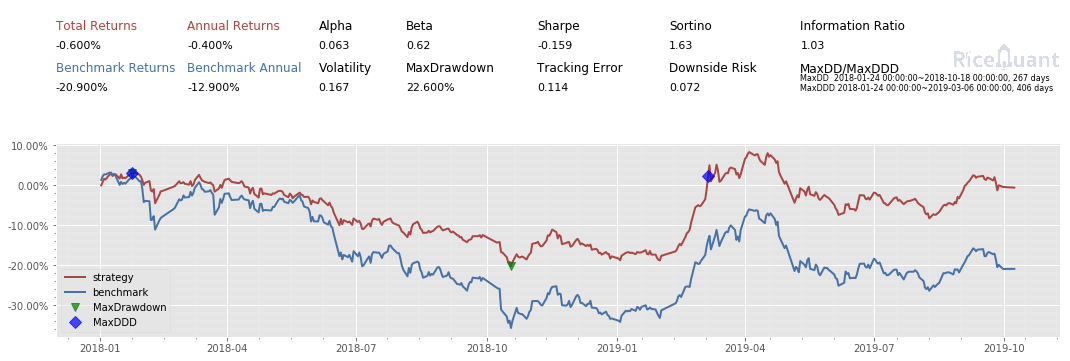

In [22]:
%matplotlib inline
tune_record  = tune_record.rename(columns={'weight':'portfolio_weight'})
#处理权重小, 直接处理为0
# tune_record = tune_record[tune_record['portfolio_weight'] >= 0.05]
result = ricequant_backtesting(tune_record[['trade_date','code','portfolio_weight']])

In [23]:
tune_record[tune_record['trade_date'] == '2019-06-05']
tune_record

,portfolio_weight,industry,er,code,dx,trade_date
0,0.025251,医药生物,0.023278,2422,0.111833,2018-01-02 00:00:00
1,0.024439,机械设备,0.012252,39,-0.020015,2018-01-02 00:00:00
2,0.024439,化工,0.044900,830,0.065639,2018-01-02 00:00:00
3,0.024145,化工,0.032681,601233,0.089354,2018-01-02 00:00:00
4,0.023902,轻工制造,0.014130,2078,0.011787,2018-01-02 00:00:00
5,0.023811,公用事业,0.006845,2573,-0.071442,2018-01-02 00:00:00
6,0.023740,农林牧渔,0.017628,2311,-0.013826,2018-01-02 00:00:00
7,0.023516,汽车,0.004888,887,0.001212,2018-01-02 00:00:00
8,0.023506,电子,0.028888,600183,-0.048935,2018-01-02 00:00:00
9,0.023354,医药生物,0.017038,2038,0.009171,2018-01-02 00:00:00


# 回测记录

In [24]:
print(result.keys())
record = result['sys_analyser']
print(record.keys())
trade_detail = record['trades']
stock_account = record['stock_account']
stock_positions = record['stock_positions']
stock_positions.head()

2019-10-08 INFO dict_keys(['sys_analyser'])
2019-10-08 INFO dict_keys(['summary', 'trades', 'portfolio', 'benchmark_portfolio', 'stock_account', 'stock_positions'])


,avg_price,last_price,market_value,order_book_id,quantity,symbol
date,,,,,,
2018-01-02,24.00,24.00,252000.0,002422.XSHE,10500.0,科伦药业
2018-01-02,22.88,22.88,242528.0,000039.XSHE,10600.0,中集集团
2018-01-02,16.90,16.90,243360.0,000830.XSHE,14400.0,鲁西化工
2018-01-02,9.70,9.70,238620.0,002078.XSHE,24600.0,太阳纸业
2018-01-02,22.83,22.83,237432.0,002573.XSHE,10400.0,清新环境


In [25]:
# 获取指定交易日期的交易记录
trade_detail[trade_detail['trading_datetime'] == '2018-11-29 15:00:00']

,commission,exec_id,last_price,last_quantity,order_book_id,order_id,position_effect,side,symbol,tax,trading_datetime,transaction_cost
datetime,,,,,,,,,,,,


In [26]:
trade_detail[trade_detail['trading_datetime'] == '2018-12-06 15:00:00']

,commission,exec_id,last_price,last_quantity,order_book_id,order_id,position_effect,side,symbol,tax,trading_datetime,transaction_cost
datetime,,,,,,,,,,,,


In [27]:
# 获取指定交易日的持仓仓位
stock_positions[(stock_positions.index == '2018-12-20') & (stock_positions.quantity != 0)].reset_index()

,date,avg_price,last_price,market_value,order_book_id,quantity,symbol
0,2018-12-20,18.600,6.29,32079.00,002699.XSHE,5100.0,美盛文化
1,2018-12-20,5.547,4.42,91494.00,000825.XSHE,20700.0,太钢不锈
2,2018-12-20,4.370,1.33,48545.00,002018.XSHE,36500.0,华信退
3,2018-12-20,24.340,13.62,51837.72,603377.XSHG,3806.0,东方时尚
4,2018-12-20,6.150,4.91,161539.00,600635.XSHG,32900.0,大众公用
5,2018-12-20,7.260,7.20,38642.40,000685.XSHE,5367.0,中山公用
6,2018-12-20,55.870,55.48,82831.64,002841.XSHE,1493.0,视源股份
7,2018-12-20,43.620,41.22,5317.38,000028.XSHE,129.0,国药一致
8,2018-12-20,10.690,10.08,6693.12,300257.XSHE,664.0,开山股份
9,2018-12-20,8.930,8.49,4771.38,600037.XSHG,562.0,歌华有线


In [28]:
stock_positions[(stock_positions.index == '2018-12-27') & (stock_positions.quantity != 0)].reset_index()

,date,avg_price,last_price,market_value,order_book_id,quantity,symbol
0,2018-12-27,18.600,5.55,28305.00,002699.XSHE,5100.0,美盛文化
1,2018-12-27,5.547,4.15,85905.00,000825.XSHE,20700.0,太钢不锈
2,2018-12-27,4.370,1.16,42340.00,002018.XSHE,36500.0,华信退
3,2018-12-27,24.340,14.30,54425.80,603377.XSHG,3806.0,东方时尚
4,2018-12-27,6.150,4.73,155617.00,600635.XSHG,32900.0,大众公用
5,2018-12-27,43.620,40.96,4669.44,000028.XSHE,114.0,国药一致
6,2018-12-27,10.690,10.08,5886.72,300257.XSHE,584.0,开山股份
7,2018-12-27,8.930,8.57,4139.31,600037.XSHG,483.0,歌华有线
8,2018-12-27,7.230,7.06,5520.92,600717.XSHG,782.0,天津港
9,2018-12-27,3.460,3.34,3997.98,600881.XSHG,1197.0,亚泰集团


In [29]:
stock_positions[(stock_positions.index == '2019-01-07') & (stock_positions.quantity != 0)].reset_index()

,date,avg_price,last_price,market_value,order_book_id,quantity,symbol
0,2019-01-07,18.600,5.54,28254.00,002699.XSHE,5100.0,美盛文化
1,2019-01-07,5.547,4.29,88803.00,000825.XSHE,20700.0,太钢不锈
2,2019-01-07,4.370,1.23,44895.00,002018.XSHE,36500.0,华信退
3,2019-01-07,24.340,13.84,52675.04,603377.XSHG,3806.0,东方时尚
4,2019-01-07,6.150,4.74,155946.00,600635.XSHG,32900.0,大众公用
5,2019-01-07,8.892,9.14,92158.62,600037.XSHG,10083.0,歌华有线
6,2019-01-07,7.235,7.37,6500.34,600717.XSHG,882.0,天津港
7,2019-01-07,3.456,3.45,5164.65,600881.XSHG,1497.0,亚泰集团
8,2019-01-07,45.020,42.96,3093.12,000418.XSHE,72.0,小天鹅A
9,2019-01-07,11.558,11.65,5533.75,002373.XSHE,475.0,千方科技


In [30]:
# trade_detail.to_csv('./trades_record.csv', encoding="utf_8_sig")